<a href="https://colab.research.google.com/github/LesnichiyForester/Airfoil_VAEGAN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import random

# Preprocessing (Не запускать)

## CSV Conversion

In [ ]:
def format_numbers(input_string):
    pattern = r'(?<!\d)([+-]?\.\d+|\d+\.)'

    def replace_zeros(match):
        number = match.group(1)
        if '.' in number:
            if number.startswith('.'):
                return '0' + number
            elif number.endswith('1.'):
                return number + '0'
            elif number.startswith('-.'):
                return '-0' + number[1:]
        return number

    output_string = re.sub(pattern, replace_zeros, input_string)

    return output_string

In [ ]:
# source_path = "drive/MyDrive/IITP/test_dataset"
source_path = "drive/MyDrive/IITP/dataset_raw"
destination_path = "drive/MyDrive/IITP/dataset_csv_converted"

In [ ]:
values = []
x_values = []
for filename in os.listdir(source_path):
    source_file_path = os.path.join(source_path, filename)
    with open(source_file_path, 'r') as file:
        data = file.readlines()

    for i in range(1, len(data)):
        data[i] = format_numbers(data[i])

    destination_file_path = os.path.join(destination_path, filename[:-3] + 'csv')
    with open(destination_file_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow([data[0][0:len(data[0])], 'data'])

        # calculating the coefficient for scaling
        values = []
        x_values = []
        for i in range(1, len(data)):

            if data[i] == None or data[i] == ' ' or data[i] == '\n':
                continue

            x, y = data[i].strip().split()
            values.append([float(x), float(y)])
            x_values.append(float(x))
        k = 1 / (max(x_values) - min(x_values))

        # scaling the the values to [0, 1]
        for value in values:
          value[0] += 1 - max(x_values)
          value[0] =  1 - (1 - value[0]) * k

        for value in values:
            csvwriter.writerow(value)

KeyboardInterrupt: 

## Approximation

In [ ]:
def read_points_from_csv(file_path):
    x_values_pos = []
    y_values_pos = []
    x_values_neg = []
    y_values_neg = []
    i = 0
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        lower_surface = False
        for row in reader:
            if i == 0:
                i = 1;
                continue

            if lower_surface:
                x_values_neg.append(float(row[0]))
                y_values_neg.append(float(row[1]))
            else:
                x_values_pos.append(float(row[0]))
                y_values_pos.append(float(row[1]))

            if float(row[0]) < 0.000001:
                x_values_neg.append(x_values_pos[-1])
                y_values_neg.append(y_values_pos[-1])
                lower_surface = True

    return x_values_pos, y_values_pos, x_values_neg, y_values_neg


def approximate_with_polynomial(degree, x_values_pos, y_values_pos,
                                x_values_neg, y_values_neg):
    coefficients_pos = np.polyfit(x_values_pos, y_values_pos, degree)
    coefficients_neg = np.polyfit(x_values_neg, y_values_neg, degree)
    return np.poly1d(coefficients_pos), np.poly1d(coefficients_neg)


def plot_points_and_polynomial(x_values_pos, y_values_pos, polynomial_pos,
                               x_values_neg, y_values_neg, polynomial_neg,
                               filename):
    x_values = x_values_pos + x_values_neg
    y_values = y_values_pos + y_values_neg
    plt.scatter(x_values_neg, y_values_neg, color='blue')
    plt.scatter(x_values_pos, y_values_pos, color='green')

    x_range = np.linspace(min(x_values) - 0.1, max(x_values) + 0.1, 100)
    y_polynomial_pos = polynomial_pos(x_range)
    y_polynomial_neg = polynomial_neg(x_range)
    plt.plot(x_range, y_polynomial_pos, color='red')
    plt.plot(x_range, y_polynomial_neg, color='red')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(filename)
    plt.show()


def plot_points(x_values_pos, y_values_pos,
                x_values_neg, y_values_neg,
                filename):
    x_values = x_values_pos + x_values_neg
    y_values = y_values_pos + y_values_neg
    plt.scatter(x_values_neg, y_values_neg, color='blue')
    plt.scatter(x_values_pos, y_values_pos, color='green')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(filename)
    plt.show()

In [ ]:
source_path = "drive/MyDrive/IITP/dataset_csv_converted"
degree = 3
i = 0
erratic_data = ['naca1', 's4094', 's4095', 's4096', 'fx77w270', 'ua79sfm']
check_data = []
plots = []
for filename in os.listdir(source_path):
    if filename[:-4] in erratic_data:
        continue
    i += 1
    print(filename, i)
    source_file_path = os.path.join(source_path, filename)
    x_values_pos, y_values_pos, x_values_neg, y_values_neg = read_points_from_csv(source_file_path)
    polynomial_pos, polynomial_neg = approximate_with_polynomial(degree,
                                                                 x_values_pos, y_values_pos,
                                                                 x_values_neg, y_values_neg)
    plots.append([polynomial_pos, polynomial_neg,
                  x_values_pos, y_values_pos,
                  x_values_neg, y_values_neg,
                  filename])

In [ ]:
i = 0
for plot in plots:
    plot_points_and_polynomial(plot[2], plot[3], plot[0],
                               plot[4], plot[5], plot[1],
                               plot[6])
    plot_points(plot[2], plot[3],
                               plot[4], plot[5],
                               plot[6])

## 200 Points Generation

In [ ]:
def generate_points(polyfit_obj):
    x = [x/100 for x in range(0, 100)]
    y = np.polyval(polyfit_obj, x)
    return y

In [ ]:
dataset = []
x_values = [x/100 for x in range(0, 100)]
destination_path = "drive/MyDrive/IITP/dataset_preprocessed"
i=0
for plot in plots:
    y_data_vector = [points for points in generate_points(plot[1])]
    y_data_vector += [points for points in generate_points(plot[0])]
    dataset.append([plot[6], y_data_vector])
    '''destination_file_path = os.path.join(destination_path, plot[6])
    with open(destination_file_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow([plot[6][:-3]])
        for point in y_data_vector:
            csvwriter.writerow([point])'''

In [ ]:
for item in dataset:
    plot_points(x_values, item[1][99:199],
                x_values, item[1][0:100],
                item[0])

## train/val/test split

In [ ]:
source_path = "drive/MyDrive/IITP/dataset_preprocessed"
i = 0
for filename in os.listdir(source_path):
    i += 1
print(i)

In [ ]:
import shutil


random.seed(0)
source_path = "drive/MyDrive/IITP/dataset_preprocessed"

def displacer(source_path, destination_path, n):
    file_list = os.listdir(source_path)
    random_files = random.sample(file_list, n)

    for file_name in random_files:
        source_file_path = os.path.join(source_path, file_name)
        destination_file_path = os.path.join(destination_path, file_name)
        shutil.move(source_file_path, destination_file_path)

In [ ]:
destination_path = "drive/MyDrive/IITP/dataset_val"
displacer(source_path, destination_path, 200)

In [ ]:
destination_path = "drive/MyDrive/IITP/dataset_test"
displacer(source_path, destination_path, 49)

In [ ]:
source_path = "drive/MyDrive/IITP/dataset_preprocessed"
i = 0
for filename in os.listdir(source_path):
    i += 1
print(i)

## lowres dataset

In [ ]:
import pandas as pd

def lowres_files(source_path, destination_path):
    csv_files = [file for file in os.listdir(source_path) if file.endswith('.csv')]
    for file in csv_files:
        df = pd.read_csv(os.path.join(source_path, file))
        modified_df = df.iloc[::2][:100]
        modified_df.to_csv(os.path.join(destination_path, file), index=False)

In [ ]:
source_path = "drive/MyDrive/IITP/dataset_val"
destination_path = "drive/MyDrive/IITP/lowres_dataset/val"
lowres_files(source_path, destination_path)

In [ ]:
source_path = "drive/MyDrive/IITP/dataset_test"
destination_path = "drive/MyDrive/IITP/lowres_dataset/test"
lowres_files(source_path, destination_path)

In [ ]:
source_path = "drive/MyDrive/IITP/dataset_preprocessed"
destination_path = "drive/MyDrive/IITP/lowres_dataset/train"
lowres_files(source_path, destination_path)

# Network

## Setup

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import pickle
from pathlib import Path

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
RANDOM_SEED = 42
torch.manual_seed(seed=RANDOM_SEED)
torch.cuda.manual_seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_loss_vs_batch(loss_logs, title):
    x_values = list(range(1, len(loss_logs) + 1))
    plt.plot(x_values, loss_logs, marker='o', color='b', linestyle='-')
    plt.title(title)
    plt.show()
    return

def plot_loss_vs_epoch(loss_logs, loss_logs_val, completed_epochs, start_epoch, title):
    x_values = list(range(start_epoch, completed_epochs))
    loss_logs = loss_logs[(start_epoch - 1) * 86:(completed_epochs - 1) * 86]
    loss_logs_val = loss_logs_val[(start_epoch - 1) * 13:(completed_epochs - 1) * 13]
    loss_logs = [sum(loss_logs[i:i + 15]) / 86 for i in range(0, len(loss_logs), 86)]
    loss_logs_val = [sum(loss_logs_val[i:i + 15]) / 13 for i in range(0, len(loss_logs_val), 13)]
    x_values = [np.log10(x) for x in x_values]

    plt.plot(x_values, loss_logs, marker='o', color='b', linestyle='-')
    plt.plot(x_values, loss_logs_val, marker='o', color='r', linestyle='-')
    plt.title(title)
    plt.show()
    return

In [ ]:
def outputter(x, x_recon, data_length=200):
    x_axis = [i * 1 / int(data_length / 2) for i in range(0, int(data_length / 2))]
    y_plot = x_recon.tolist()
    y_up = y_plot[0:int(data_length / 2)]
    y_bottom = y_plot[int(data_length / 2):data_length + 1]

    plt.figure()
    plt.plot(x_axis, y_up)
    plt.plot(x_axis, y_bottom)

    x_axis = [i * 1 / int(data_length / 2) for i in range(0, int(data_length / 2))]
    y_plot = x.tolist()
    y_up = y_plot[0:int(data_length / 2)]
    y_bottom = y_plot[int(data_length / 2):data_length + 1]

    plt.plot(x_axis, y_up)
    plt.plot(x_axis, y_bottom)
    plt.ylim(-0.1, 0.18)
    plt.show()

In [ ]:
DATA_MODES = ['train', 'val', 'test']
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_str = 'drive/MyDrive/IITP/dataset_preprocessed'
val_str = 'drive/MyDrive/IITP/dataset_val'
test_str ='drive/MyDrive/IITP/dataset_test'

TRAIN_DIR = Path(train_str)
VAL_DIR = Path(val_str)
TEST_DIR = Path(test_str)

train_files = sorted(list(TRAIN_DIR.rglob('*.csv')))
val_files = sorted(list(VAL_DIR.rglob('*.csv')))
test_files = sorted(list(TEST_DIR.rglob('*.csv')))

## lowres Dataset

In [ ]:
# lowres_data
train_str = 'drive/MyDrive/IITP/lowres_dataset/train'
val_str = 'drive/MyDrive/IITP/lowres_dataset/val'
test_str = 'drive/MyDrive/IITP/lowres_dataset/test'

TRAIN_DIR = Path(train_str)
VAL_DIR = Path(val_str)
TEST_DIR = Path(test_str)

train_files = sorted(list(TRAIN_DIR.rglob('*.csv')))
val_files = sorted(list(VAL_DIR.rglob('*.csv')))
test_files = sorted(list(TEST_DIR.rglob('*.csv')))
print(train_files[0])

drive/MyDrive/IITP/lowres_dataset/train/2032c.csv


## Dataset

In [ ]:
class AirfoilsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        if self.mode == 'train':
            self.path = train_str + '/'
        if self.mode == 'val':
            self.path = val_str + '/'
        if self.mode == 'test':
            self.path = test_str + '/'

        self.len_ = len(self.files)


    def __len__(self):
        return self.len_


    def __getitem__(self, index):
        i = 0
        x_temp = []
        reader = csv.reader(open(self.path + self.files[index].name, 'r'))
        for row in reader:
            if i == 0:
              i = 1;
              continue

            x_temp.append(float(row[0]))
        x = torch.tensor(x_temp, dtype=torch.float, requires_grad=True)
        return x

## Loss

In [ ]:
def priorloss(z_mu, z_logvar): # KL divergence between latent space and Gaussian distibution
    return 0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())


def reconloss (x, x_recon):
    return torch.mean(nn.functional.mse_loss(x, x_recon))


def layerloss(y_before_last, y_fake_before_last):
    return torch.mean(torch.abs(y_before_last - y_fake_before_last))


def GANloss(y, y_recon, y_fake):
    return - torch.mean(torch.log(y + 0.0001) + torch.log(1 - y_recon + 0.0001) + torch.log(1 - y_fake + 0.0001))


def noiseloss(x_recon):
    return torch.mean(torch.abs(x_recon[1:] - x_recon[:-1]))

In [ ]:
def encoderloss(x, x_recon, y_before_last, y_fake_before_last, z_mu, z_logvar):
    return 0.0025 * (0.1 * layerloss(y_before_last, y_fake_before_last) + \
           10 * reconloss(x, x_recon) + \
           0 * noiseloss(x_recon))

def decoderloss(x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last, z_mu, z_logvar):
    return 5 * (0.1 * layerloss(y_before_last, y_fake_before_last) + \
           10 * reconloss(x, x_recon) - \
           1 * GANloss(y, y_recon, y_fake) + \
           0 * noiseloss(x_recon))

def discriminatorloss(y, y_recon, y_fake):
    return GANloss(y, y_recon, y_fake)  # разные знаки с decoderloss

## Architecture

In [ ]:
#@title original network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(200, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 32),
            nn.LeakyReLU(0.2))
        self.fc_mean = nn.Linear(32, 32)
        self.fc_logvar = nn.Linear(32, 32)

    def forward(self, x):
        z_hid = self.encoder(x)
        z_mu = self.fc_mean(z_hid)
        z_logvar = self.fc_logvar(z_hid)
        return z_mu, z_logvar


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 200),
            nn.Tanh())

    def forward(self, x):
        return self.decoder(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(200, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid())

    def forward(self, x):
        intermediate_output = None
        for i, module in enumerate(self.discriminator): # Calculations of the second-to-last neuron layer are required for layerloss
            x = module(x)
            if i == 2:
                y_before_last = x
        y = x
        return y, y_before_last

In [ ]:
#@title complexer network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(200, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2))
        self.fc_mean = nn.Linear(32, 32)
        self.fc_logvar = nn.Linear(32, 32)

    def forward(self, x):
        z_hid = self.encoder(x)
        z_mu = self.fc_mean(z_hid)
        z_logvar = self.fc_logvar(z_hid)
        return z_mu, z_logvar


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 200),
            nn.Tanh())

    def forward(self, x):
        return self.decoder(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(200, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid())

    def forward(self, x):
        intermediate_output = None
        for i, module in enumerate(self.discriminator): # Calculations of the second-to-last neuron layer are required for layerloss
            x = module(x)
            if i == 2:
                y_before_last = x
        y = x
        return y, y_before_last

In [ ]:
#@title simpler network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(200, 192),
            nn.LeakyReLU(0.2),
            nn.Linear(192, 96),
            nn.LeakyReLU(0.2),
            nn.Linear(96, 32),
            nn.LeakyReLU(0.2))
        self.fc_mean = nn.Linear(32, 32)
        self.fc_logvar = nn.Linear(32, 32)

    def forward(self, x):
        z_hid = self.encoder(x)
        z_mu = self.fc_mean(z_hid)
        z_logvar = self.fc_logvar(z_hid)
        return z_mu, z_logvar


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(32, 96),
            nn.LeakyReLU(0.2),
            nn.Linear(96, 192),
            nn.LeakyReLU(0.2),
            nn.Linear(192, 200),
            nn.Tanh())

    def forward(self, x):
        return self.decoder(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(200, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        intermediate_output = None
        for i, module in enumerate(self.discriminator): # Calculations of the second-to-last neuron layer are required for layerloss
            x = module(x)
            if i == 2:
                y_before_last = x
        y = x
        return y, y_before_last

In [ ]:
#@title larger latent network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(200, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 40),
            nn.LeakyReLU(0.2))
        self.fc_mean = nn.Linear(40, 40)
        self.fc_logvar = nn.Linear(40, 40)

    def forward(self, x):
        z_hid = self.encoder(x)
        z_mu = self.fc_mean(z_hid)
        z_logvar = self.fc_logvar(z_hid)
        return z_mu, z_logvar


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(40, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 200),
            nn.Tanh())

    def forward(self, x):
        return self.decoder(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(200, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid())

    def forward(self, x):
        intermediate_output = None
        for i, module in enumerate(self.discriminator): # Calculations of the second-to-last neuron layer are required for layerloss
            x = module(x)
            if i == 2:
                y_before_last = x
        y = x
        return y, y_before_last

In [ ]:
#@title lowres network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2))
        self.fc_mean = nn.Linear(32, 32)
        self.fc_logvar = nn.Linear(32, 32)

    def forward(self, x):
        z_hid = self.encoder(x)
        z_mu = self.fc_mean(z_hid)
        z_logvar = self.fc_logvar(z_hid)
        return z_mu, z_logvar


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 100),
            nn.Tanh())

    def forward(self, x):
        return self.decoder(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        intermediate_output = None
        for i, module in enumerate(self.discriminator): # Calculations of the second-to-last neuron layer are required for layerloss
            x = module(x)
            if i == 2:
                y_before_last = x
        y = x
        return y, y_before_last

In [ ]:
class VAEGAN(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(VAEGAN, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        # latent representation
        z_mu, z_logvar = self.encoder(x)

        # Reparameterization trick
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        z = z_mu + eps * std
        z_fake = torch.randn_like(z)

        x_recon = self.decoder(z)
        x_fake = self.decoder(z_fake)

        y_fake, y_fake_before_last = self.discriminator(x_fake)
        y_recon, y_recon_before_last = self.discriminator(x_recon)
        y, y_before_last = self.discriminator(x)

        return z, z_mu, z_logvar, x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last

## Training

In [ ]:
batch_size = 16
dataset_train = AirfoilsDataset(train_files, 'train')
dataset_val = AirfoilsDataset(val_files, 'val')
dataset_test = AirfoilsDataset(test_files, 'test')
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [ ]:
#@title Loading pretrained

load_as = 'latent_40_epochs_790'
checkpoint = torch.load('drive/MyDrive/IITP/noise_vaegan/encoder_' + load_as + '.pth', map_location=torch.device('cpu'))
loaded_encoder = Encoder()
loaded_encoder.load_state_dict(torch.load('drive/MyDrive/IITP/noise_vaegan/encoder_' + load_as + '.pth'))

checkpoint = torch.load('drive/MyDrive/IITP/noise_vaegan/decoder_' + load_as + '.pth', map_location=torch.device('cpu'))
loaded_decoder = Decoder()
loaded_decoder.load_state_dict(torch.load('drive/MyDrive/IITP/noise_vaegan/decoder_' + load_as + '.pth'))

checkpoint = torch.load('drive/MyDrive/IITP/noise_vaegan/discriminator_' + load_as + '.pth', map_location=torch.device('cpu'))
loaded_discriminator = Discriminator()
loaded_discriminator.load_state_dict(torch.load('drive/MyDrive/IITP/noise_vaegan/discriminator_' + load_as + '.pth'))

checkpoint = torch.load('drive/MyDrive/IITP/noise_vaegan/vaegan_' + load_as + '.pth', map_location=torch.device('cpu'))
vaegan = VAEGAN(loaded_encoder, loaded_decoder, loaded_discriminator)
vaegan.load_state_dict(torch.load('drive/MyDrive/IITP/noise_vaegan/vaegan_' + load_as + '.pth'))

loaded_encoder.eval()
loaded_decoder.eval()
loaded_discriminator.eval()
vaegan.eval()

In [ ]:
encoder_loss_logs = []  # Reset loss logs
decoder_loss_logs = []
discriminator_loss_logs = []
encoder_loss_logs_val = []
decoder_loss_logs_val = []
discriminator_loss_logs_val = []

In [ ]:
lr_start = 0.00015
lr = lr_start
lr_end = 0.00001
num_epochs = 5000
stop_slowing_epoch = 200
cur_epoch = 419

In [ ]:
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()
vaegan = VAEGAN(encoder, decoder, discriminator).to(device)


encoder_optimizer = torch.optim.Adam(vaegan.encoder.parameters(), lr=lr_start, betas=(0.9, 0.99))
decoder_optimizer = torch.optim.Adam(vaegan.decoder.parameters(), lr=lr_start, betas=(0.9, 0.99))
discriminator_optimizer = torch.optim.Adam(vaegan.discriminator.parameters(), lr=lr_start, betas=(0.9, 0.99))

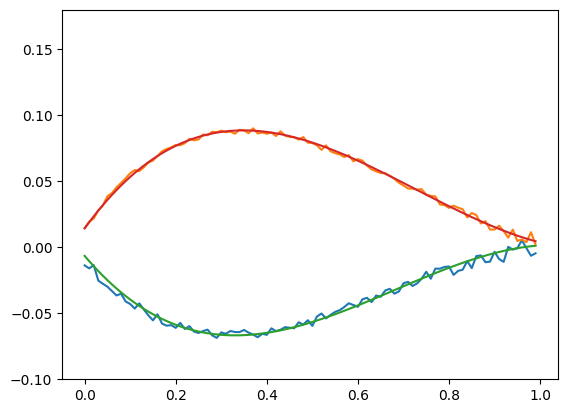

    Epoch [330/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.117889, disloss: 27.630692, noise: 0.026531


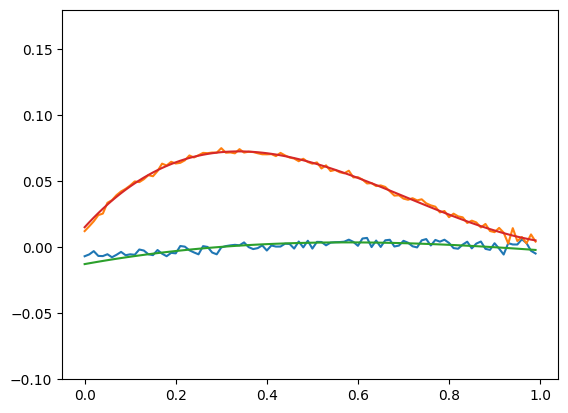

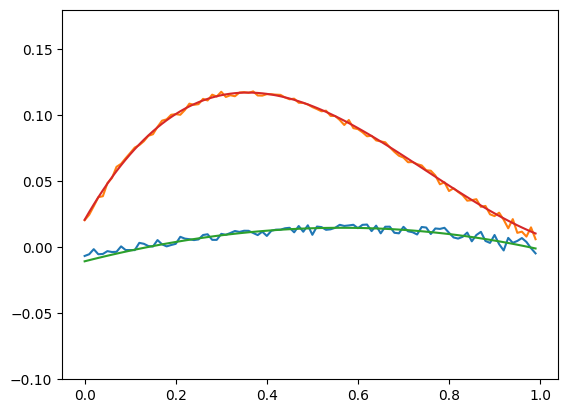

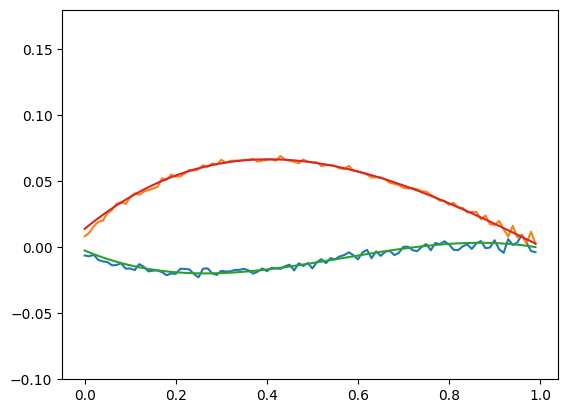

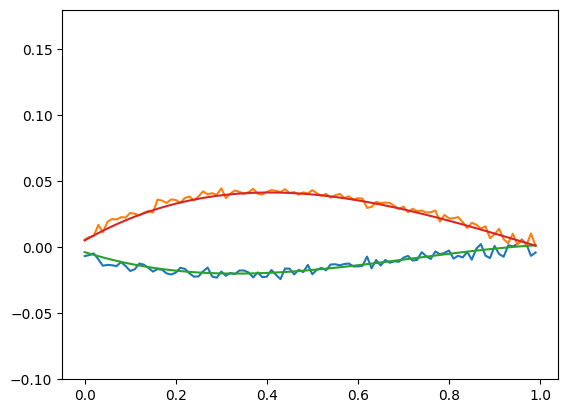

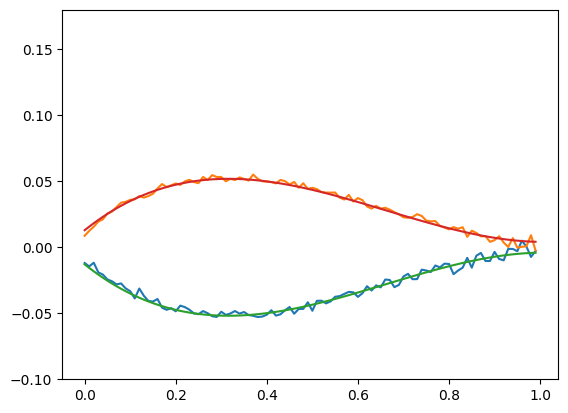

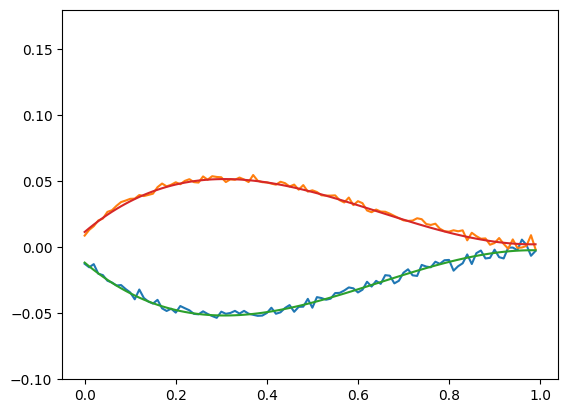

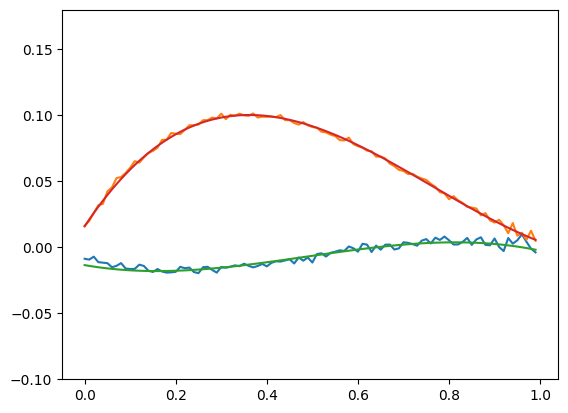

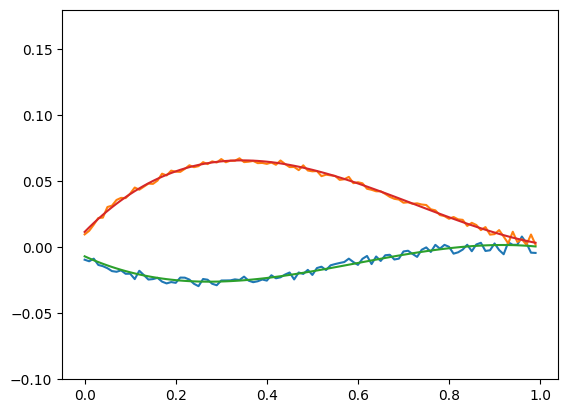

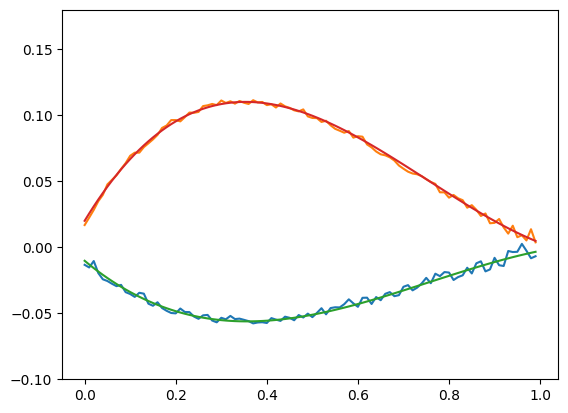

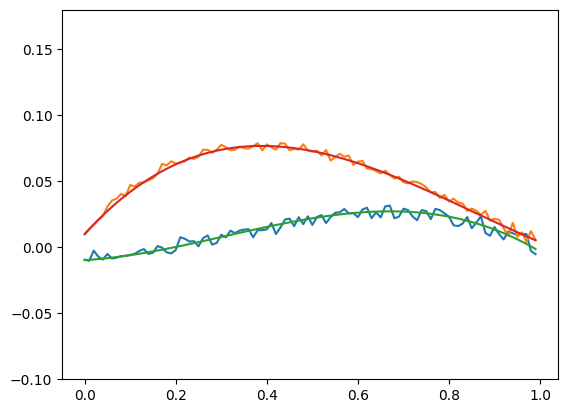

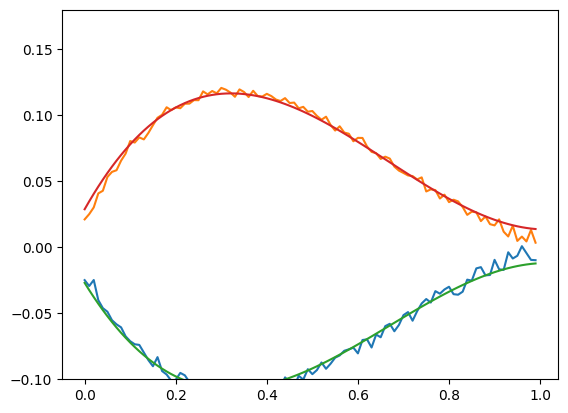

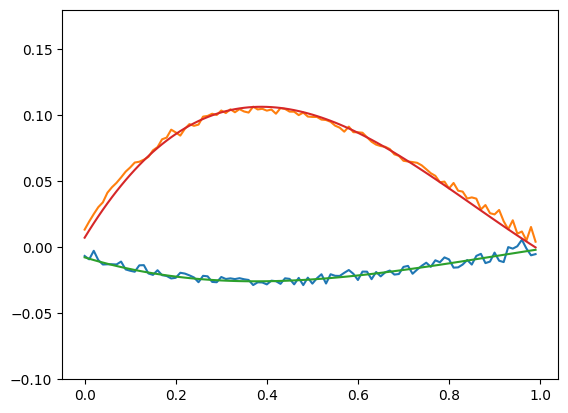

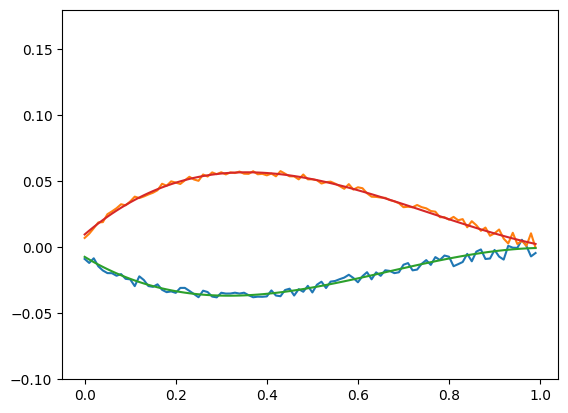

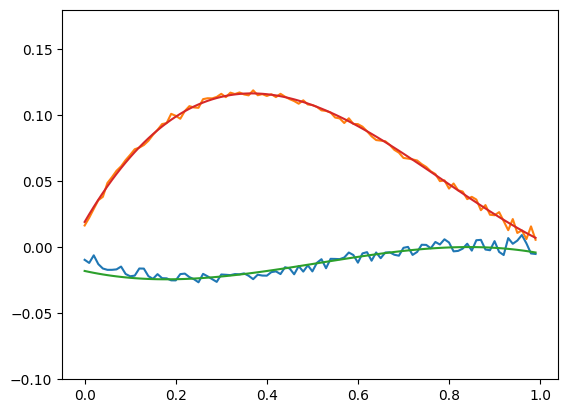

VAL Epoch [330/5000], Batch [0/13], lr: 0.00015, encloss: 1.8e-05, decloss: -138.116333, disloss: 27.630367, noise: 0.021889


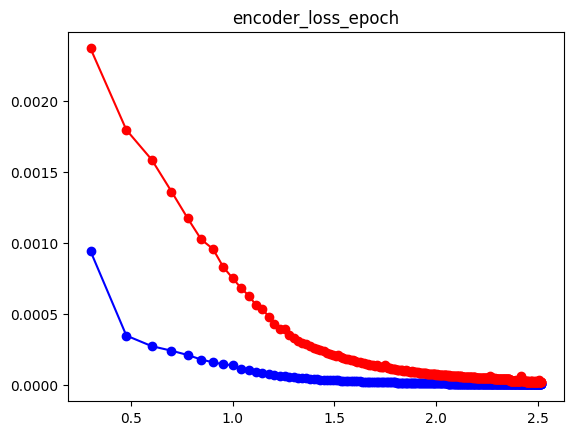

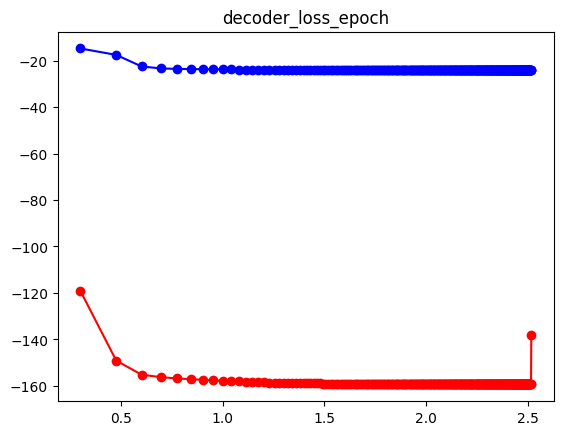

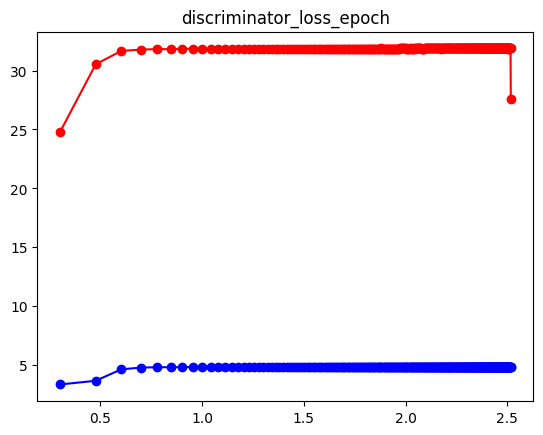

    Epoch [331/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.115906, disloss: 27.630278, noise: 0.028715
VAL Epoch [331/5000], Batch [0/13], lr: 0.00015, encloss: 1.8e-05, decloss: -138.115936, disloss: 27.63051, noise: 0.023494
    Epoch [332/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.116028, disloss: 27.630522, noise: 0.027295
VAL Epoch [332/5000], Batch [0/13], lr: 0.00015, encloss: 1.8e-05, decloss: -138.113434, disloss: 27.629717, noise: 0.024197
    Epoch [333/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.115005, disloss: 27.63002, noise: 0.025906
VAL Epoch [333/5000], Batch [0/13], lr: 0.00015, encloss: 1.8e-05, decloss: -138.118271, disloss: 27.630772, noise: 0.017147
    Epoch [334/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.117126, disloss: 27.630552, noise: 0.023117
VAL Epoch [334/5000], Batch [0/13], lr: 0.00015, encloss: 1.8e-05, decloss: -138.116821, disloss: 27.630659, noise: 0.023474
  

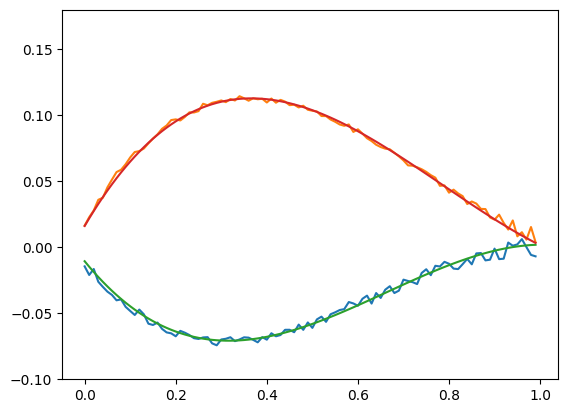

    Epoch [340/5000], Batch [0/86], lr: 0.00015, encloss: 1.7e-05, decloss: -138.116547, disloss: 27.630243, noise: 0.024942


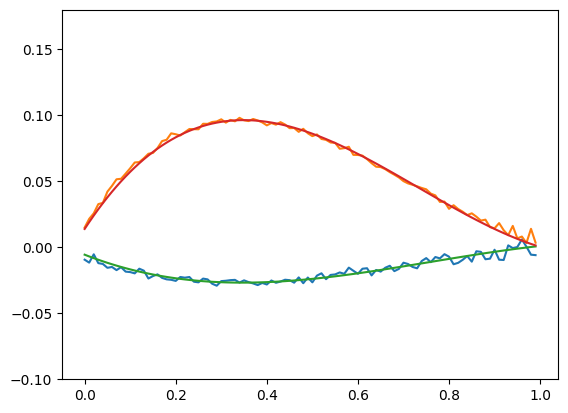

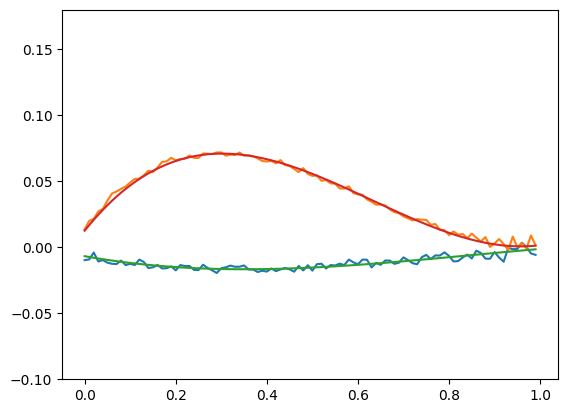

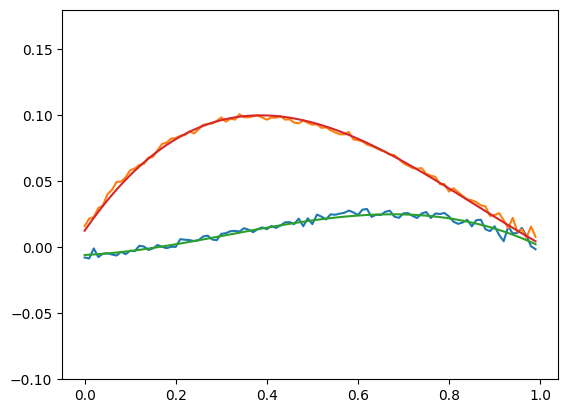

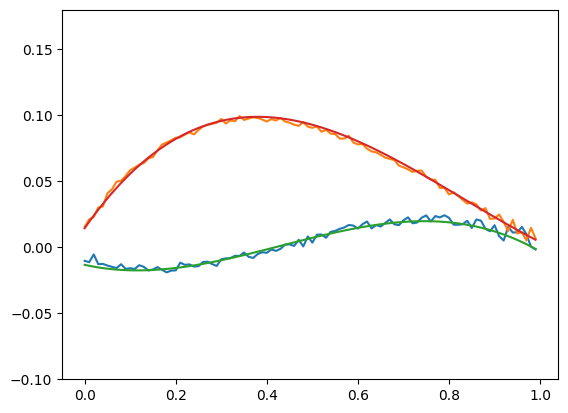

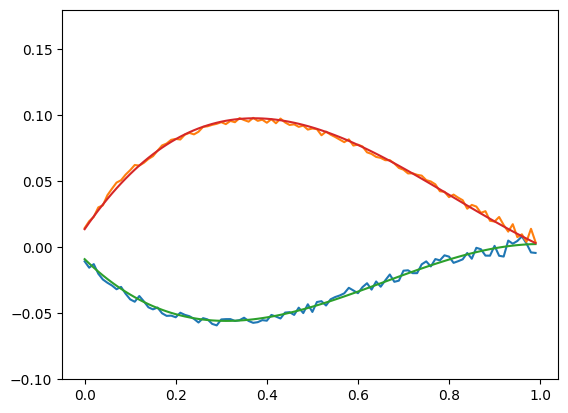

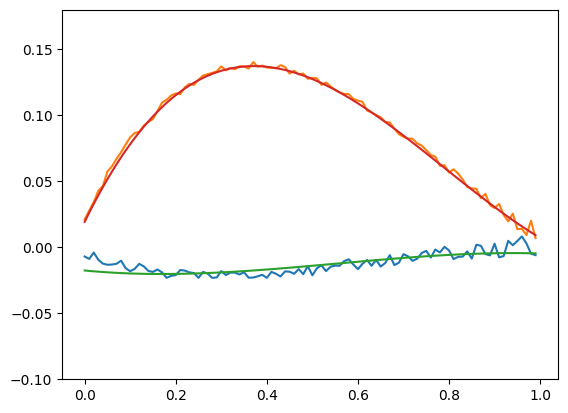

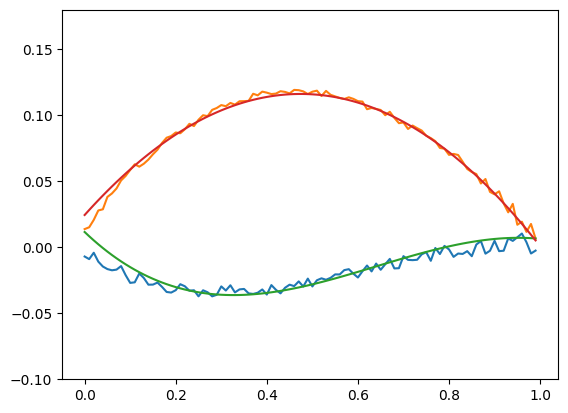

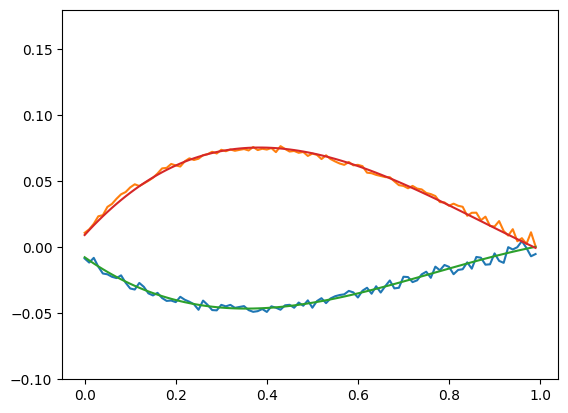

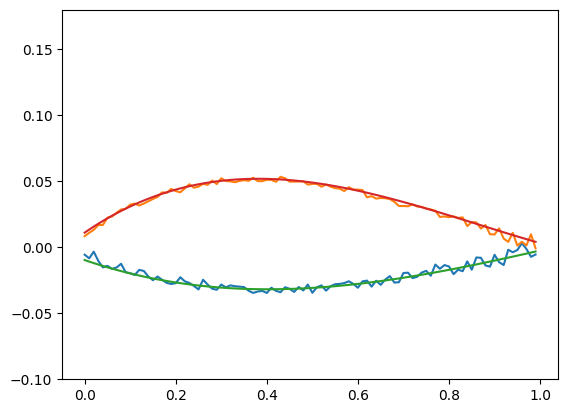

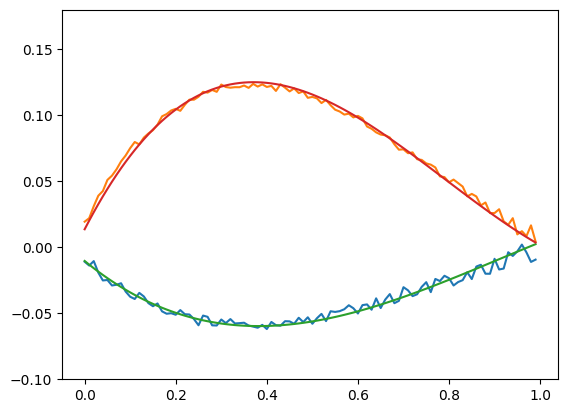

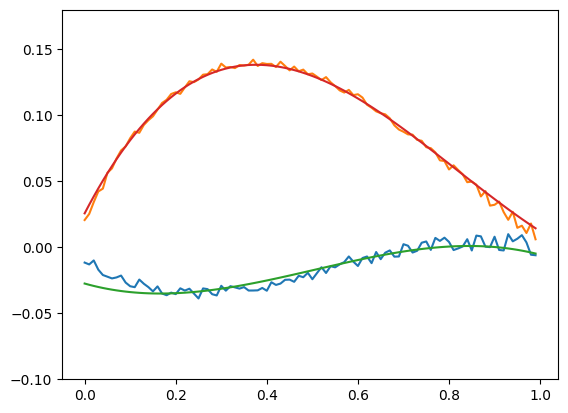

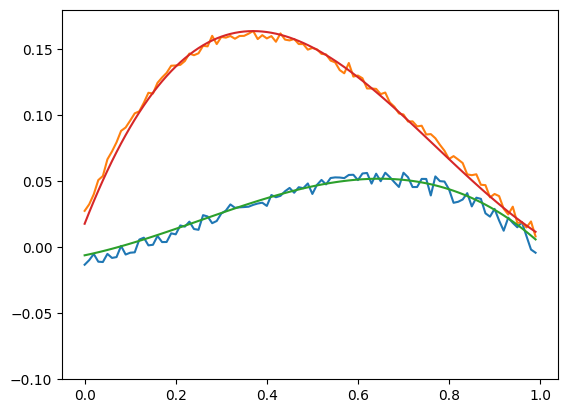

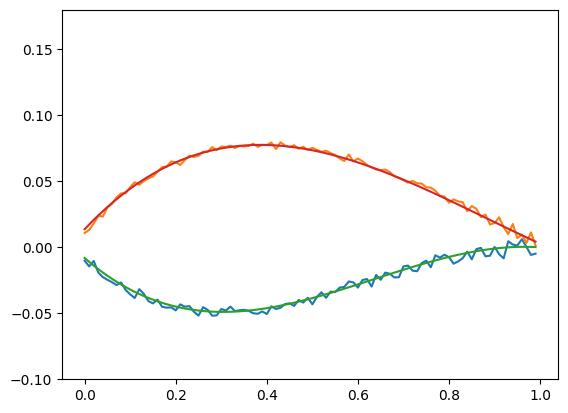

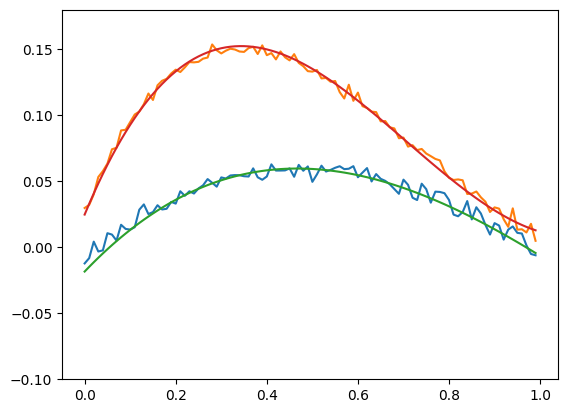

VAL Epoch [340/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.118332, disloss: 27.630585, noise: 0.020613


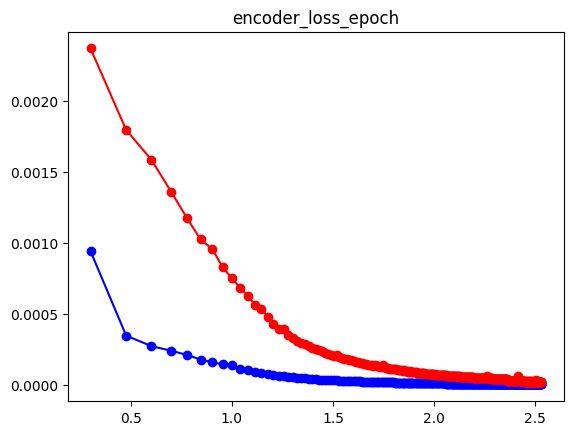

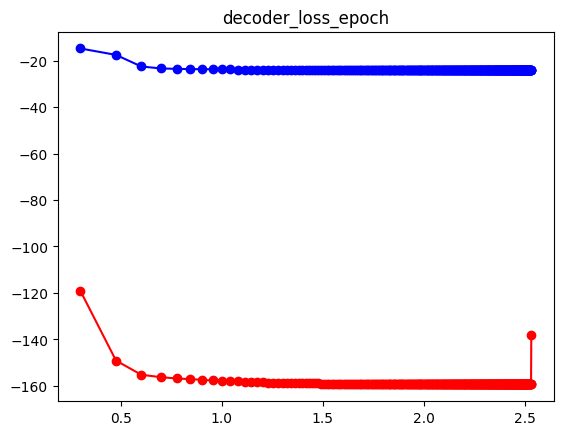

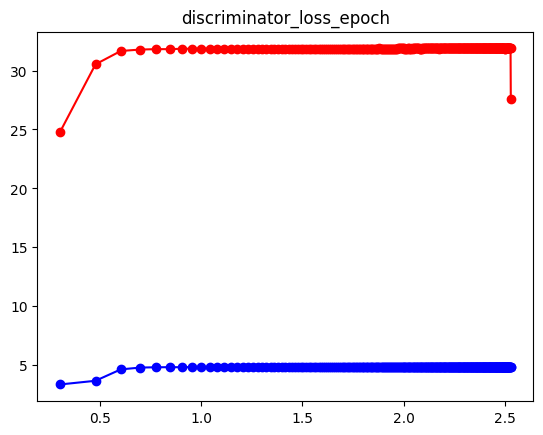

    Epoch [341/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.116959, disloss: 27.630436, noise: 0.030935
VAL Epoch [341/5000], Batch [0/13], lr: 0.00015, encloss: 1.8e-05, decloss: -138.116669, disloss: 27.630388, noise: 0.01824
    Epoch [342/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.11557, disloss: 27.63036, noise: 0.025018
VAL Epoch [342/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.118881, disloss: 27.630768, noise: 0.033835
    Epoch [343/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.118713, disloss: 27.63077, noise: 0.025921
VAL Epoch [343/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.115906, disloss: 27.63014, noise: 0.033011
    Epoch [344/5000], Batch [0/86], lr: 0.00015, encloss: 1.7e-05, decloss: -138.114594, disloss: 27.629869, noise: 0.020013
VAL Epoch [344/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.119141, disloss: 27.630806, noise: 0.02136
    Ep

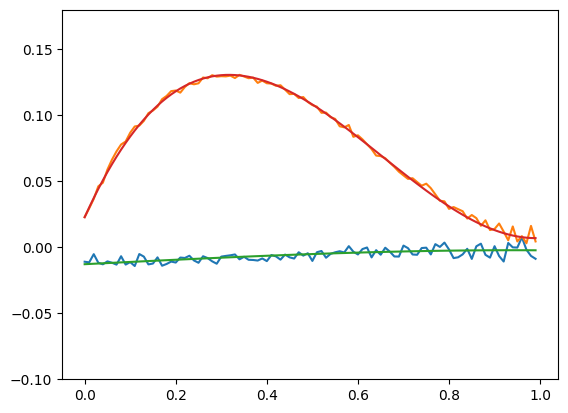

    Epoch [350/5000], Batch [0/86], lr: 0.00015, encloss: 1.7e-05, decloss: -138.119659, disloss: 27.630661, noise: 0.019354


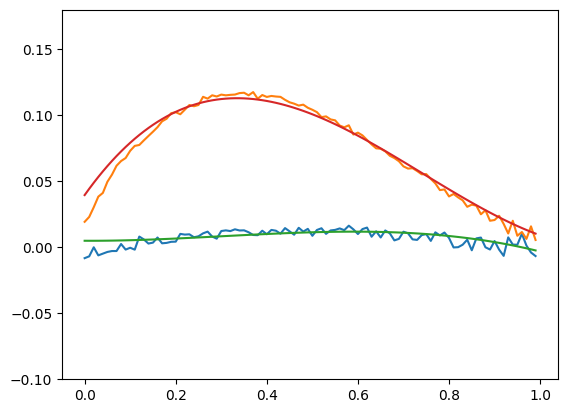

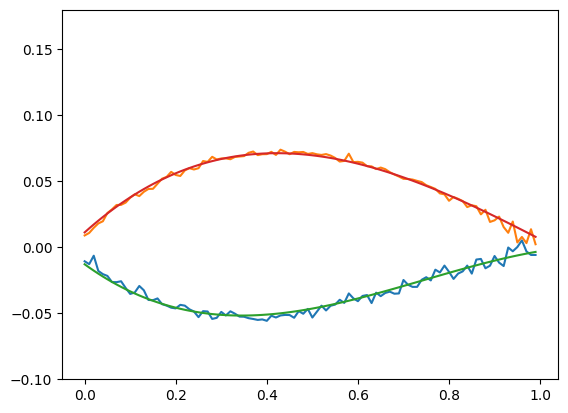

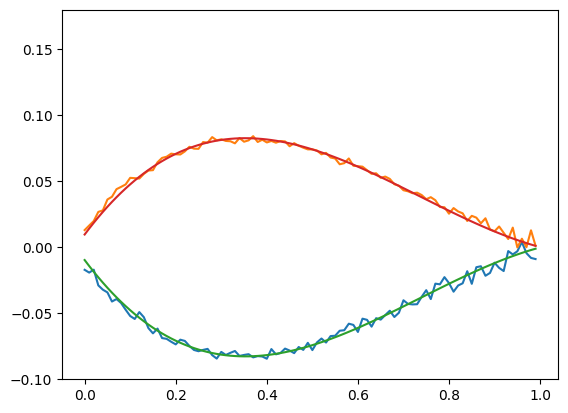

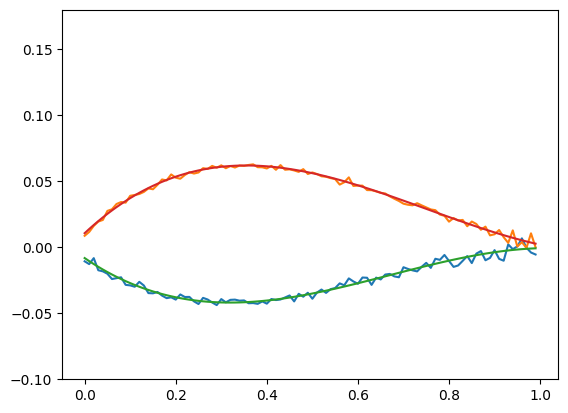

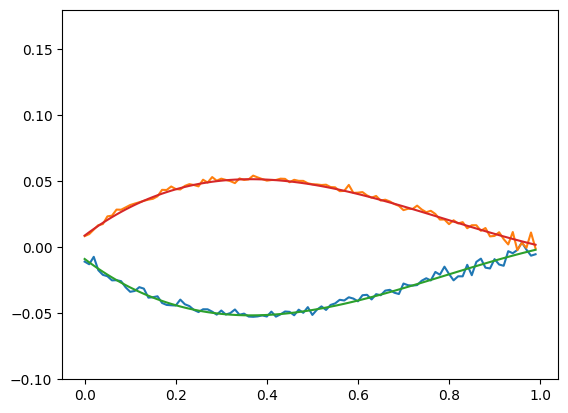

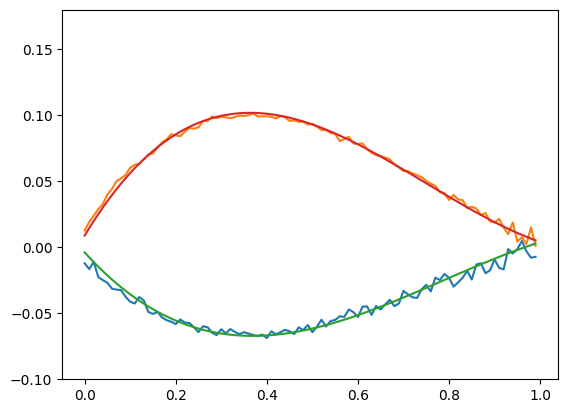

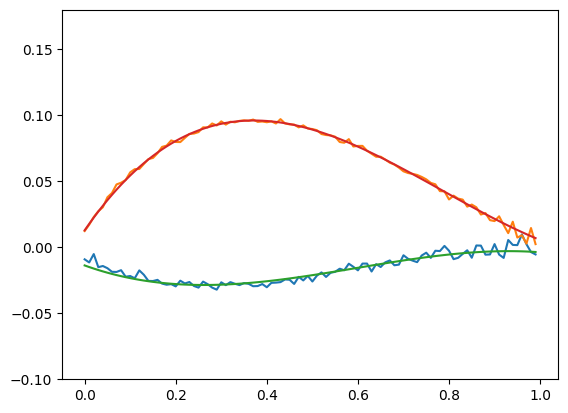

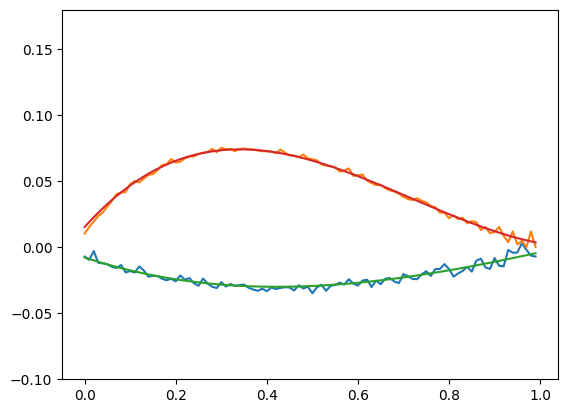

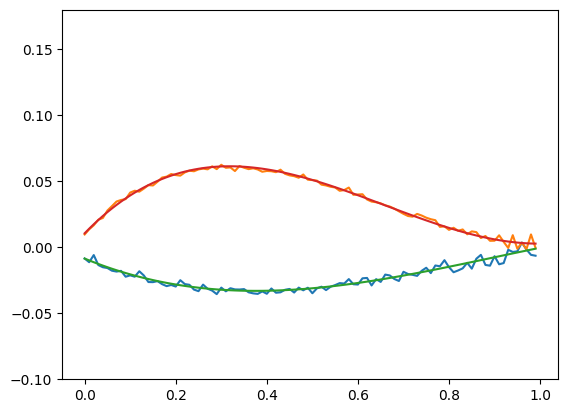

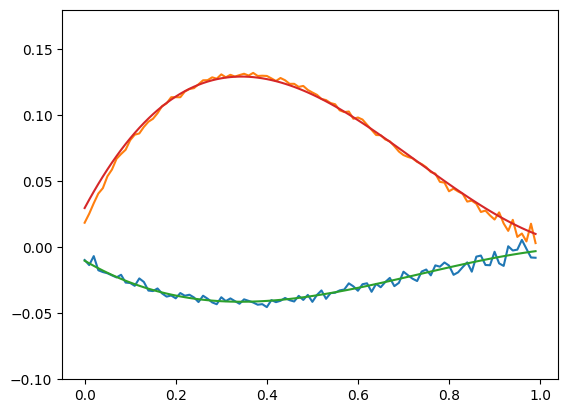

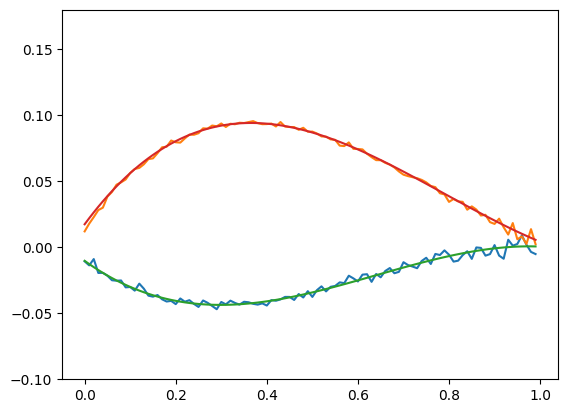

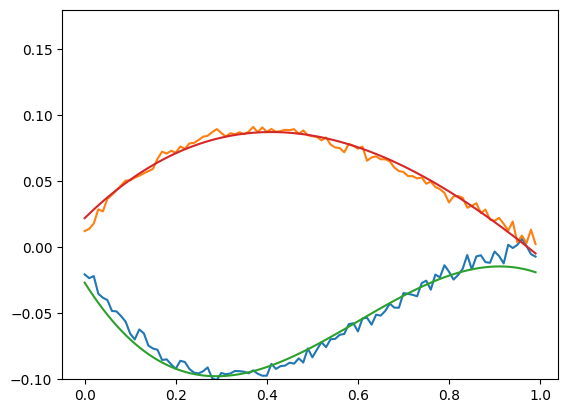

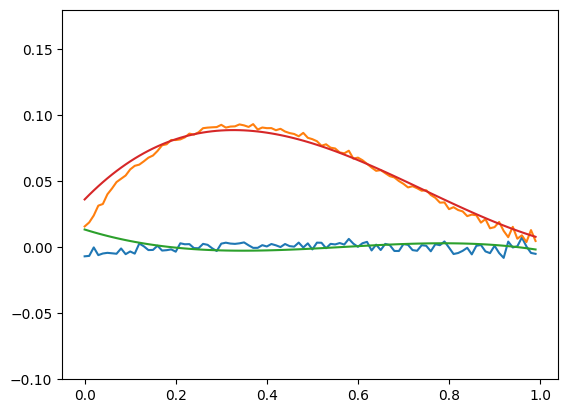

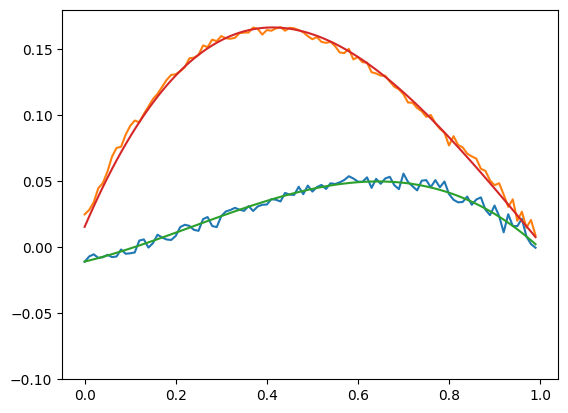

VAL Epoch [350/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.119904, disloss: 27.630703, noise: 0.02502


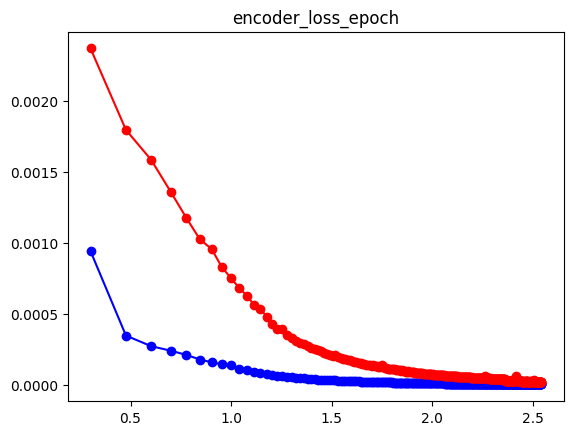

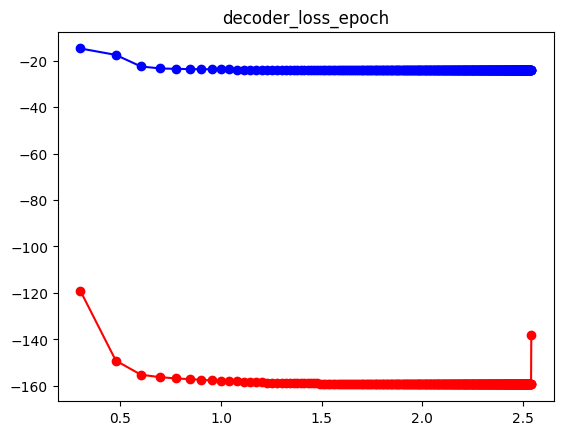

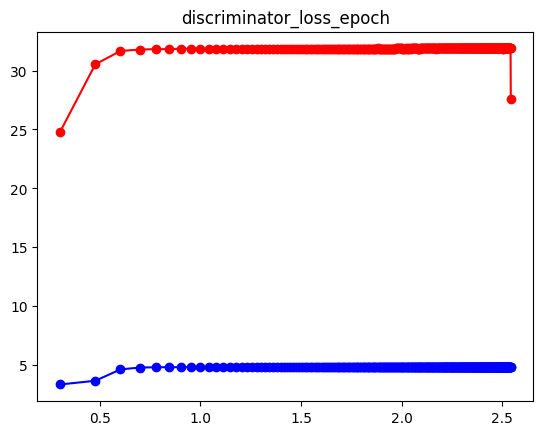

    Epoch [351/5000], Batch [0/86], lr: 0.00015, encloss: 1.7e-05, decloss: -138.120407, disloss: 27.630758, noise: 0.023367
VAL Epoch [351/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.120544, disloss: 27.630749, noise: 0.019405
    Epoch [352/5000], Batch [0/86], lr: 0.00015, encloss: 1.7e-05, decloss: -138.119751, disloss: 27.630743, noise: 0.021732
VAL Epoch [352/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.117401, disloss: 27.630053, noise: 0.018062
    Epoch [353/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.116913, disloss: 27.629974, noise: 0.024195
VAL Epoch [353/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.120163, disloss: 27.630758, noise: 0.028308
    Epoch [354/5000], Batch [0/86], lr: 0.00015, encloss: 1.7e-05, decloss: -138.120026, disloss: 27.630777, noise: 0.022866
VAL Epoch [354/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.119217, disloss: 27.630512, noise: 0.015501


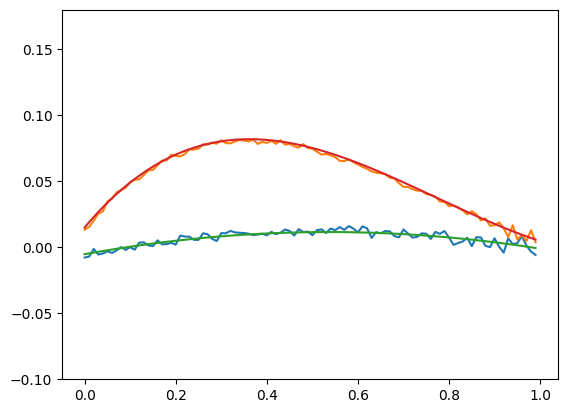

    Epoch [360/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.12085, disloss: 27.630655, noise: 0.020459


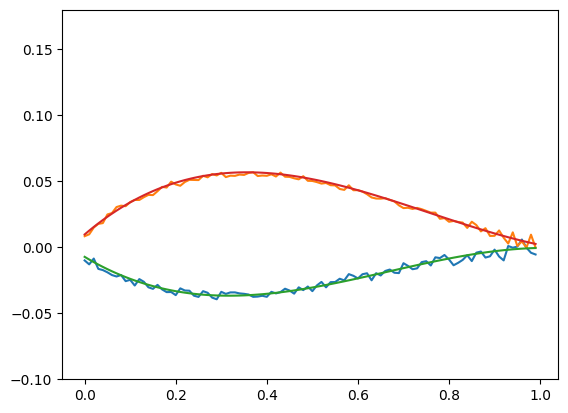

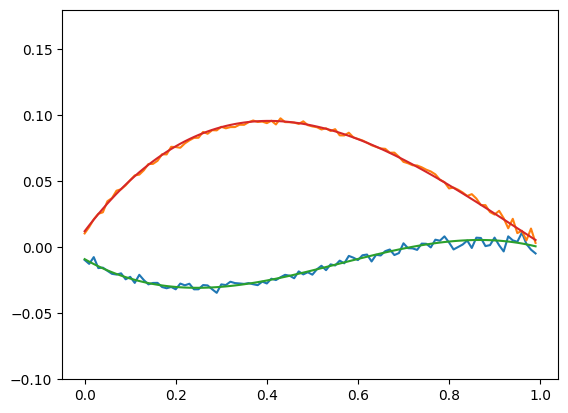

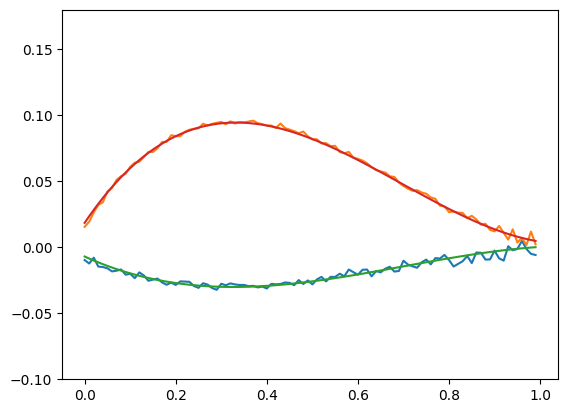

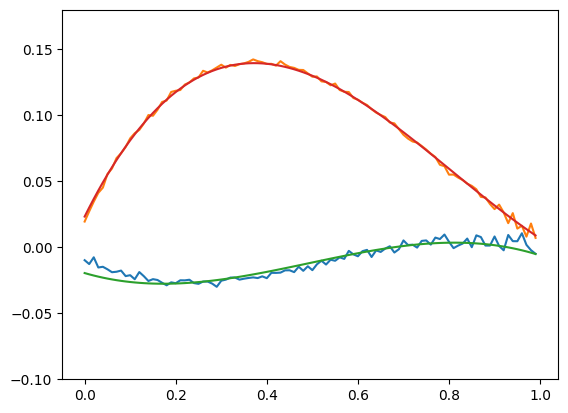

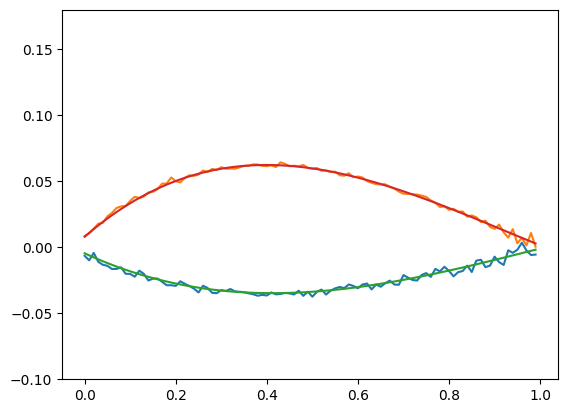

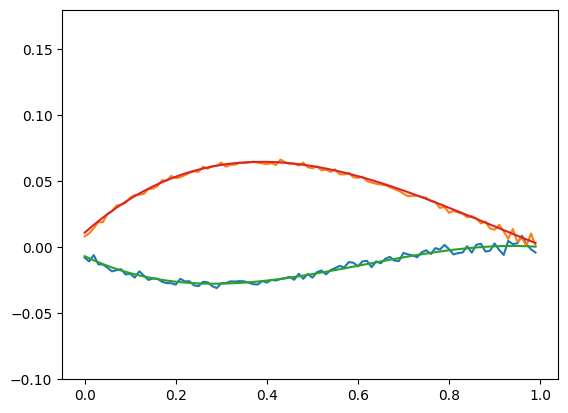

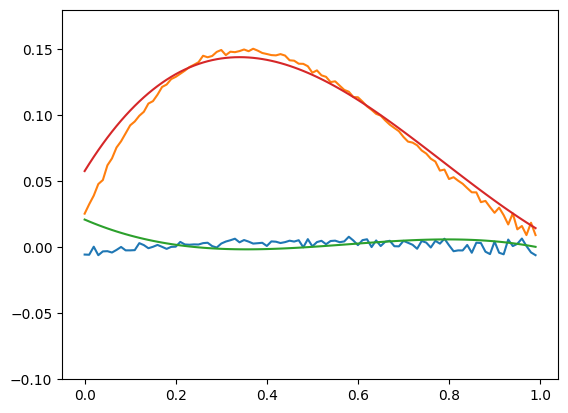

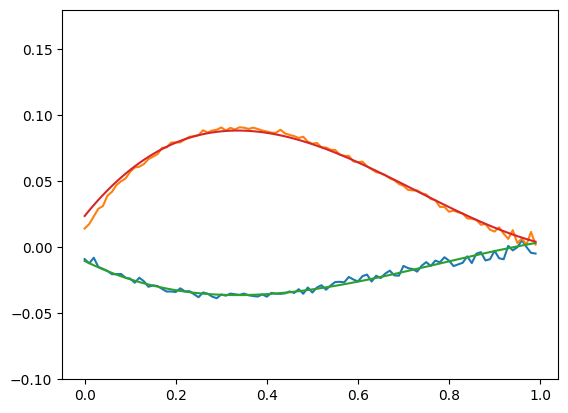

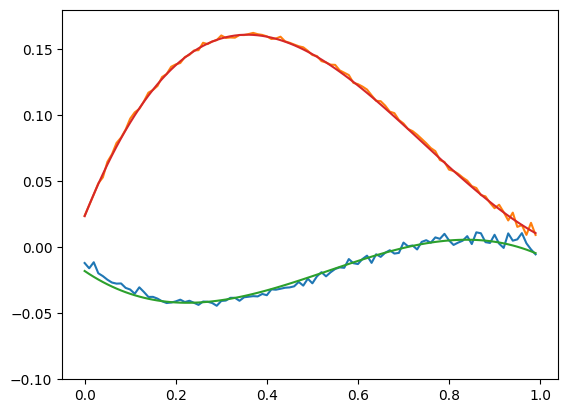

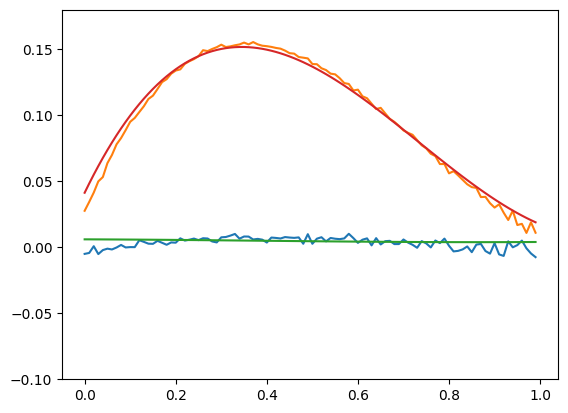

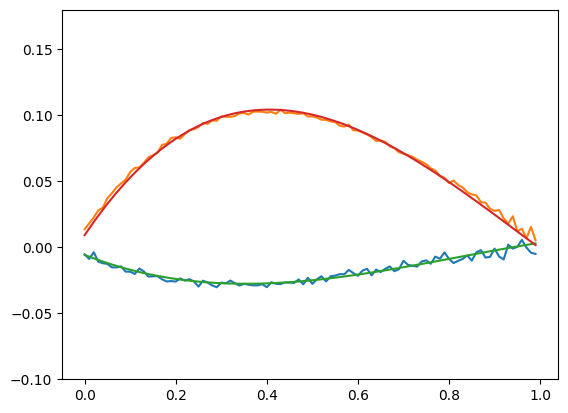

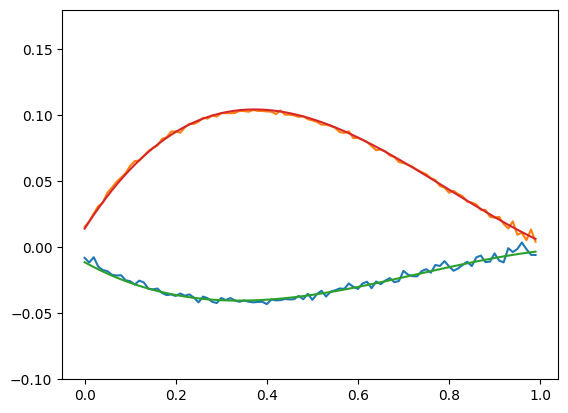

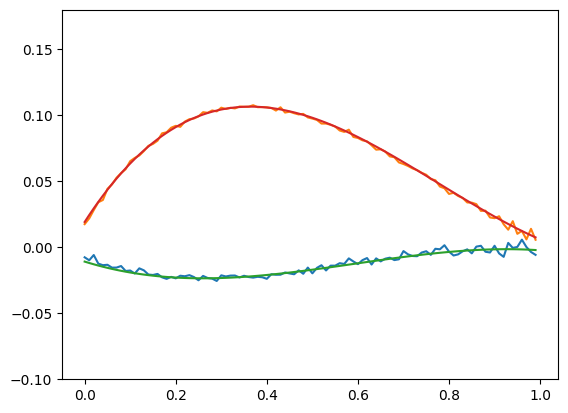

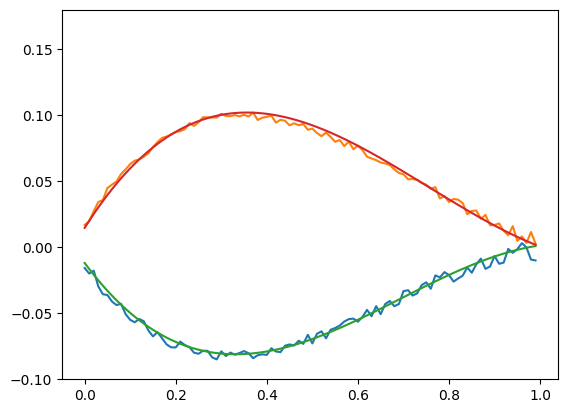

VAL Epoch [360/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.121262, disloss: 27.630775, noise: 0.026462


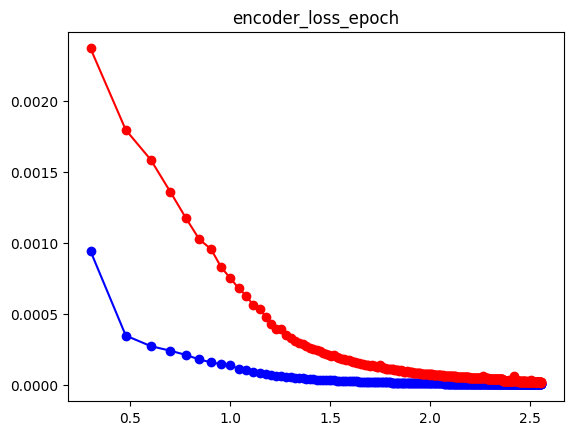

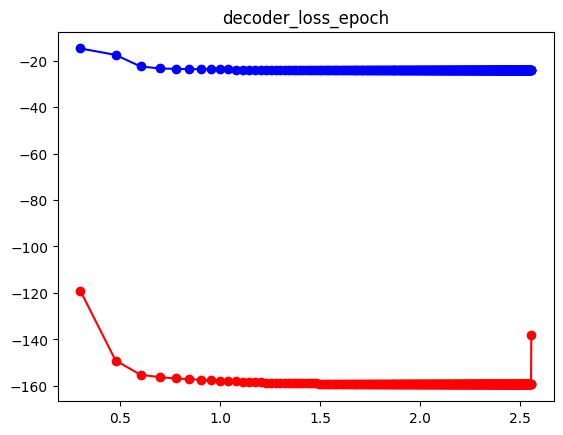

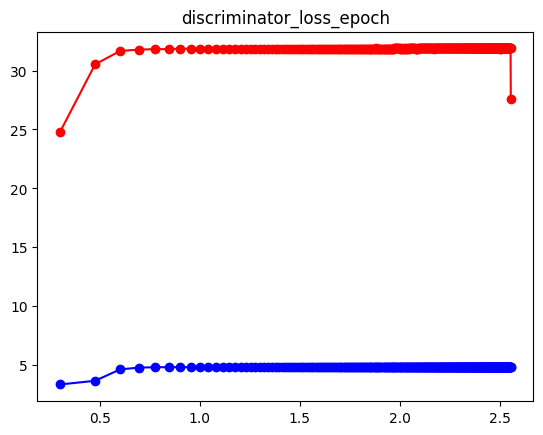

    Epoch [361/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.121124, disloss: 27.630772, noise: 0.029721
VAL Epoch [361/5000], Batch [0/13], lr: 0.00015, encloss: 3e-05, decloss: -138.093964, disloss: 27.630949, noise: 0.024275
    Epoch [362/5000], Batch [0/86], lr: 0.00015, encloss: 3e-05, decloss: -138.094803, disloss: 27.631023, noise: 0.023138
VAL Epoch [362/5000], Batch [0/13], lr: 0.00015, encloss: 2.1e-05, decloss: -138.111343, disloss: 27.630619, noise: 0.018831
    Epoch [363/5000], Batch [0/86], lr: 0.00015, encloss: 2.1e-05, decloss: -138.112579, disloss: 27.630762, noise: 0.01814
VAL Epoch [363/5000], Batch [0/13], lr: 0.00015, encloss: 2.6e-05, decloss: -138.099838, disloss: 27.630428, noise: 0.020798
    Epoch [364/5000], Batch [0/86], lr: 0.00015, encloss: 2.6e-05, decloss: -138.102768, disloss: 27.630949, noise: 0.027859
VAL Epoch [364/5000], Batch [0/13], lr: 0.00015, encloss: 2e-05, decloss: -138.113525, disloss: 27.630556, noise: 0.039071
    Epo

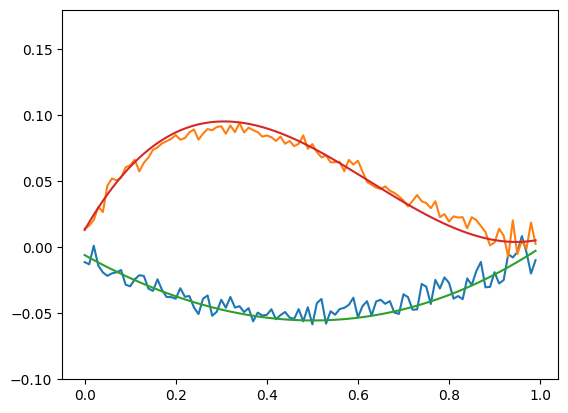

    Epoch [370/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.116653, disloss: 27.630629, noise: 0.021295


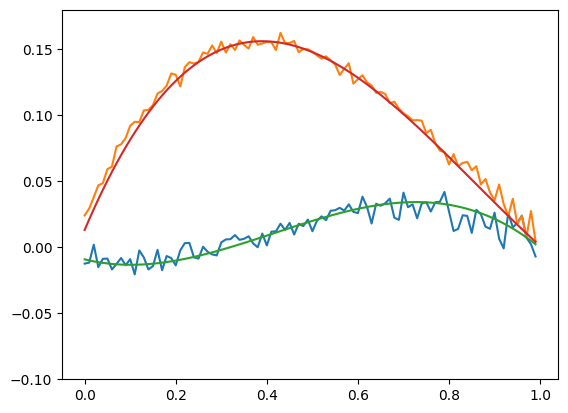

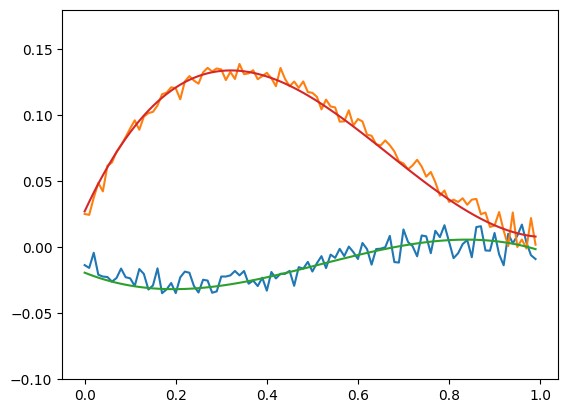

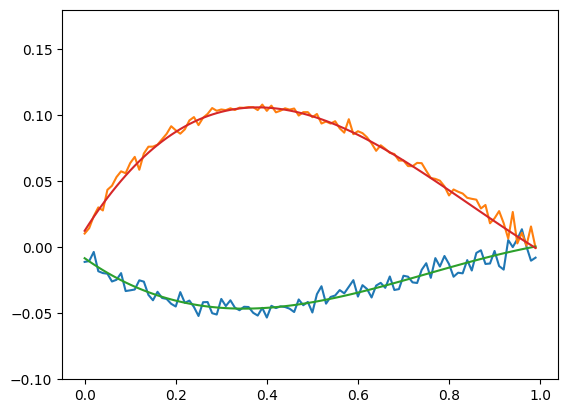

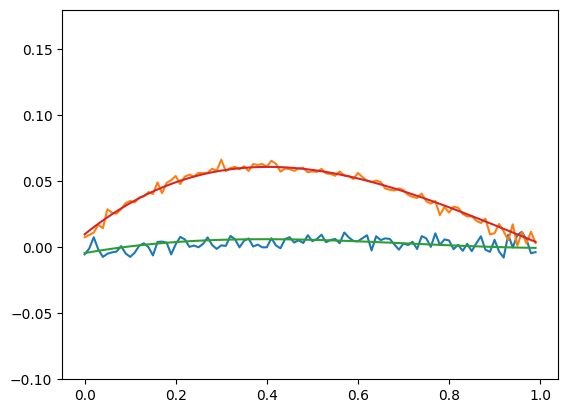

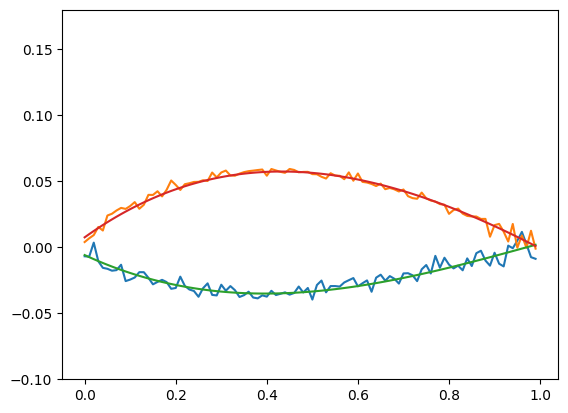

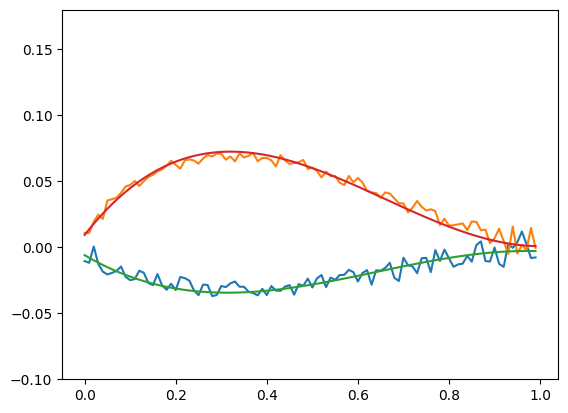

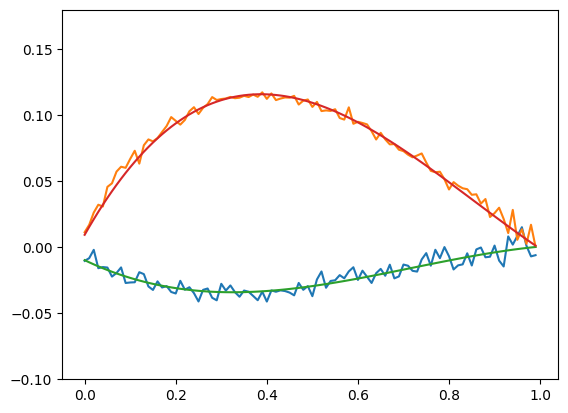

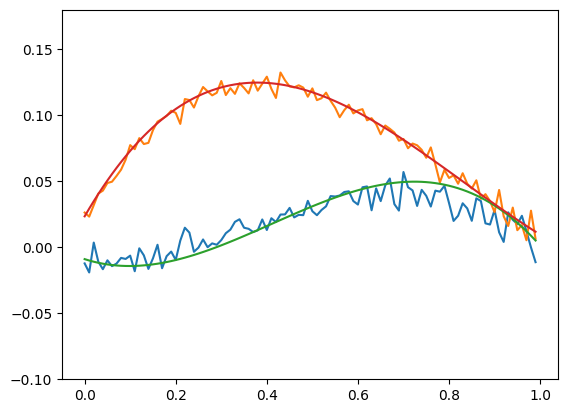

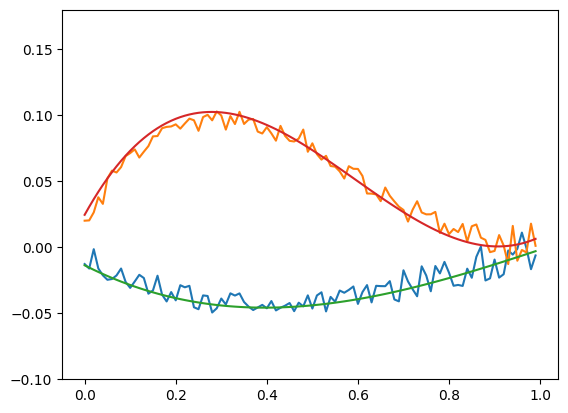

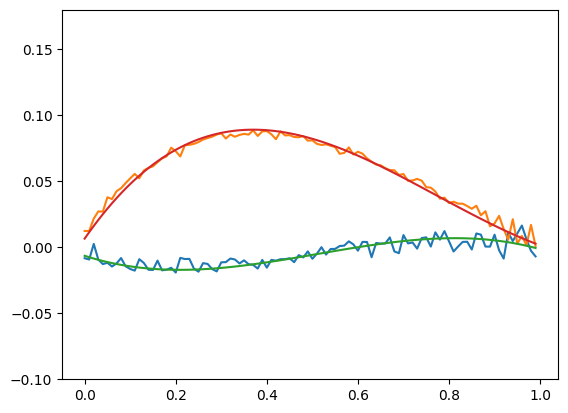

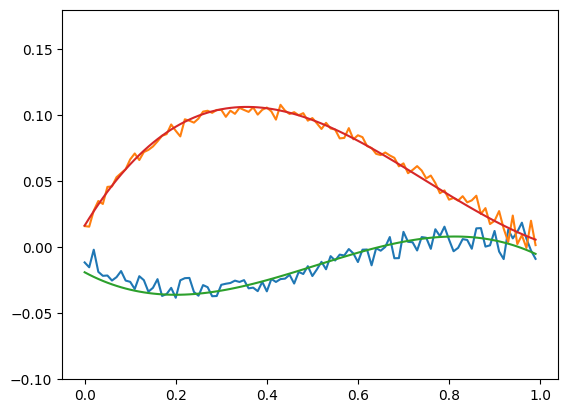

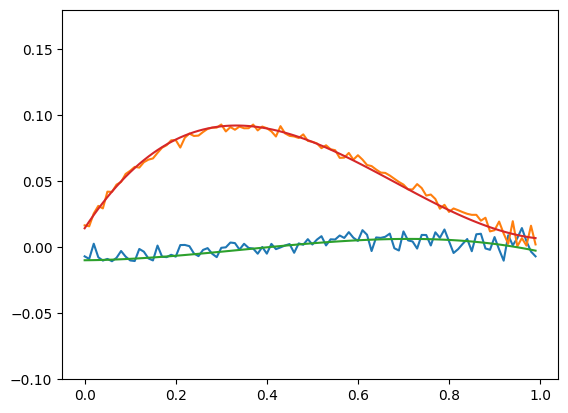

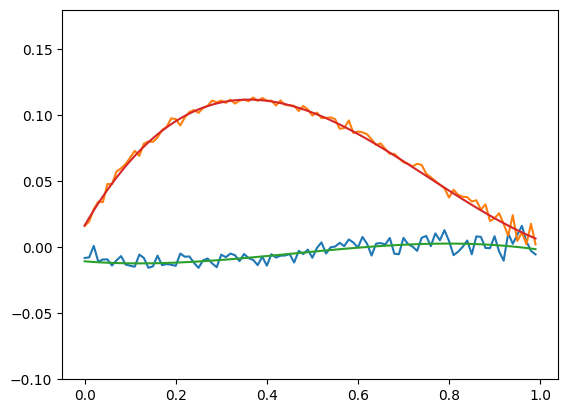

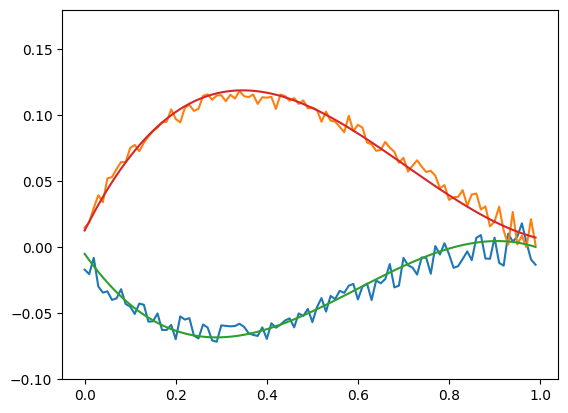

VAL Epoch [370/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.117188, disloss: 27.630323, noise: 0.022237


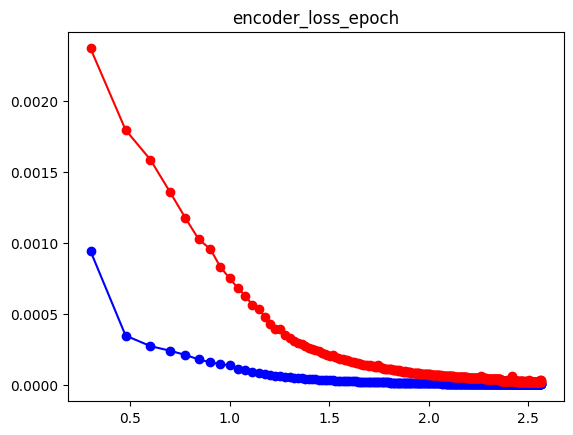

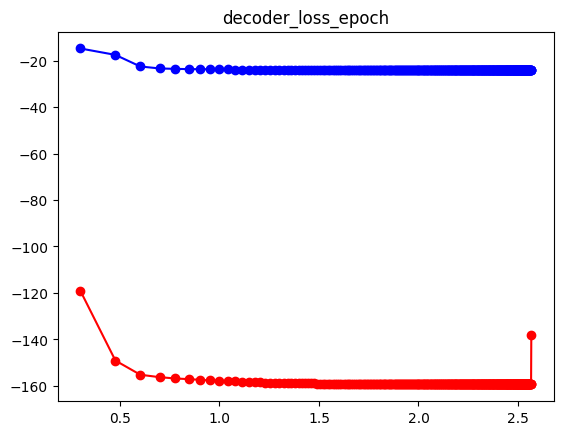

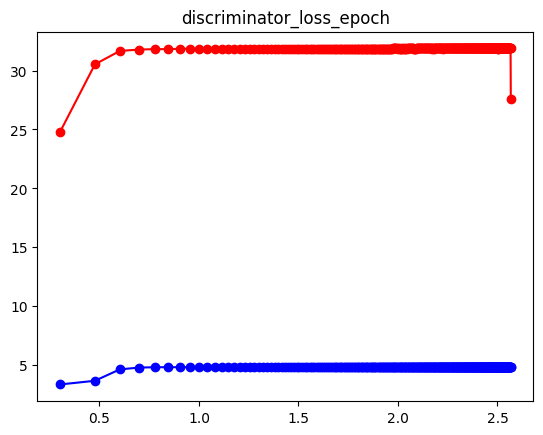

    Epoch [371/5000], Batch [0/86], lr: 0.00015, encloss: 1.8e-05, decloss: -138.1185, disloss: 27.630775, noise: 0.036453
VAL Epoch [371/5000], Batch [0/13], lr: 0.00015, encloss: 1.9e-05, decloss: -138.115753, disloss: 27.630655, noise: 0.01915
    Epoch [372/5000], Batch [0/86], lr: 0.00015, encloss: 1.9e-05, decloss: -138.115829, disloss: 27.63063, noise: 0.024649
VAL Epoch [372/5000], Batch [0/13], lr: 0.00015, encloss: 1.8e-05, decloss: -138.117828, disloss: 27.630566, noise: 0.034068
    Epoch [373/5000], Batch [0/86], lr: 0.00015, encloss: 1.7e-05, decloss: -138.117584, disloss: 27.63026, noise: 0.019189
VAL Epoch [373/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.120056, disloss: 27.630577, noise: 0.020668
    Epoch [374/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.119156, disloss: 27.630363, noise: 0.025045
VAL Epoch [374/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.12088, disloss: 27.630657, noise: 0.023034
    Ep

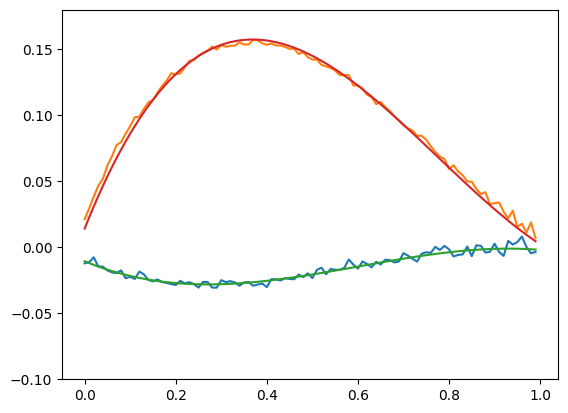

    Epoch [380/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.119766, disloss: 27.630314, noise: 0.021806


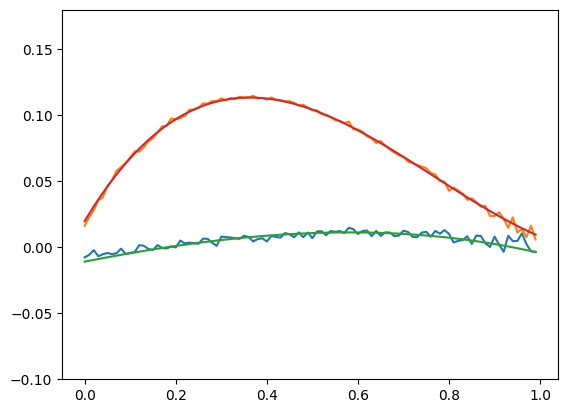

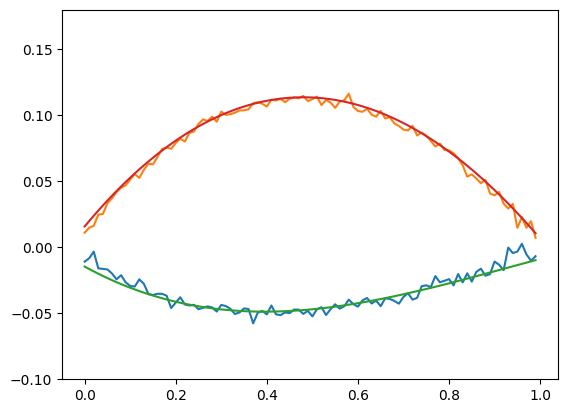

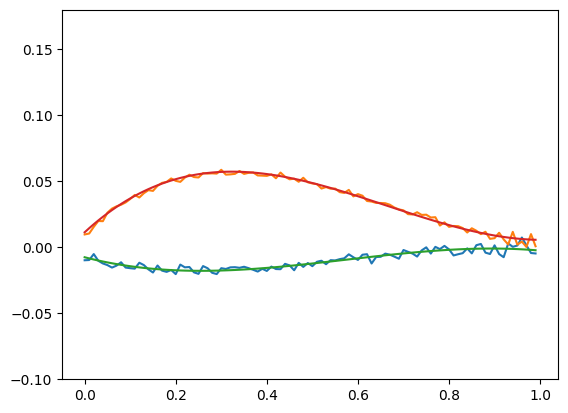

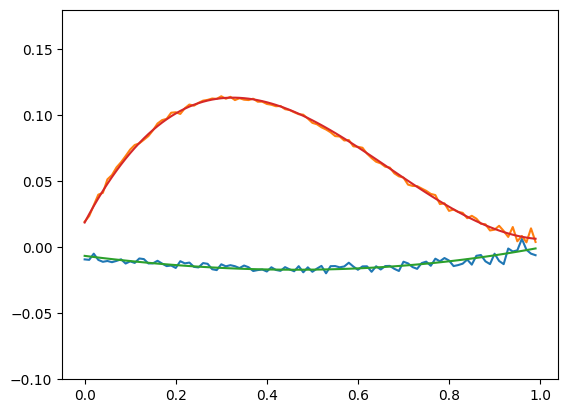

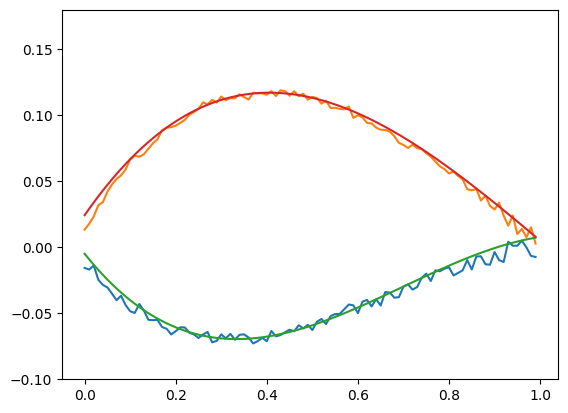

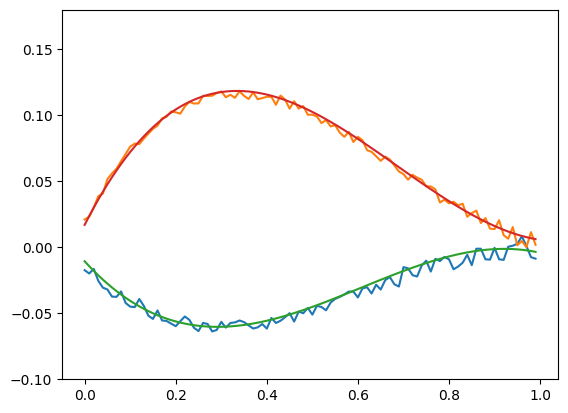

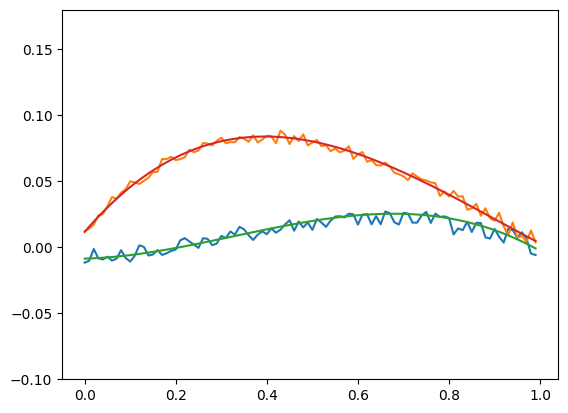

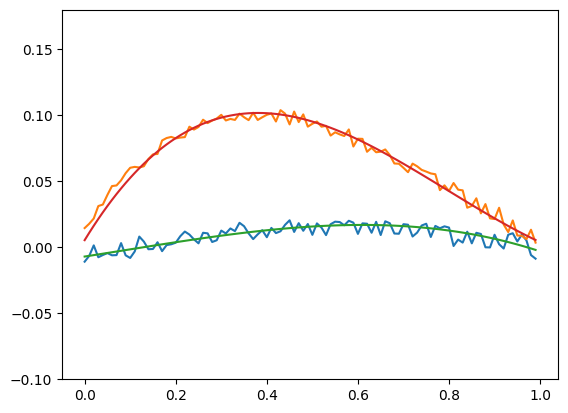

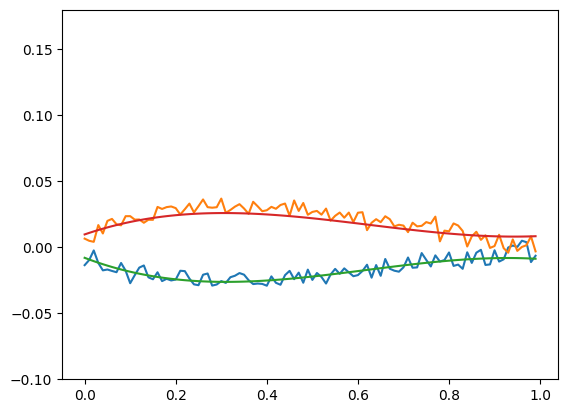

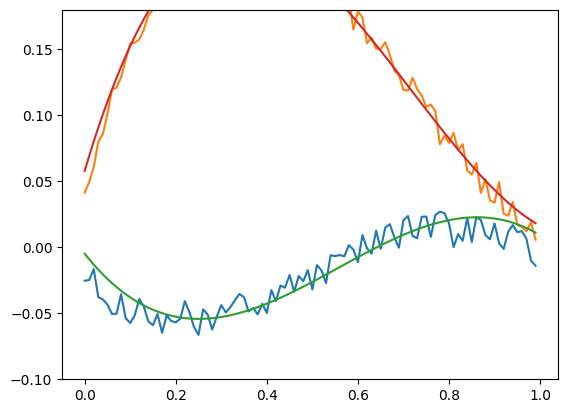

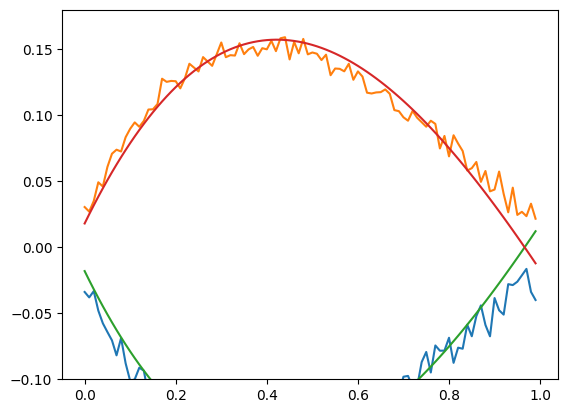

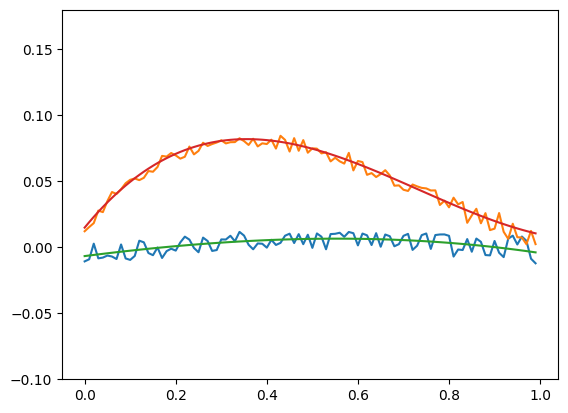

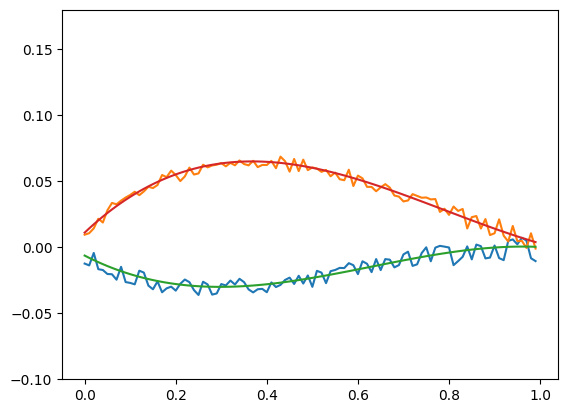

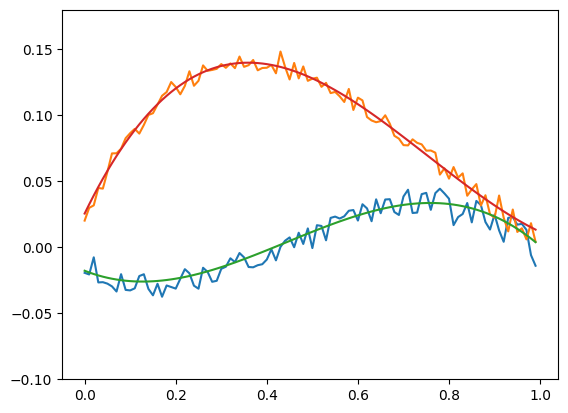

VAL Epoch [380/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.11908, disloss: 27.630287, noise: 0.041246


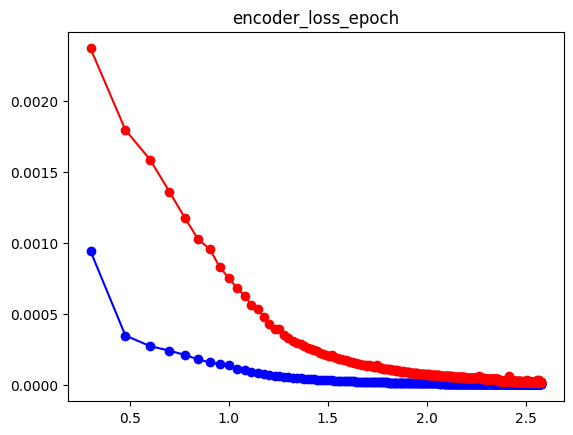

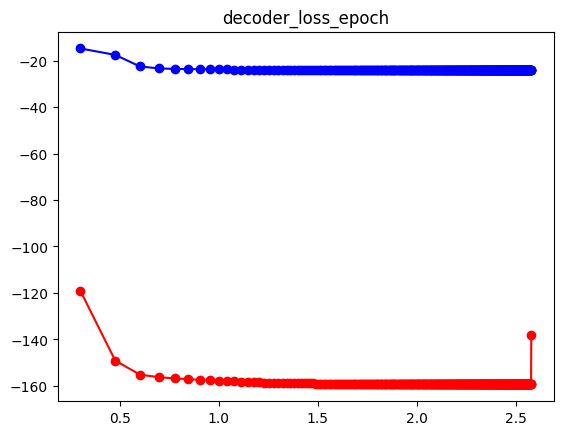

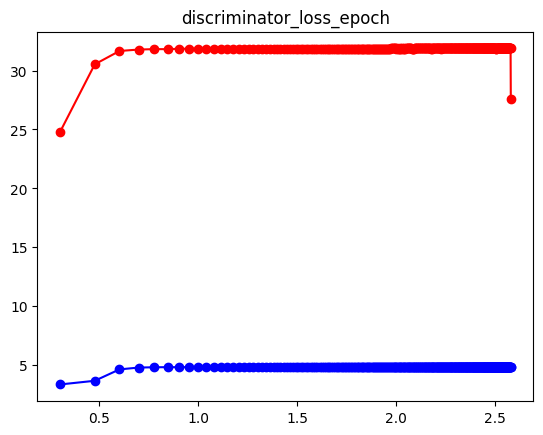

    Epoch [381/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.119186, disloss: 27.630203, noise: 0.025458
VAL Epoch [381/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.118652, disloss: 27.63056, noise: 0.020622
    Epoch [382/5000], Batch [0/86], lr: 0.00015, encloss: 1.7e-05, decloss: -138.117706, disloss: 27.630413, noise: 0.035464
VAL Epoch [382/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.122269, disloss: 27.630789, noise: 0.027127
    Epoch [383/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.121933, disloss: 27.630718, noise: 0.018282
VAL Epoch [383/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.121811, disloss: 27.630785, noise: 0.026301
    Epoch [384/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.121765, disloss: 27.630781, noise: 0.030399
VAL Epoch [384/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.118896, disloss: 27.630756, noise: 0.020245
 

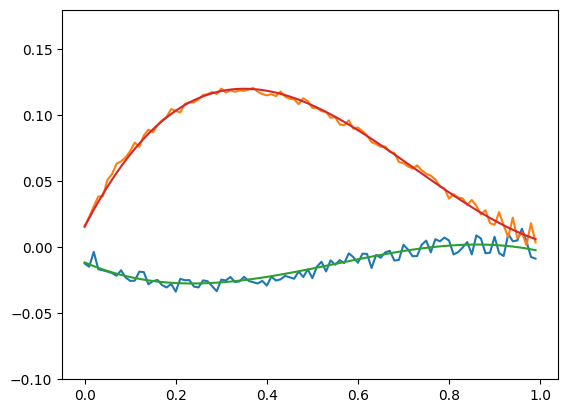

    Epoch [390/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.121872, disloss: 27.630825, noise: 0.020868


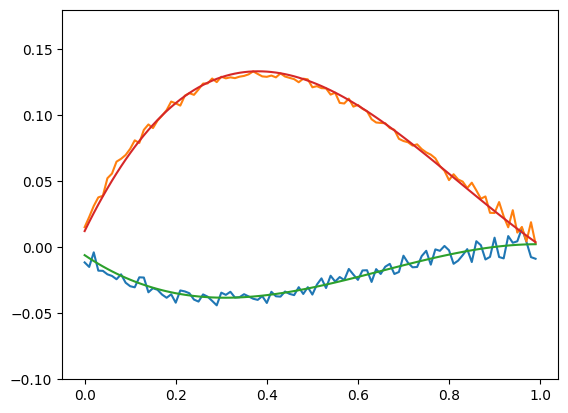

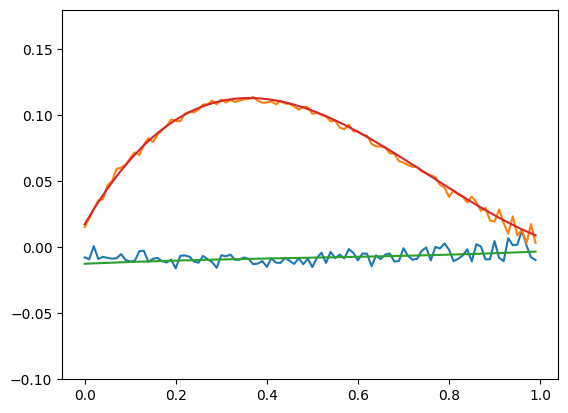

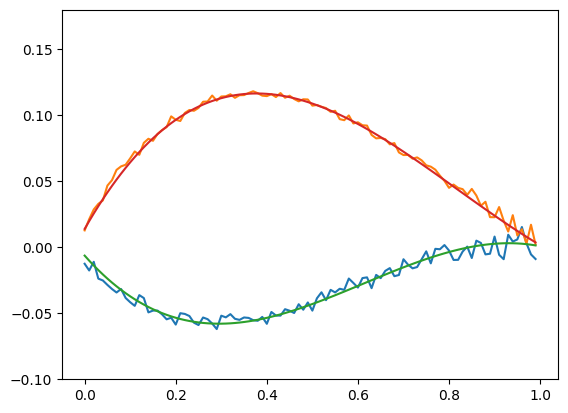

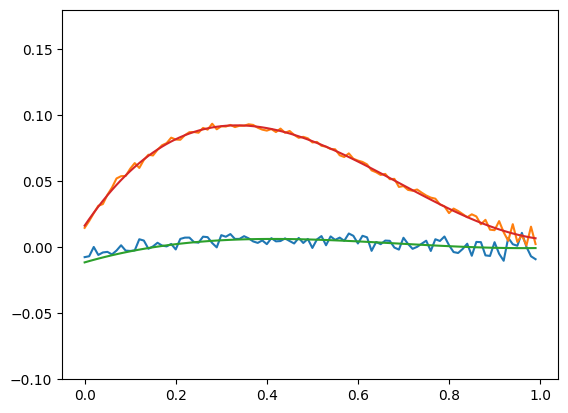

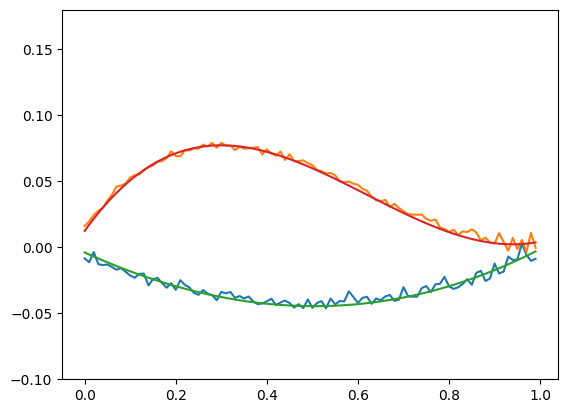

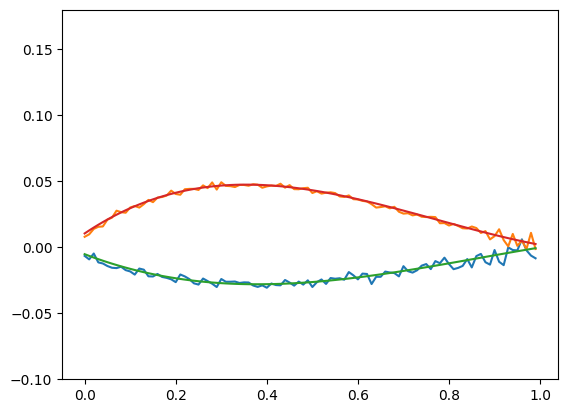

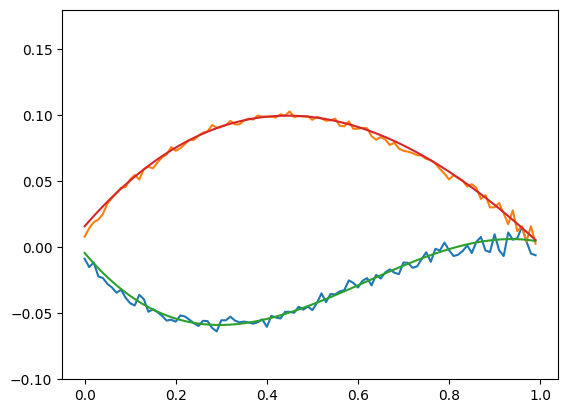

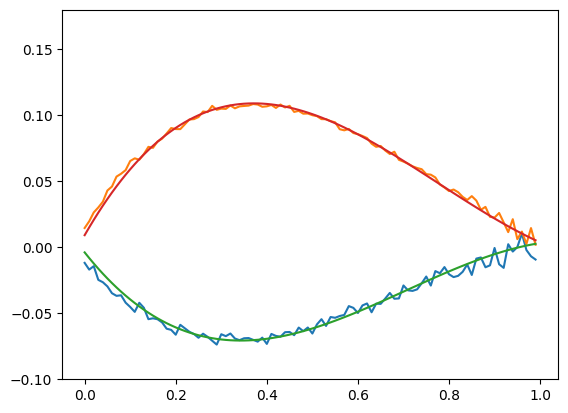

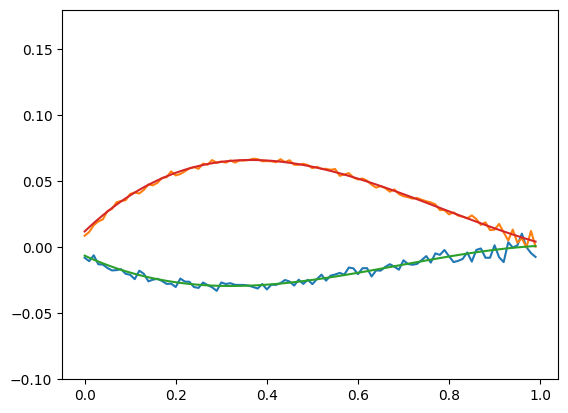

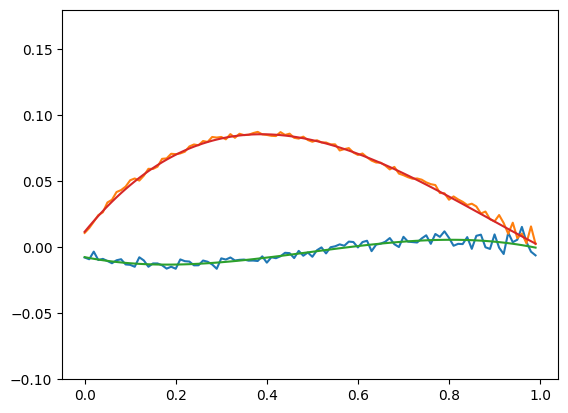

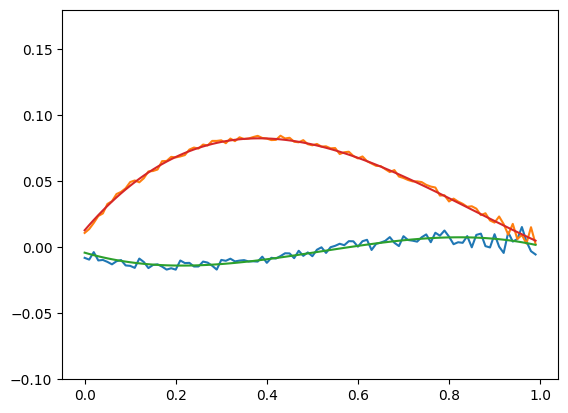

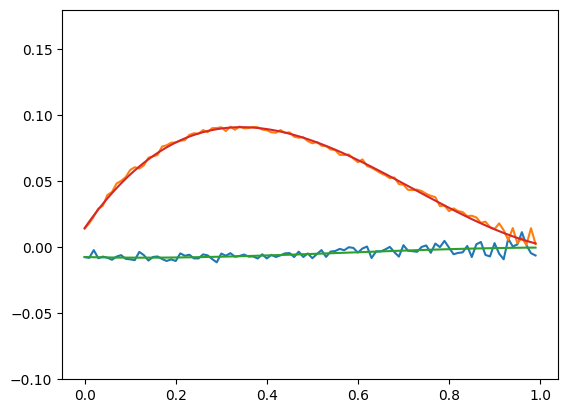

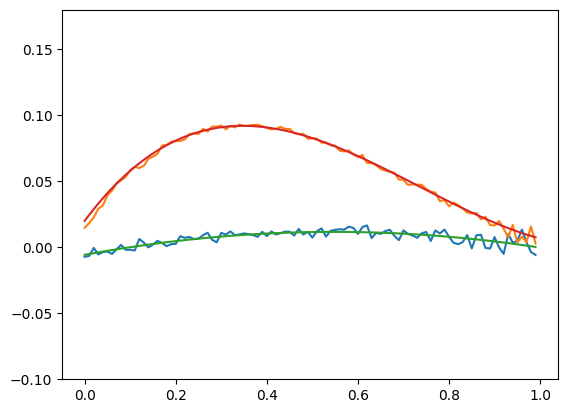

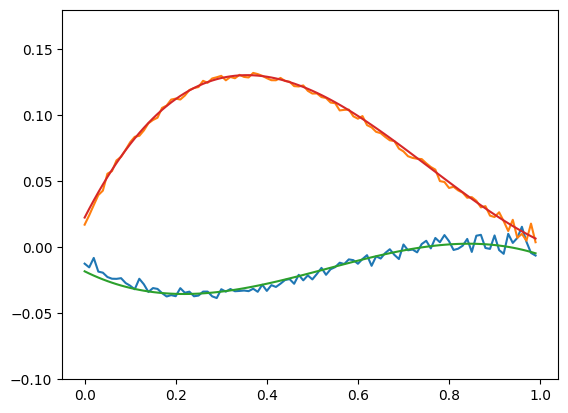

VAL Epoch [390/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.122391, disloss: 27.630829, noise: 0.041536


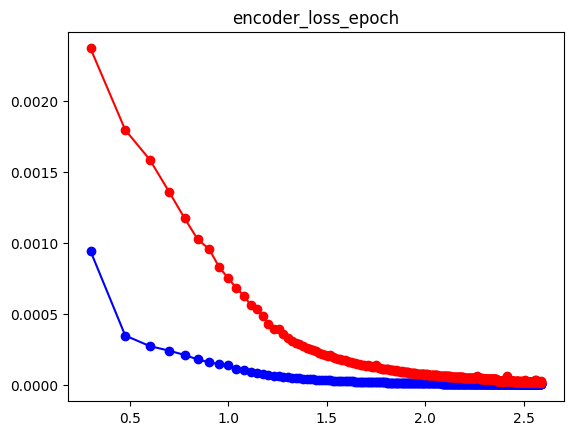

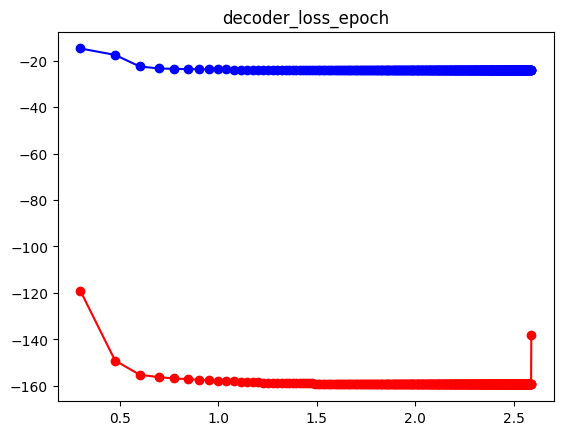

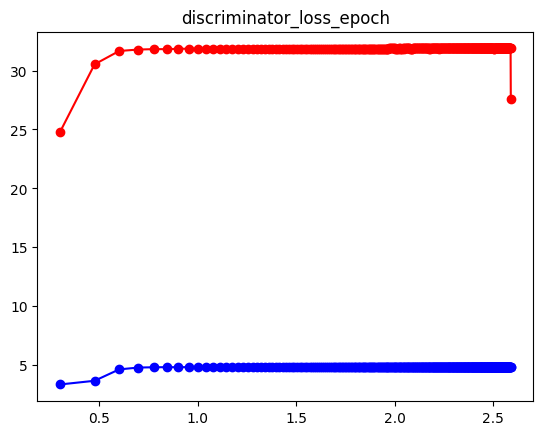

    Epoch [391/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.123032, disloss: 27.630816, noise: 0.02162
VAL Epoch [391/5000], Batch [0/13], lr: 0.00015, encloss: 1.5e-05, decloss: -138.120468, disloss: 27.630274, noise: 0.037918
    Epoch [392/5000], Batch [0/86], lr: 0.00015, encloss: 1.5e-05, decloss: -138.121368, disloss: 27.630411, noise: 0.022873
VAL Epoch [392/5000], Batch [0/13], lr: 0.00015, encloss: 1.5e-05, decloss: -138.123062, disloss: 27.630804, noise: 0.033821
    Epoch [393/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.122879, disloss: 27.63081, noise: 0.037411
VAL Epoch [393/5000], Batch [0/13], lr: 0.00015, encloss: 1.5e-05, decloss: -138.122498, disloss: 27.630663, noise: 0.023237
    Epoch [394/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.12146, disloss: 27.630514, noise: 0.028525
VAL Epoch [394/5000], Batch [0/13], lr: 0.00015, encloss: 3e-05, decloss: -138.093979, disloss: 27.630949, noise: 0.02526
    Ep

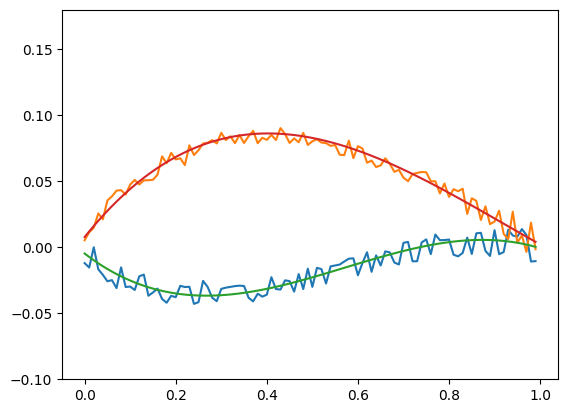

    Epoch [400/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.118576, disloss: 27.630291, noise: 0.02408


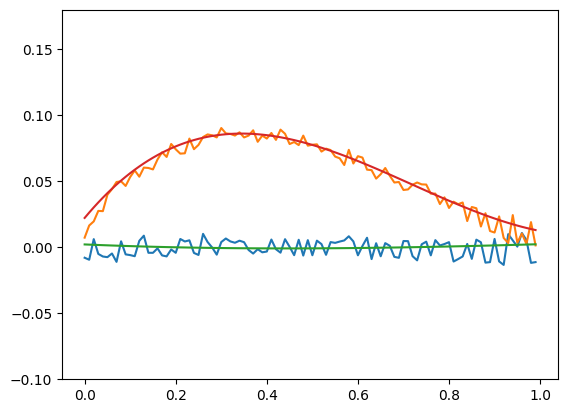

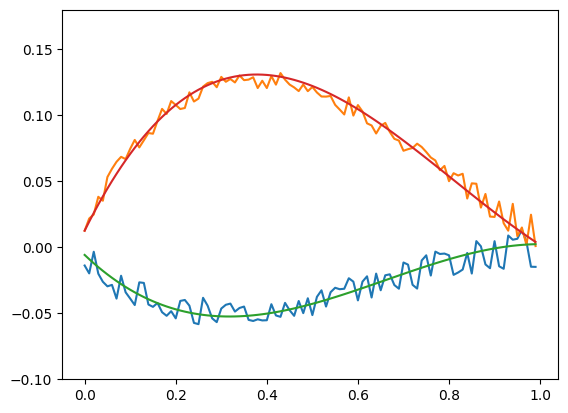

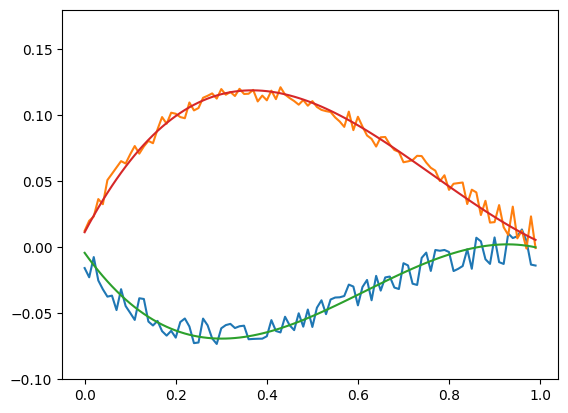

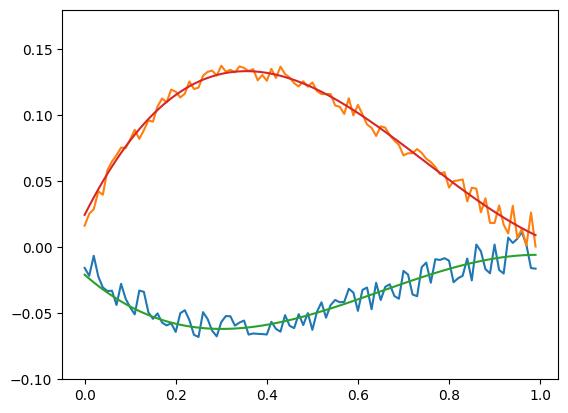

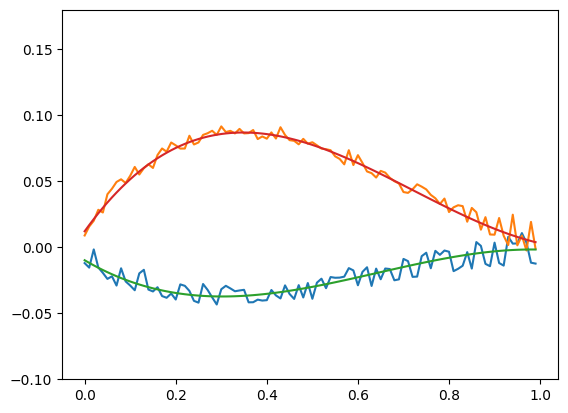

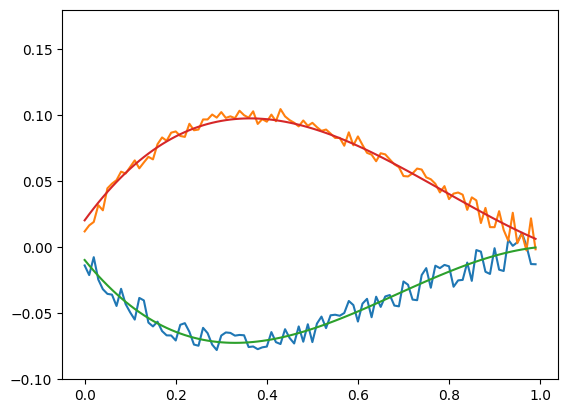

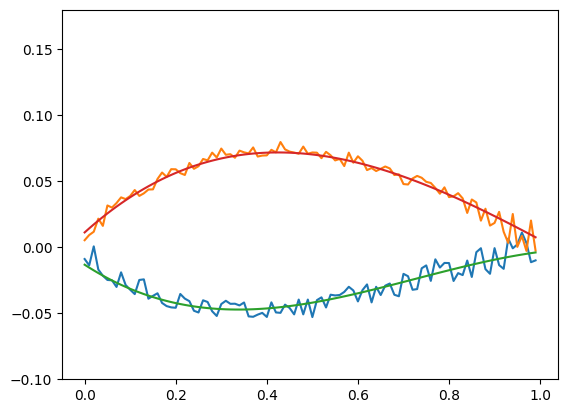

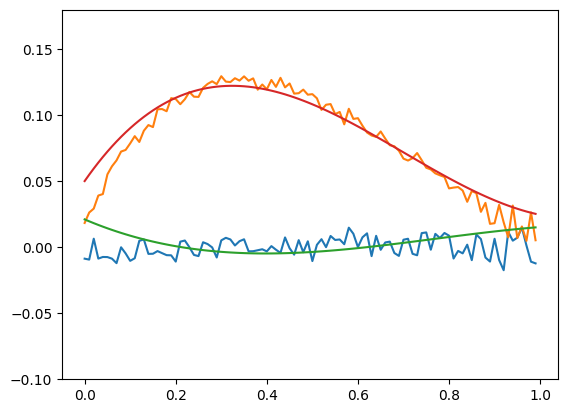

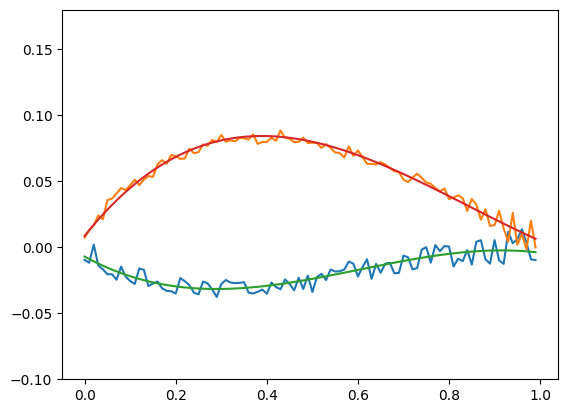

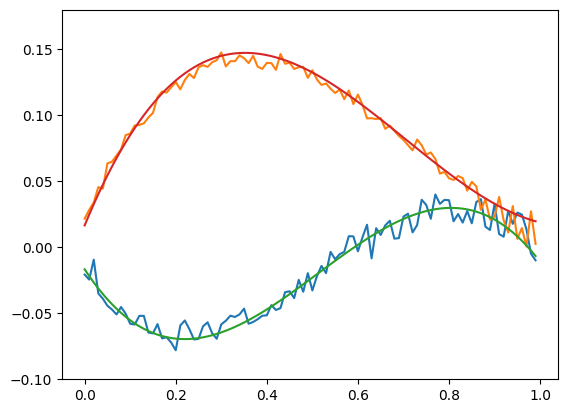

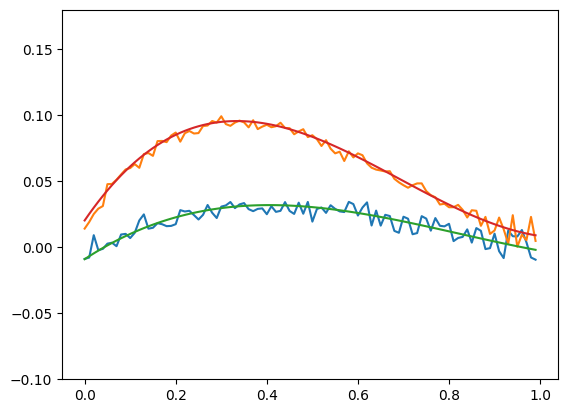

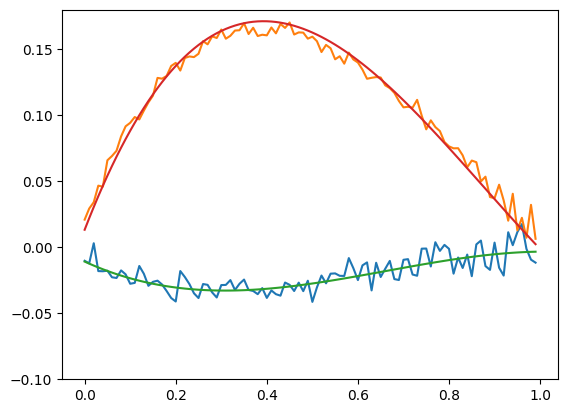

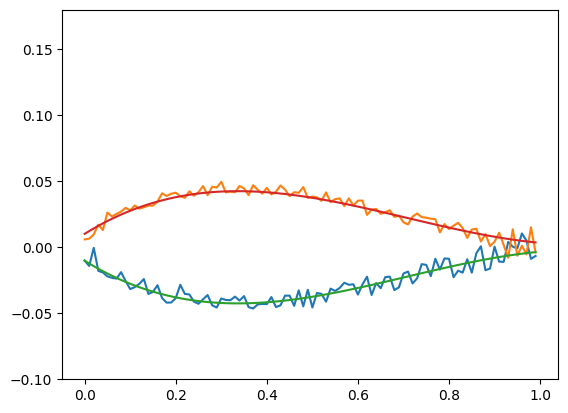

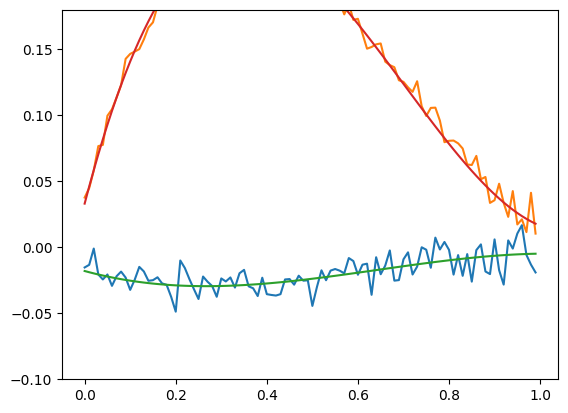

VAL Epoch [400/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.119781, disloss: 27.630417, noise: 0.027828


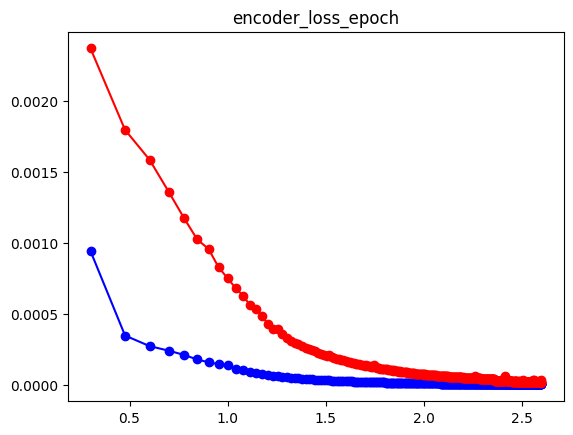

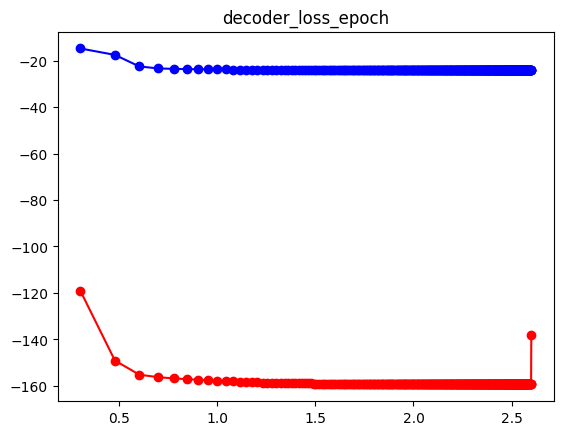

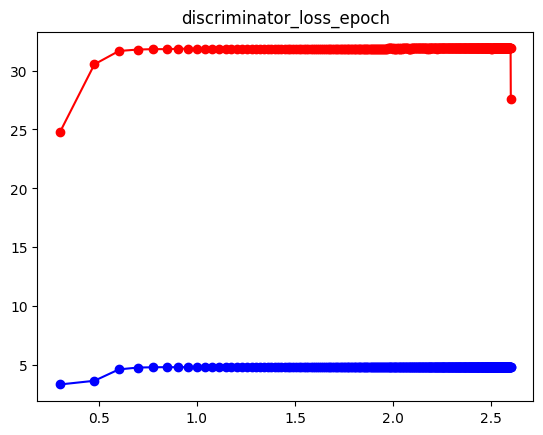

    Epoch [401/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.120132, disloss: 27.630419, noise: 0.026622
VAL Epoch [401/5000], Batch [0/13], lr: 0.00015, encloss: 1.5e-05, decloss: -138.123566, disloss: 27.630814, noise: 0.018843
    Epoch [402/5000], Batch [0/86], lr: 0.00015, encloss: 1.5e-05, decloss: -138.123413, disloss: 27.630819, noise: 0.019611
VAL Epoch [402/5000], Batch [0/13], lr: 0.00015, encloss: 1.5e-05, decloss: -138.122986, disloss: 27.630753, noise: 0.028445
    Epoch [403/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.12236, disloss: 27.630754, noise: 0.024856
VAL Epoch [403/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.122833, disloss: 27.63077, noise: 0.036664
    Epoch [404/5000], Batch [0/86], lr: 0.00015, encloss: 1.5e-05, decloss: -138.12323, disloss: 27.63072, noise: 0.02113
VAL Epoch [404/5000], Batch [0/13], lr: 0.00015, encloss: 1.5e-05, decloss: -138.122559, disloss: 27.630619, noise: 0.026978
    E

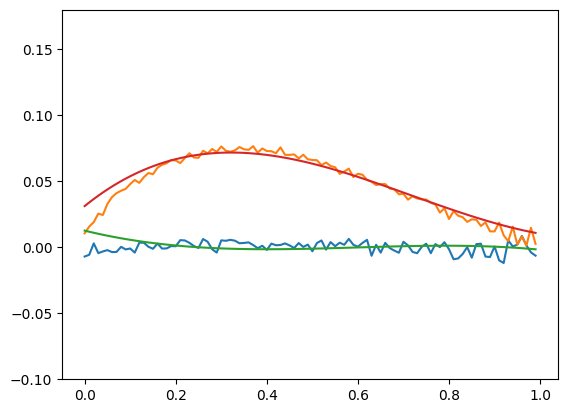

    Epoch [410/5000], Batch [0/86], lr: 0.00015, encloss: 1.5e-05, decloss: -138.121933, disloss: 27.630531, noise: 0.031622


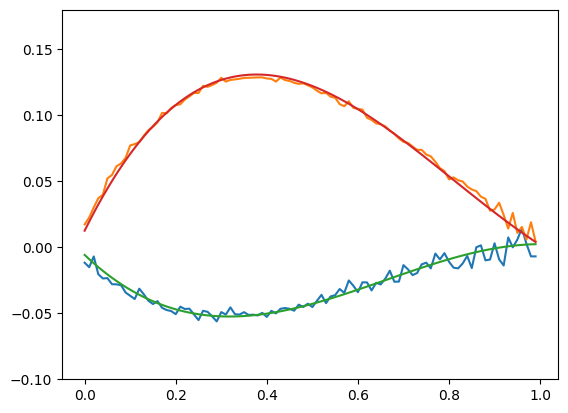

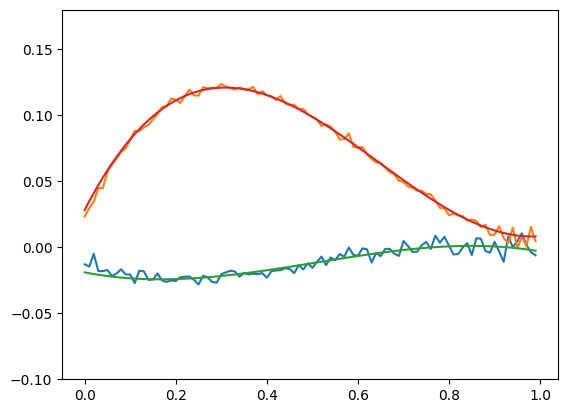

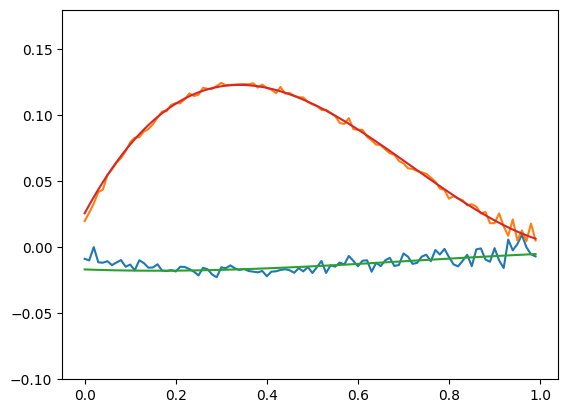

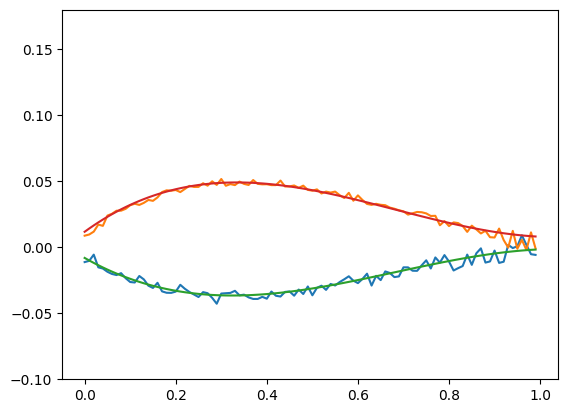

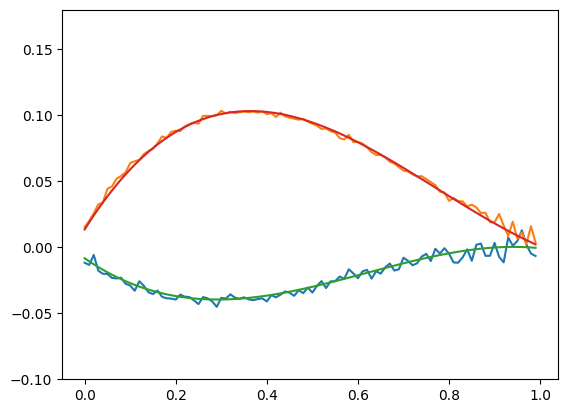

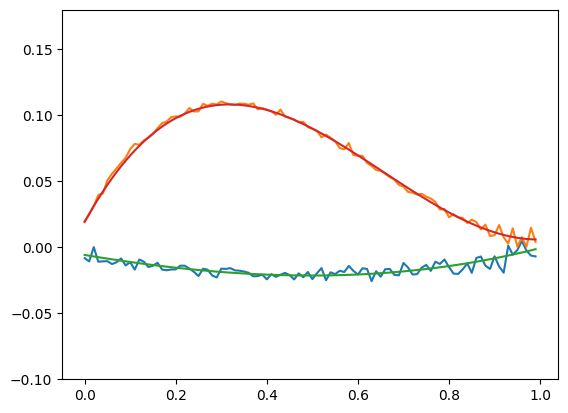

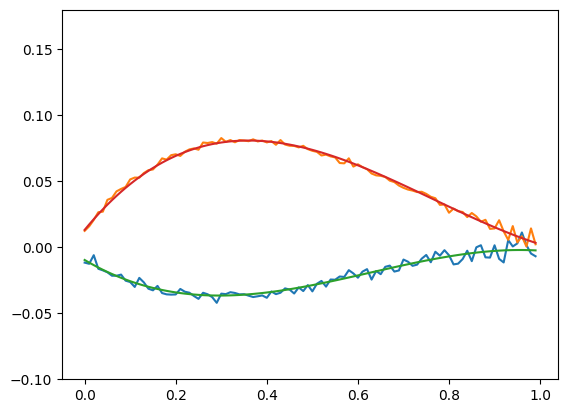

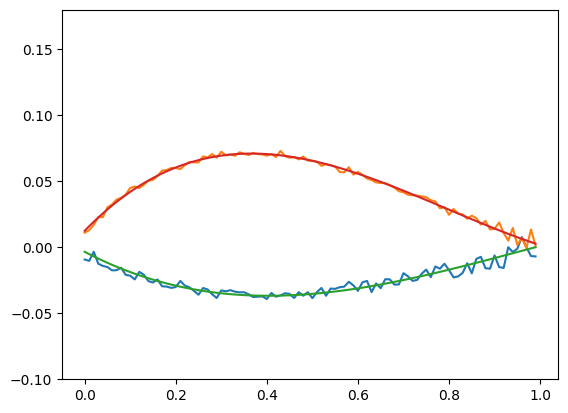

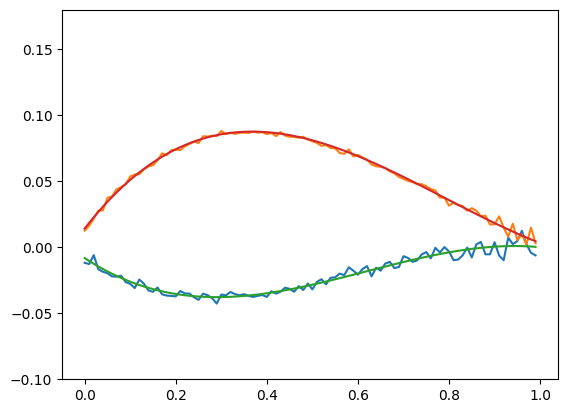

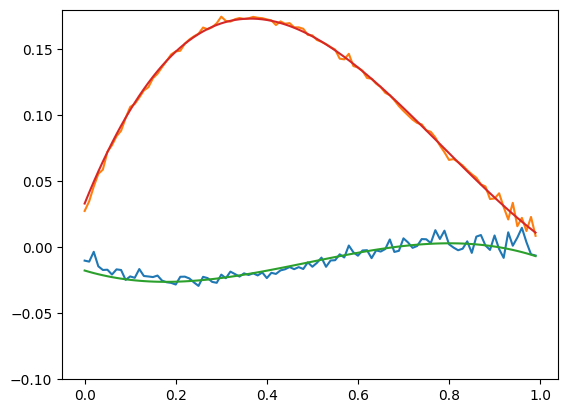

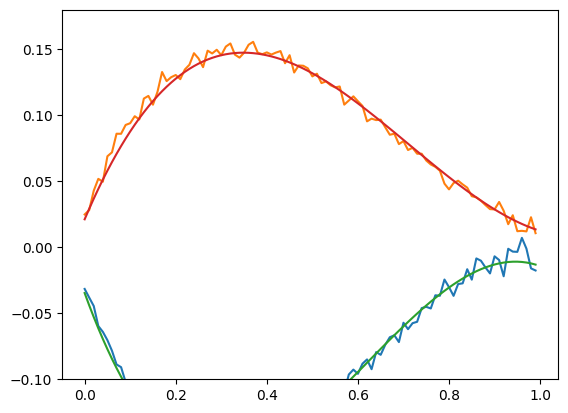

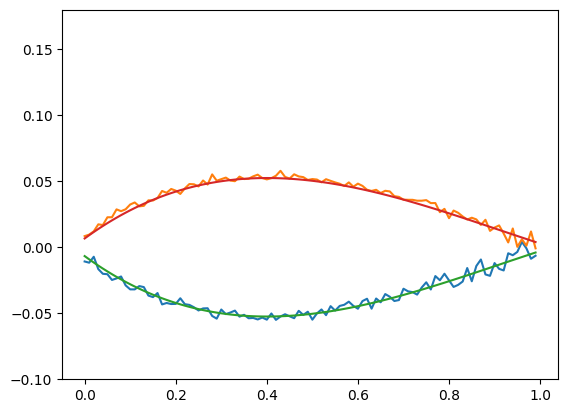

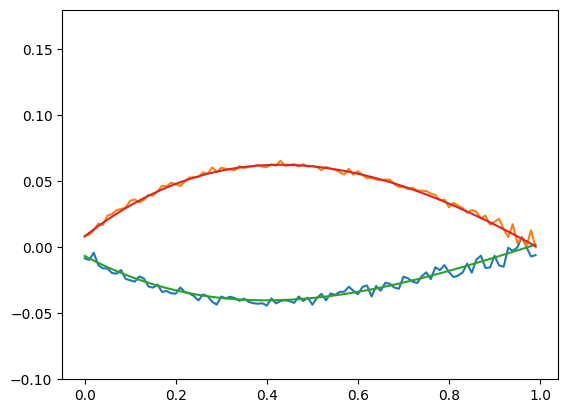

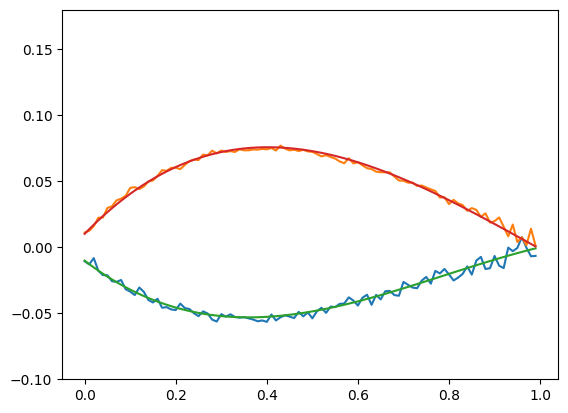

VAL Epoch [410/5000], Batch [0/13], lr: 0.00015, encloss: 3.7e-05, decloss: -138.081024, disloss: 27.631023, noise: 0.027455


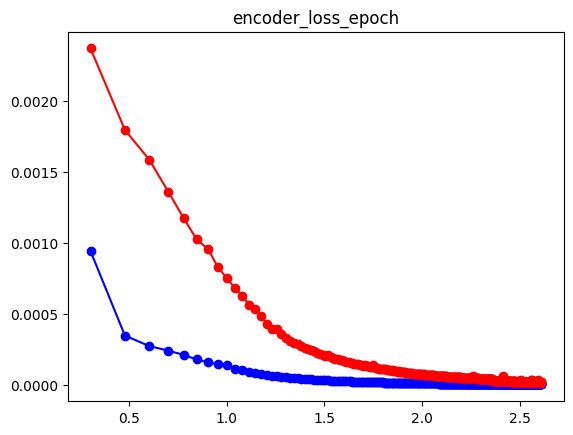

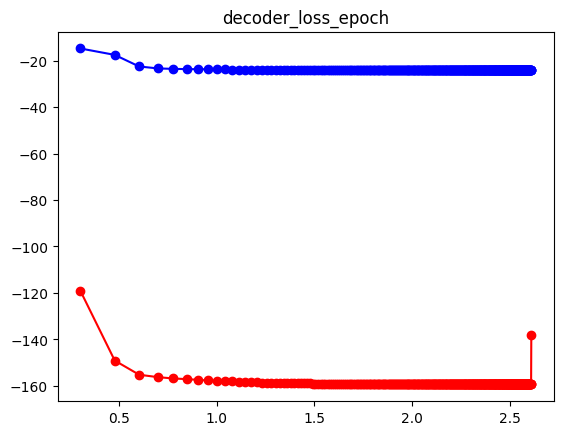

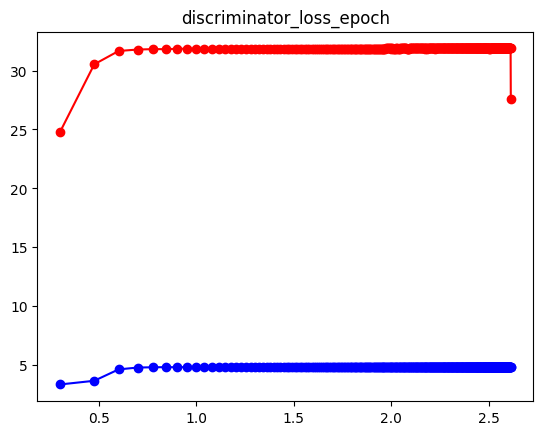

    Epoch [411/5000], Batch [0/86], lr: 0.00015, encloss: 3.4e-05, decloss: -138.086395, disloss: 27.631023, noise: 0.023342
VAL Epoch [411/5000], Batch [0/13], lr: 0.00015, encloss: 2.1e-05, decloss: -138.113739, disloss: 27.631012, noise: 0.024522
    Epoch [412/5000], Batch [0/86], lr: 0.00015, encloss: 2e-05, decloss: -138.114716, disloss: 27.631008, noise: 0.022195
VAL Epoch [412/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.12056, disloss: 27.630707, noise: 0.026147
    Epoch [413/5000], Batch [0/86], lr: 0.00015, encloss: 1.7e-05, decloss: -138.120438, disloss: 27.630699, noise: 0.030851
VAL Epoch [413/5000], Batch [0/13], lr: 0.00015, encloss: 1.6e-05, decloss: -138.120758, disloss: 27.630527, noise: 0.025844
    Epoch [414/5000], Batch [0/86], lr: 0.00015, encloss: 1.6e-05, decloss: -138.1203, disloss: 27.63036, noise: 0.023774
VAL Epoch [414/5000], Batch [0/13], lr: 0.00015, encloss: 1.7e-05, decloss: -138.117508, disloss: 27.63032, noise: 0.018082
    Epo

KeyboardInterrupt: 

In [ ]:
make_step = True
for epoch in range(cur_epoch, num_epochs):  # train loop
    for batch_idx, batch in enumerate(train_loader):
        '''
        if epoch >= stop_slowing_epoch:
            lr = lr_end
        else:
            lr = lr_start - (epoch * (lr_start - lr_end) / stop_slowing_epoch)
        for param_group in encoder_optimizer.param_groups:
                param_group['lr'] = lr
        for param_group in decoder_optimizer.param_groups:
                param_group['lr'] = lr
        for param_group in discriminator_optimizer.param_groups:
                param_group['lr'] = lr
        '''

        z, z_mu, z_logvar, x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last = vaegan(batch)

        encoder_loss = encoderloss(x, x_recon, y_before_last, y_fake_before_last, z_mu, z_logvar)
        decoder_loss = decoderloss(x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last, z_mu, z_logvar)
        discriminator_loss = discriminatorloss(y, y_recon, y_fake)

        encoder_loss_logs.append(float(encoder_loss))
        decoder_loss_logs.append(float(decoder_loss))
        discriminator_loss_logs.append(float(discriminator_loss))
        completed_epochs = epoch
        '''
        #anomaly loss catcher
        if (abs(float(encoder_loss)) > 2 or abs(float(decoder_loss)) > 2 or abs(float(discriminator_loss)) > 0.5) and epoch > cur_epoch + 30:
            print('loss boom')
            continue
        '''
        '''
        vaegan.zero_grad()
        encoder_loss.backward(retain_graph = True, inputs=list(vaegan.encoder.parameters()))
        encoder_optimizer.step()

        decoder_loss.backward(retain_graph = True, inputs=list(vaegan.decoder.parameters()))
        decoder_optimizer.step()

        discriminator_loss.backward(retain_graph = False, inputs=list(vaegan.discriminator.parameters()))
        discriminator_optimizer.step()
        '''

        vaegan.zero_grad()
        encoder_loss.backward(retain_graph = True)
        decoder_loss.backward(retain_graph = True)
        discriminator_loss.backward(retain_graph = False)

        encoder_optimizer.step()
        decoder_optimizer.step()
        if make_step:
            discriminator_optimizer.step()



        if epoch % 10 == 0 and epoch > 1 and batch_idx < 15:
            outputter(x[0], x_recon[0], 200)

        if batch_idx % 100 == 0:
            noise = noiseloss(x_recon)
            print(f'    Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], lr: {lr}, ' \
                  f'encloss: {round(float(torch.mean(encoder_loss)), 6)}, decloss: {round(float(torch.mean(decoder_loss)), 6)}, ' \
                  f'disloss: {round(float(torch.mean(discriminator_loss)), 6)}, noise: {round(float(torch.mean(noise)), 6)}')

    for batch_idx, batch in enumerate(val_loader):

        z, z_mu, z_logvar, x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last = vaegan(batch)

        encoder_loss = encoderloss(x, x_recon, y_before_last, y_fake_before_last, z_mu, z_logvar)
        decoder_loss = decoderloss(x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last, z_mu, z_logvar)
        discriminator_loss = discriminatorloss(y, y_recon, y_fake)

        if float(discriminator_loss) > 0.2:
            make_step = True
        else:
            make_step = False

        encoder_loss_logs_val.append(float(encoder_loss))
        decoder_loss_logs_val.append(float(decoder_loss))
        discriminator_loss_logs_val.append(float(discriminator_loss))
        completed_epochs_val = epoch

        if batch_idx % 100 == 0:
            noise = noiseloss(x_recon)
            print(f'VAL Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(val_loader)}], lr: {lr}, ' \
                  f'encloss: {round(float(torch.mean(encoder_loss)), 6)}, decloss: {round(float(torch.mean(decoder_loss)), 6)}, ' \
                  f'disloss: {round(float(torch.mean(discriminator_loss)), 6)}, noise: {round(float(torch.mean(noise)), 6)}')

    if epoch % 10 == 0 and epoch > 1:
        plot_loss_vs_epoch(encoder_loss_logs, encoder_loss_logs_val, completed_epochs, 2, 'encoder_loss_epoch')
        plot_loss_vs_epoch(decoder_loss_logs, decoder_loss_logs_val, completed_epochs, 2, 'decoder_loss_epoch')
        plot_loss_vs_epoch(discriminator_loss_logs, discriminator_loss_logs_val, completed_epochs, 2, 'discriminator_loss_epoch')
    '''
    if (epoch - 1) % 200 == 0:
        log_path = str(epoch)
        torch.save(vaegan.state_dict(), 'drive/MyDrive/IITP/vaegan/autosaved/vaegan_' + log_path + '_adapted_loss.pth')
        torch.save(encoder.state_dict(), 'drive/MyDrive/IITP/vaegan/autosaved/encoder_' + log_path + '_adapted_loss.pth')
        torch.save(decoder.state_dict(), 'drive/MyDrive/IITP/vaegan/autosaved/decoder_' + log_path + '_adapted_loss.pth')
        torch.save(discriminator.state_dict(), 'drive/MyDrive/IITP/vaegan/autosaved/discriminator_' + log_path + '_adapted_loss.pth')
    '''

## Plots

In [ ]:
plot_loss_vs_batch(encoder_loss_logs, 'encoder_loss')
plot_loss_vs_batch(decoder_loss_logs, 'decoder_loss')
plot_loss_vs_batch(discriminator_loss_logs, 'discriminator_loss')

NameError: name 'plot_loss_vs_batch' is not defined

In [ ]:
plot_loss_vs_epoch(encoder_loss_logs, encoder_loss_logs_val, completed_epochs, 1, 'encoder_loss_epoch')
plot_loss_vs_epoch(decoder_loss_logs, decoder_loss_logs_val, completed_epochs, 1, 'decoder_loss_epoch')
plot_loss_vs_epoch(discriminator_loss_logs, discriminator_loss_logs_val, completed_epochs, 1, 'discriminator_loss_epoch')

NameError: name 'encoder_loss_logs' is not defined

## Saving

In [ ]:
save_as = 'revised_back_epochs_419dfg'
torch.save(vaegan.state_dict(), 'drive/MyDrive/IITP/noise_vaegan/vaegan_' + save_as + '.pth')
torch.save(encoder.state_dict(), 'drive/MyDrive/IITP/noise_vaegan/encoder_' + save_as + '.pth')
torch.save(decoder.state_dict(), 'drive/MyDrive/IITP/noise_vaegan/decoder_' + save_as + '.pth')
torch.save(discriminator.state_dict(), 'drive/MyDrive/IITP/noise_vaegan/discriminator_' + save_as + '.pth')

## Working Network

In [ ]:
def latent_inputter(x):
    z_mu = torch.tensor([-3.9279e-06, -1.1558e-06, -3.7402e-06, -2.6252e-07, -3.0445e-06,
         -5.4166e-06, -4.3037e-06, -1.5347e-05, -4.6874e-06,  1.6508e-07,
          2.4736e-06, -3.4920e-06, -2.7556e-06, -1.3523e-06,  2.0113e-06,
         -2.7120e-06,  1.7814e-05, -1.7572e-05, -2.9858e-06,  3.3714e-06,
          5.7868e-06, -3.5106e-06, -2.0580e-05, -3.2503e-06,  6.0263e-06,
          1.3170e-06,  3.0622e-06, -1.2454e-06, -4.7125e-06,  2.2128e-06,
         -1.9465e-05,  1.2426e-06])
    z_logvar = torch.tensor([ 2.3916e-06, -6.0825e-06,  1.0481e-05,  6.7800e-06, -6.8778e-06,
          1.7658e-05,  1.1474e-05,  6.0797e-06, -4.9099e-06,  6.7204e-06,
         -2.5854e-06,  7.6368e-06, -1.0477e-05,  2.7940e-07, -2.2622e-06,
          7.6592e-06, -1.4499e-05, -9.6671e-06,  4.9584e-06, -8.8662e-07,
          3.6098e-06, -2.0668e-05, -8.1807e-06,  6.0573e-06,  2.7604e-06,
         -8.4899e-06, -3.7774e-06,  9.7454e-06, -7.7486e-07,  2.0679e-05,
          4.9053e-06,  8.1956e-08])
    return z_mu, z_logvar

In [ ]:
load_as = 'low_lr_00001_noiseloss_0001_epochs_'
checkpoint = torch.load('drive/MyDrive/IITP/noise_vaegan/encoder_' + load_as + '.pth', map_location=torch.device('cpu'))
loaded_encoder = Encoder()
loaded_encoder.load_state_dict(torch.load('drive/MyDrive/IITP/noise_vaegan/encoder_' + load_as + '.pth'))

checkpoint = torch.load('drive/MyDrive/IITP/noise_vaegan/decoder_' + load_as + '.pth', map_location=torch.device('cpu'))
loaded_decoder = Decoder()
loaded_decoder.load_state_dict(torch.load('drive/MyDrive/IITP/noise_vaegan/decoder_' + load_as + '.pth'))

checkpoint = torch.load('drive/MyDrive/IITP/noise_vaegan/discriminator_' + load_as + '.pth', map_location=torch.device('cpu'))
loaded_discriminator = Discriminator()
loaded_discriminator.load_state_dict(torch.load('drive/MyDrive/IITP/noise_vaegan/discriminator_' + load_as + '.pth'))

checkpoint = torch.load('drive/MyDrive/IITP/noise_vaegan/vaegan_' + load_as + '.pth', map_location=torch.device('cpu'))
loaded_vaegan = VAEGAN(loaded_encoder, loaded_decoder, loaded_discriminator)
loaded_vaegan.load_state_dict(torch.load('drive/MyDrive/IITP/noise_vaegan/vaegan_' + load_as + '.pth'))

loaded_encoder.eval()
loaded_decoder.eval()
loaded_discriminator.eval()
loaded_vaegan.eval()

VAEGAN(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=200, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=32, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
    )
    (fc_mean): Linear(in_features=32, out_features=32, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=256, out_features=200, bias=True)
      (5): Tanh()
    )
  )
  (discriminator): Discriminator(
    (discriminator): Sequential(
      (0): Linear(in_features=200, out_features=256, bias=True)
    

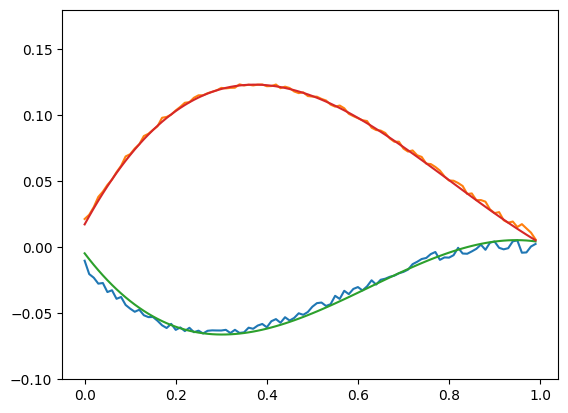

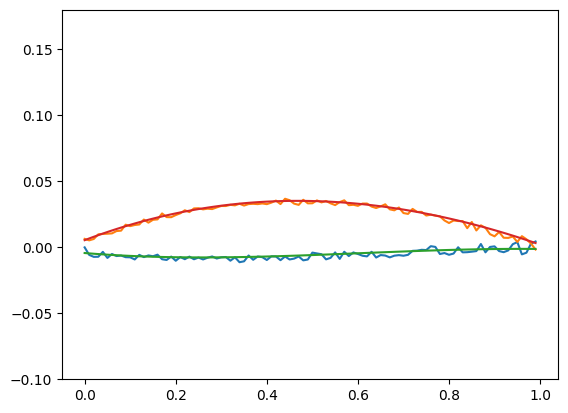

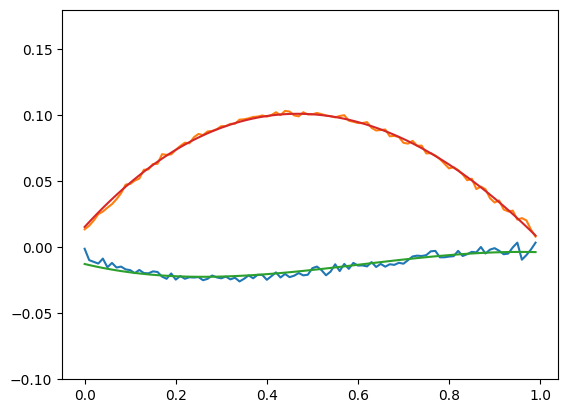

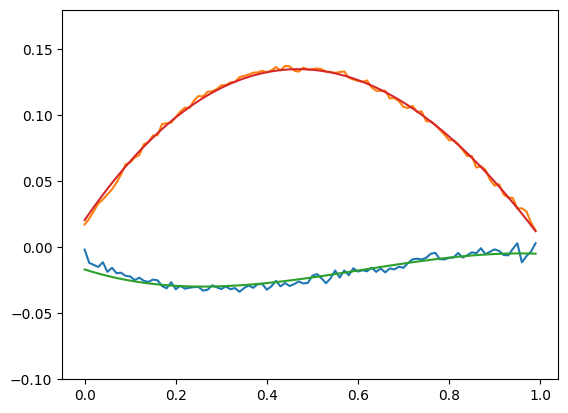

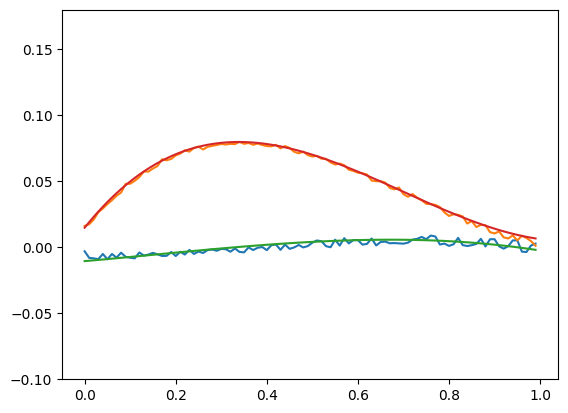

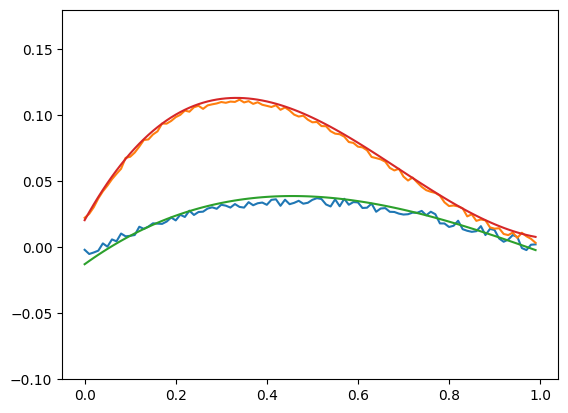

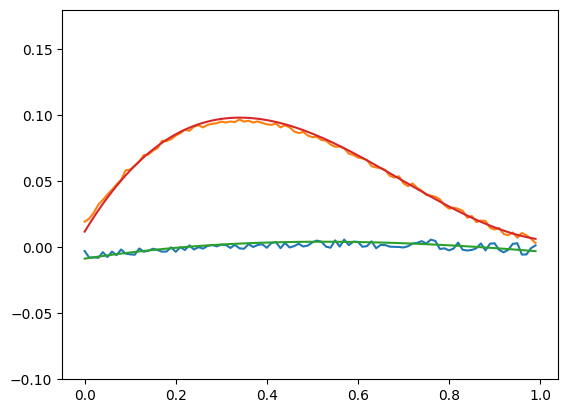

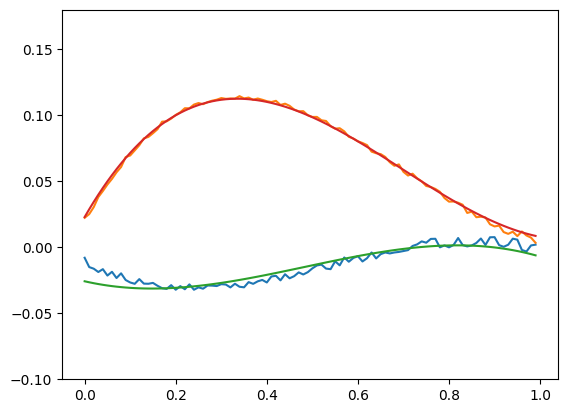

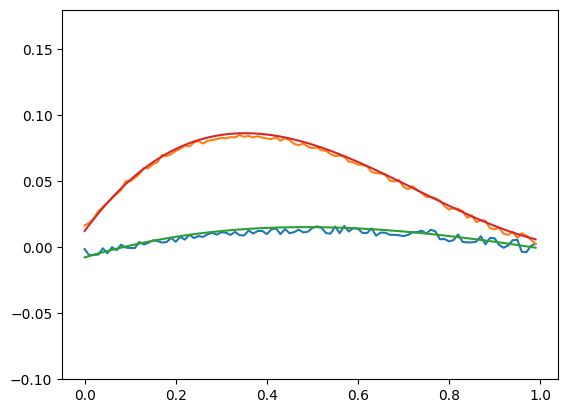

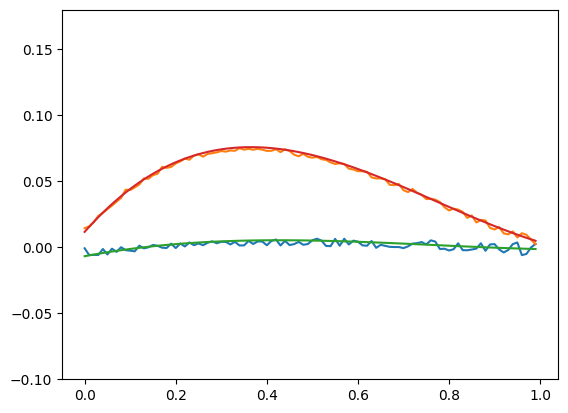

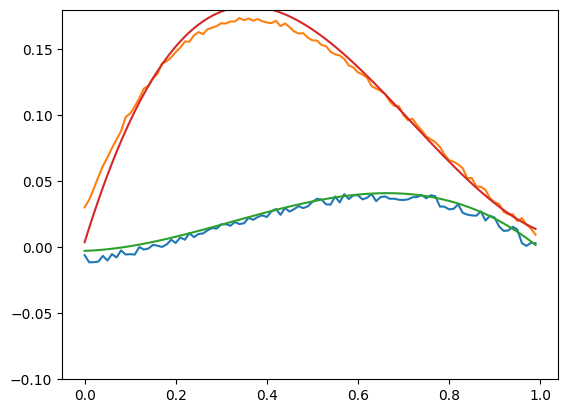

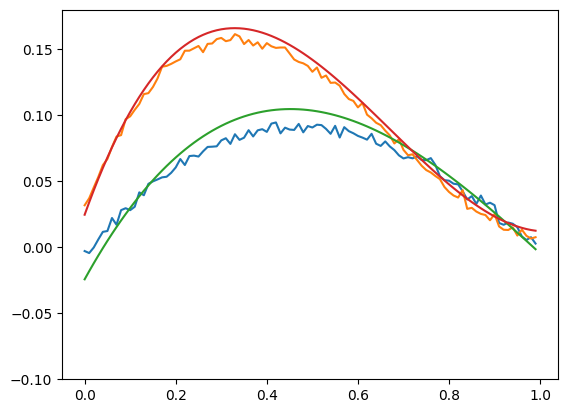

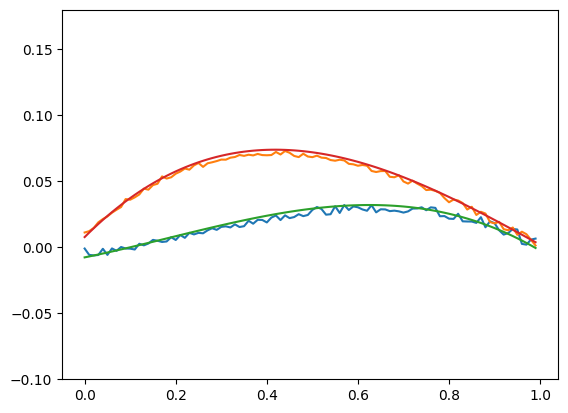

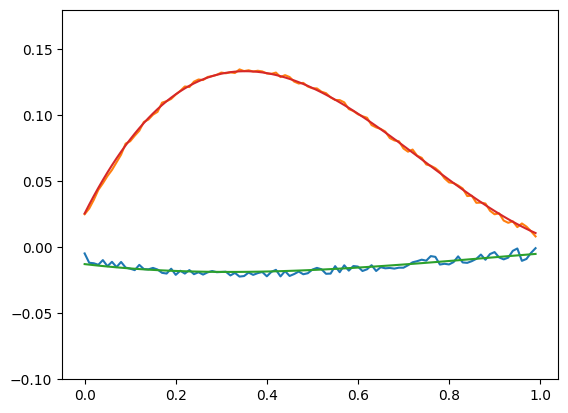

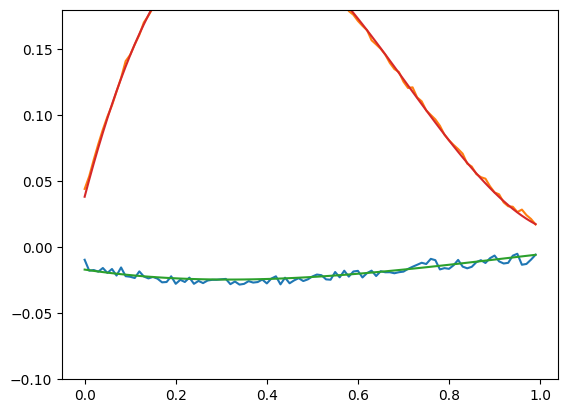

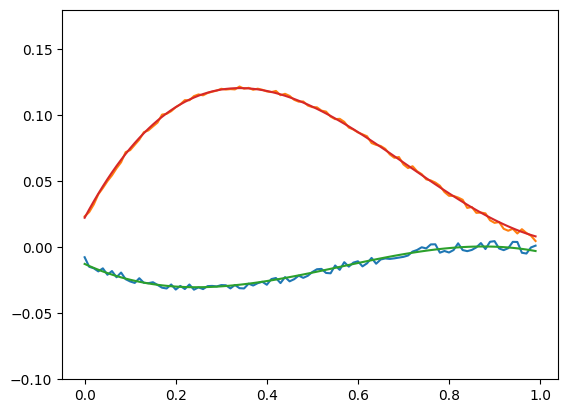

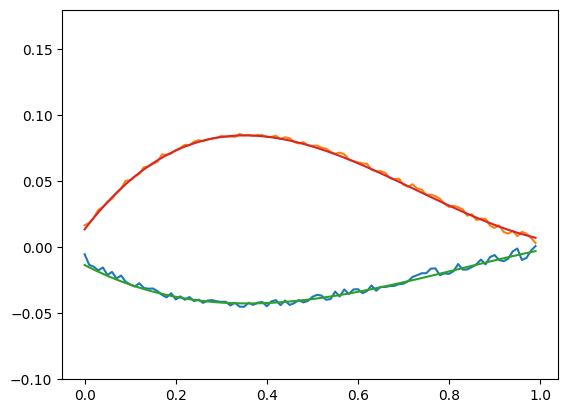

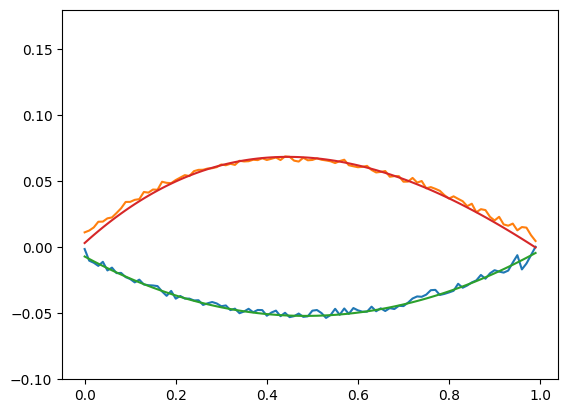

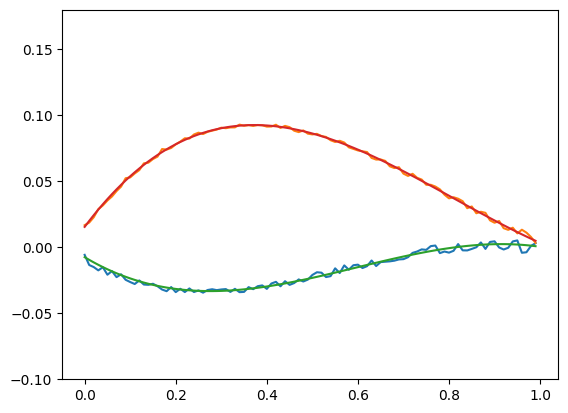

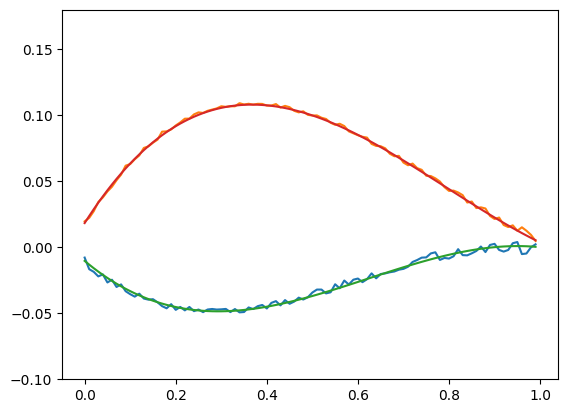

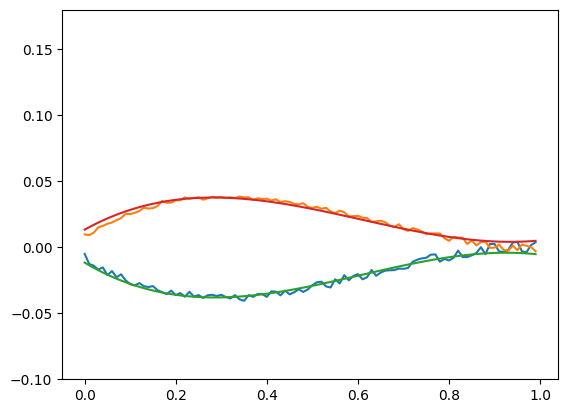

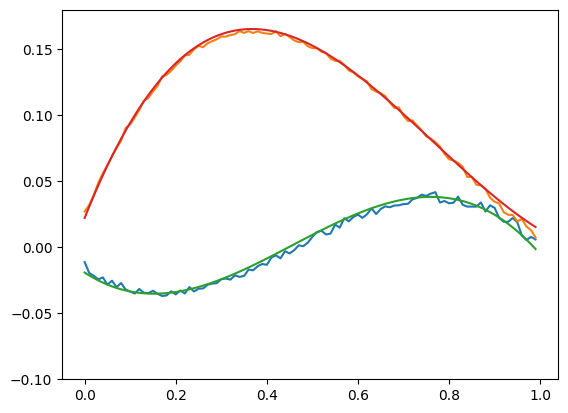

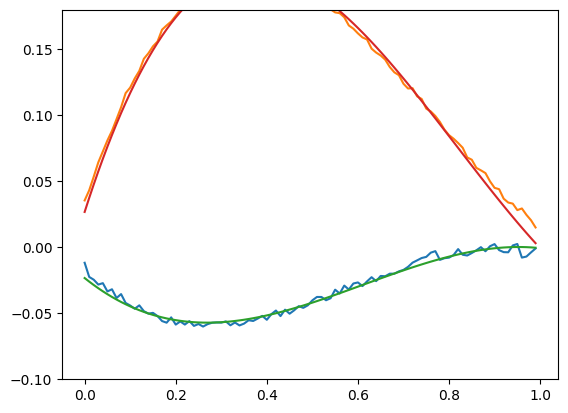

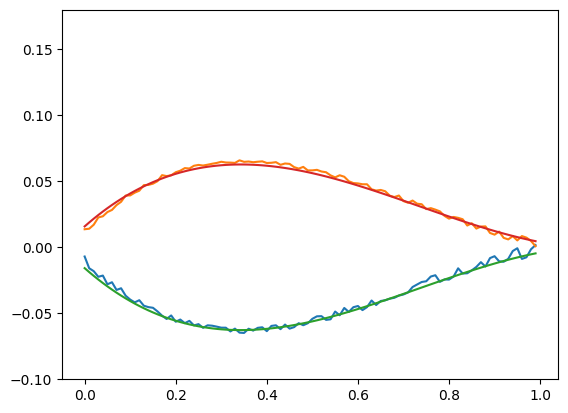

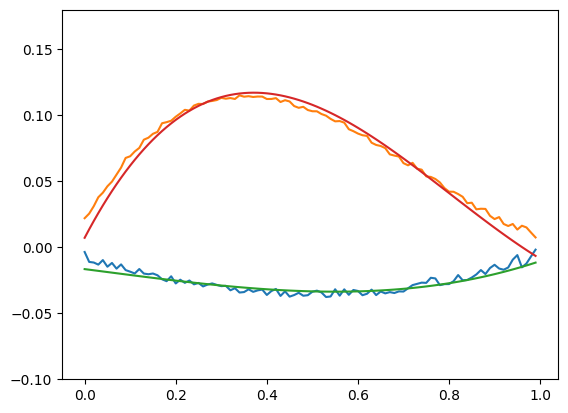

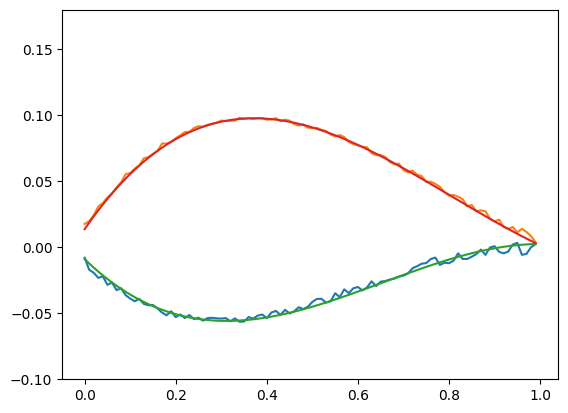

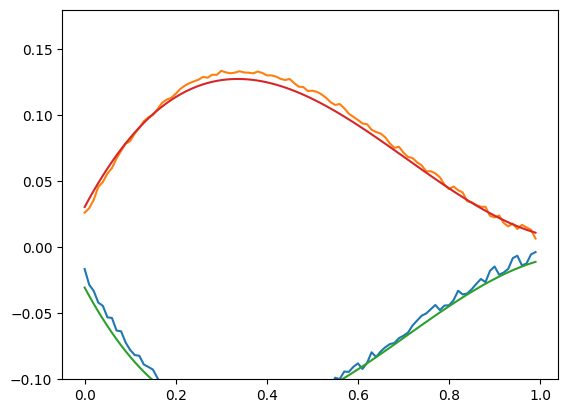

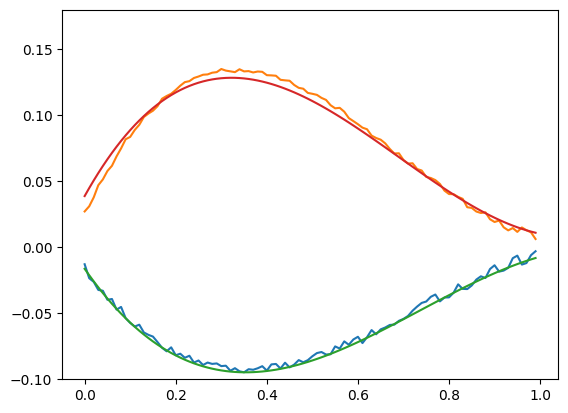

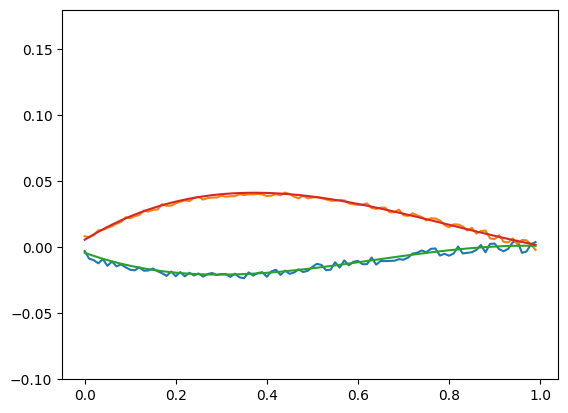

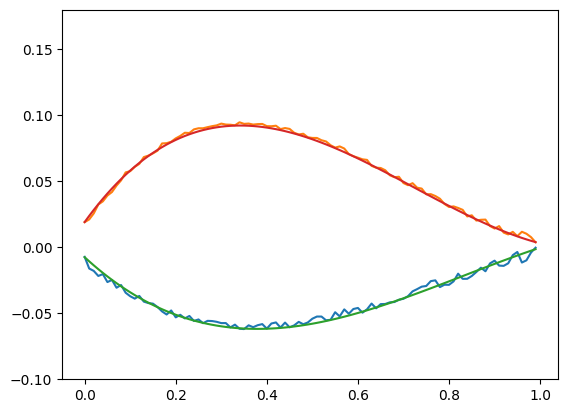

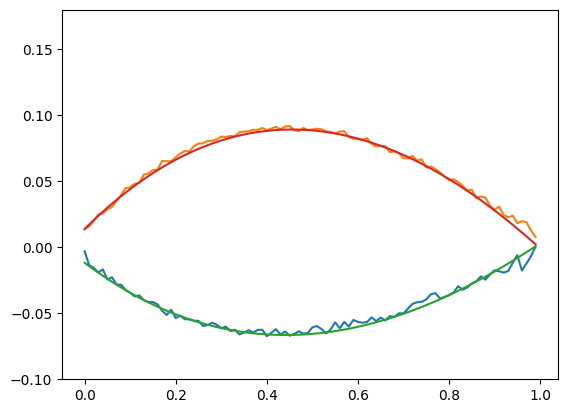

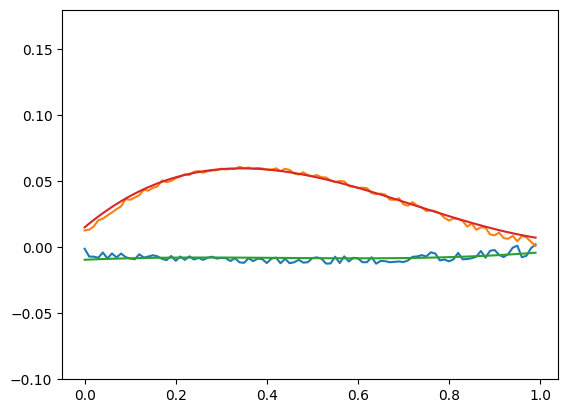

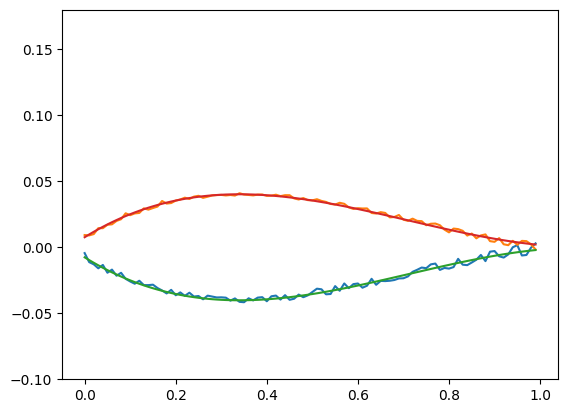

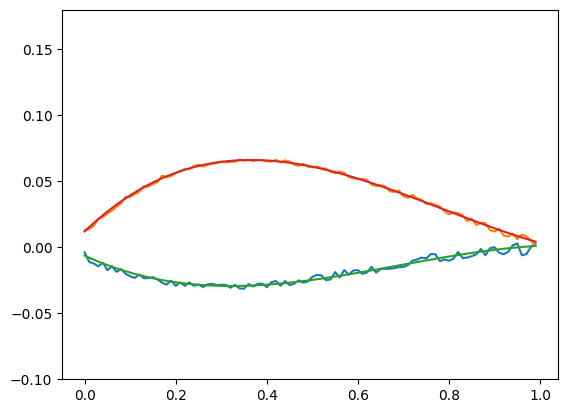

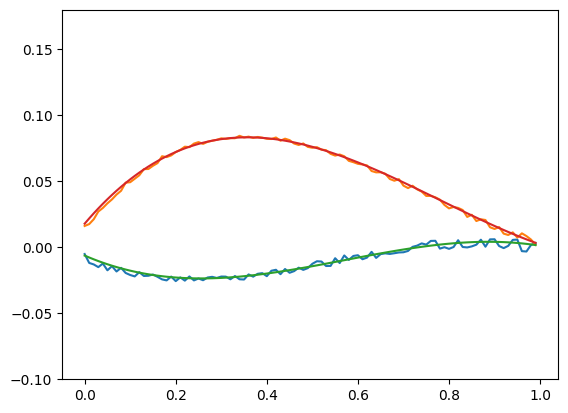

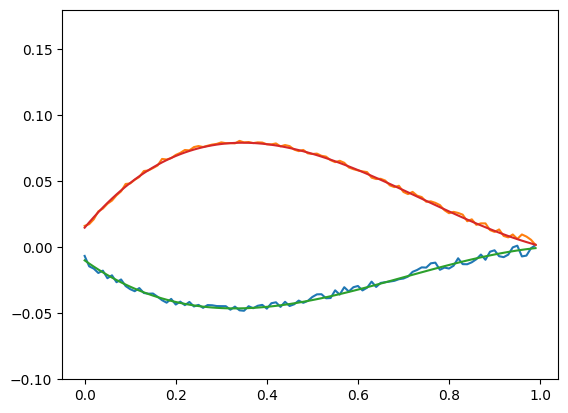

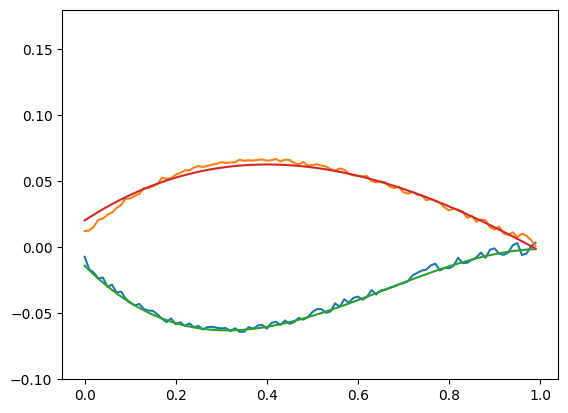

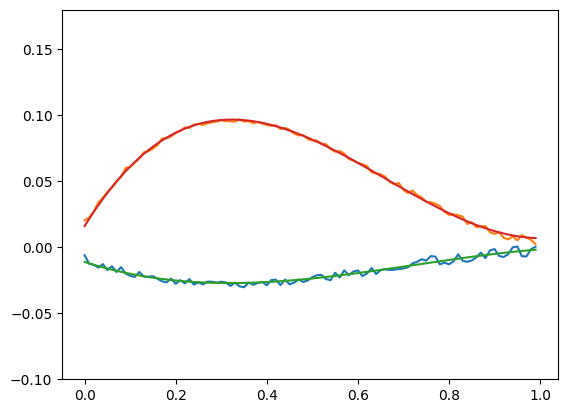

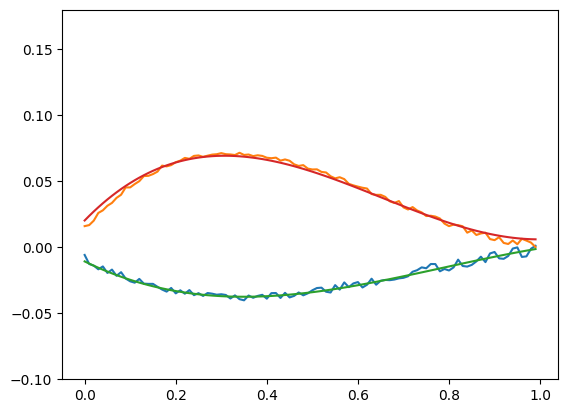

IndexError: list index out of range

In [ ]:
for i in range(10, 100):
        with torch.no_grad():
            z, z_mu, z_logvar, x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last = loaded_vaegan(dataset_test[i])
            outputter(x_recon)

In [ ]:
loaded_vaegan.load_state_dict(torch.load('path/to/your/model.pth'))

# Access the weights
for name, param in loaded_vaegan.named_parameters():
    print(name, param)

## Convolution

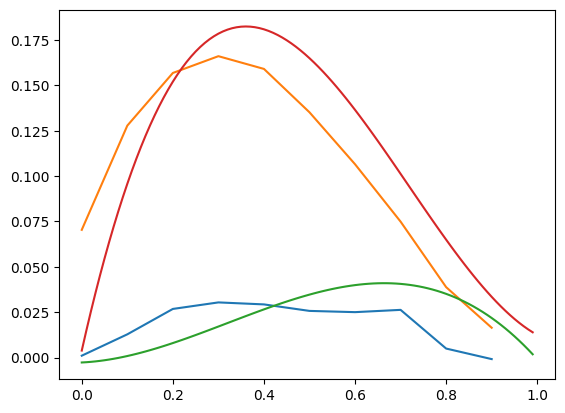

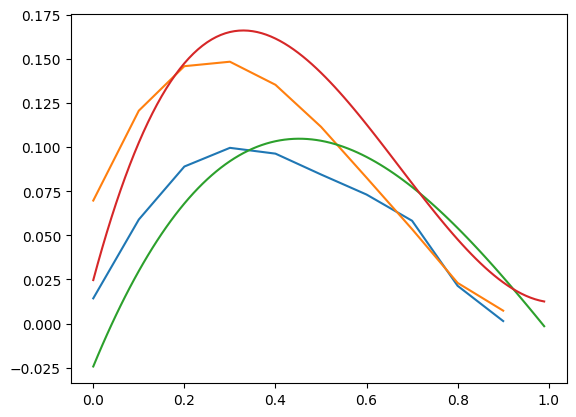

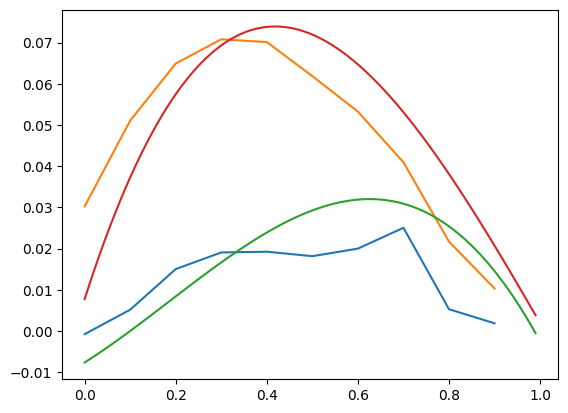

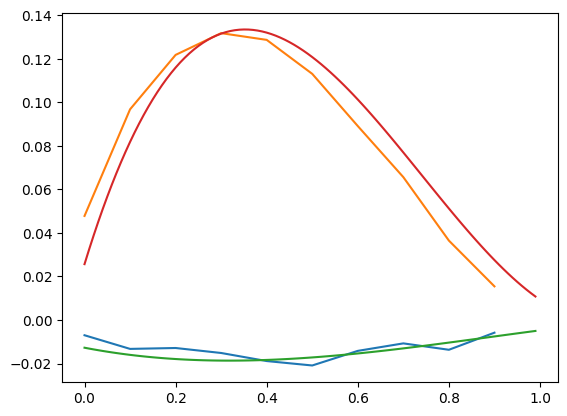

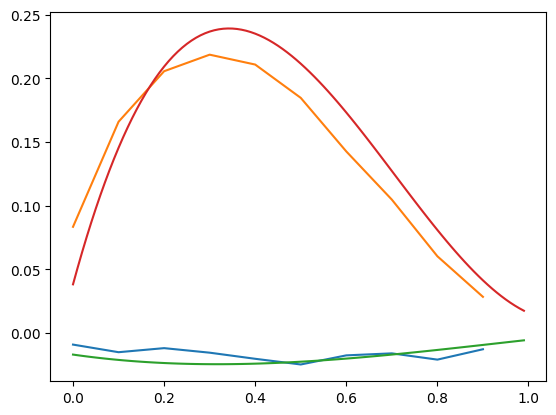

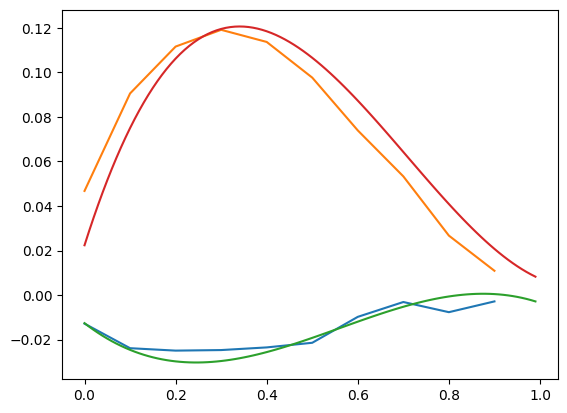

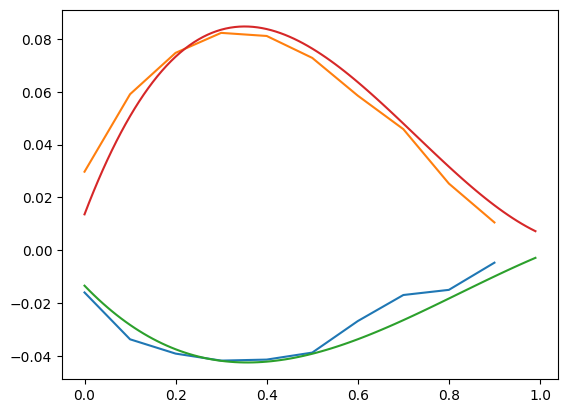

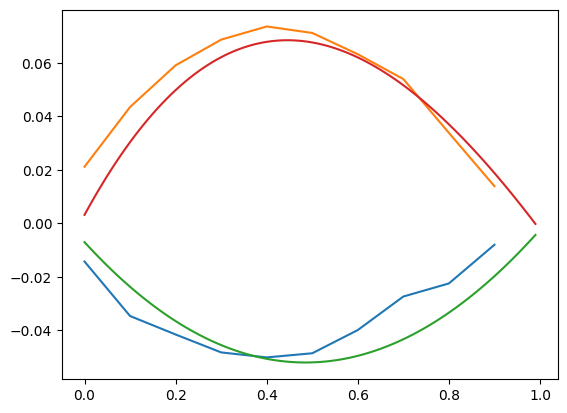

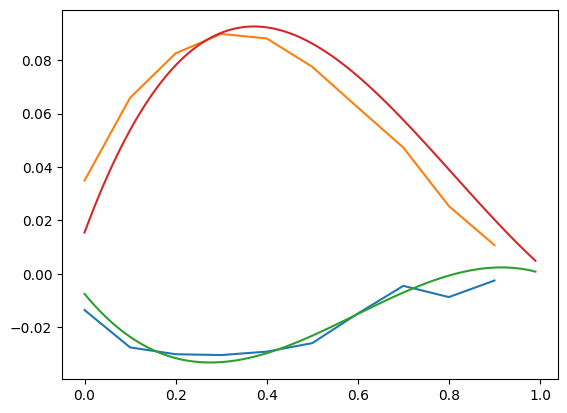

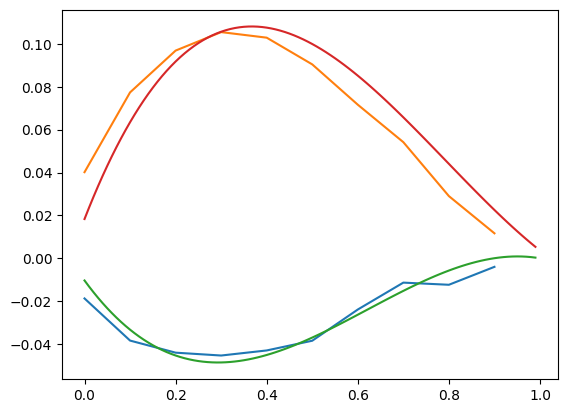

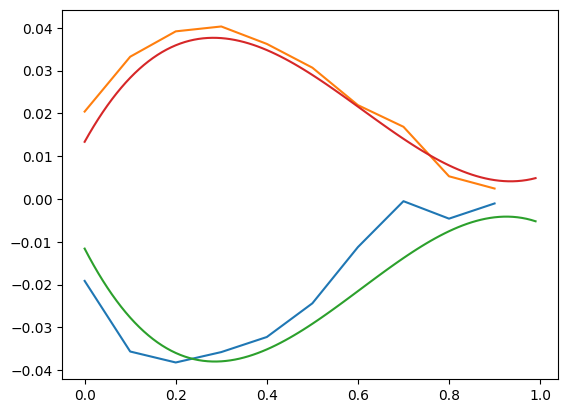

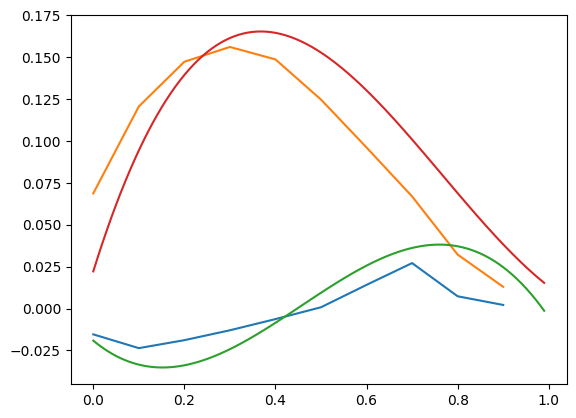

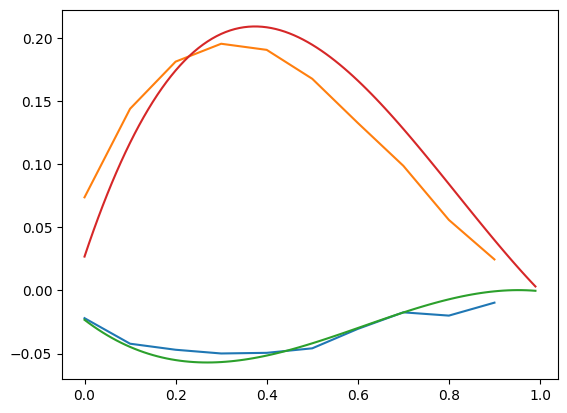

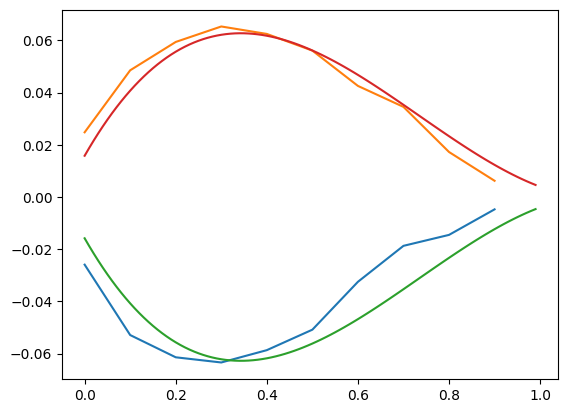

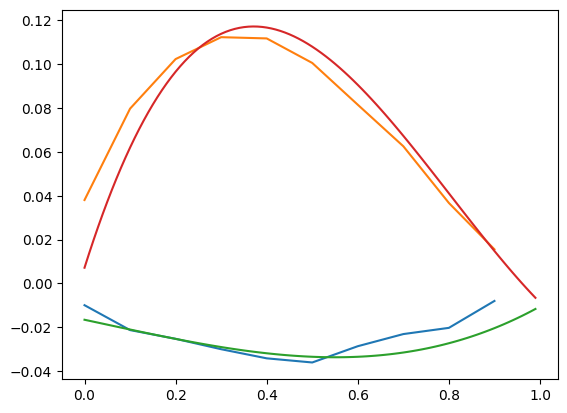

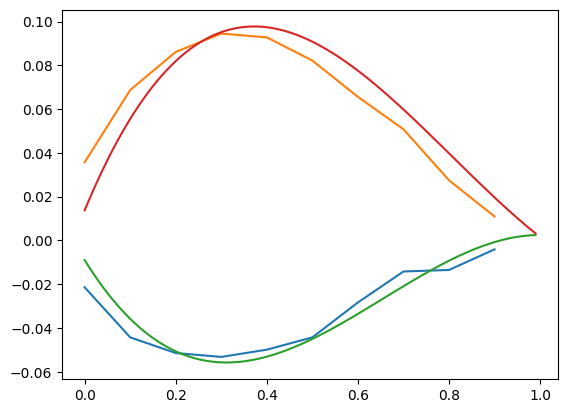

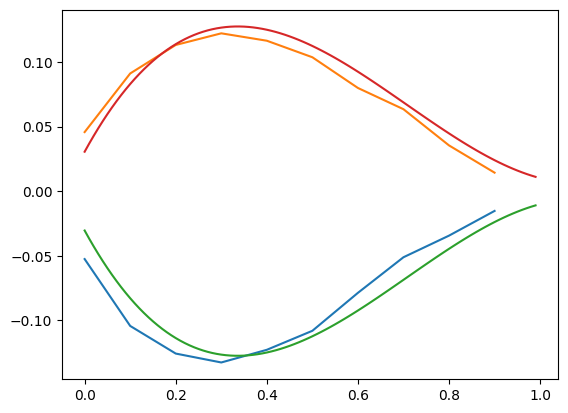

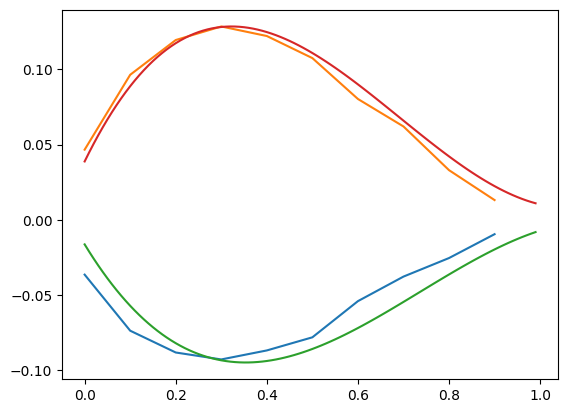

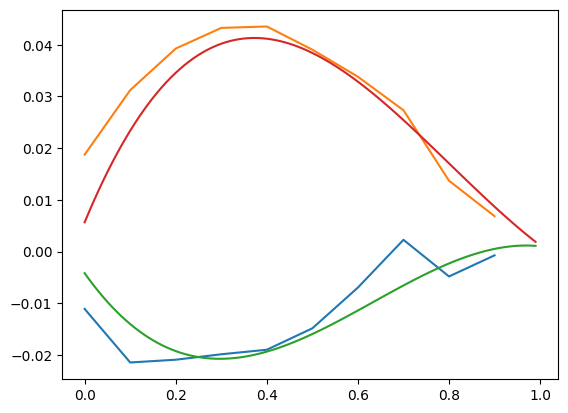

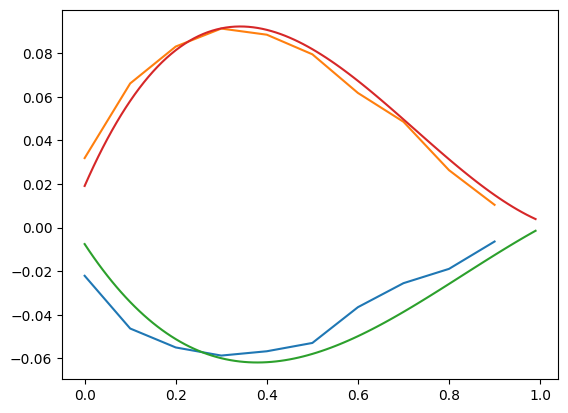

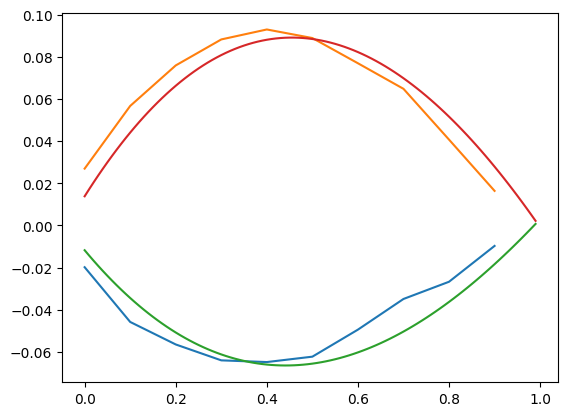

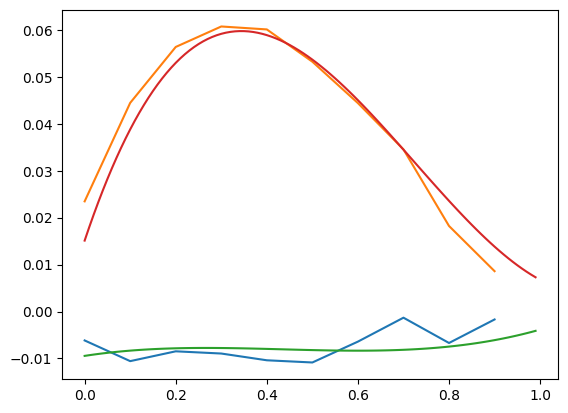

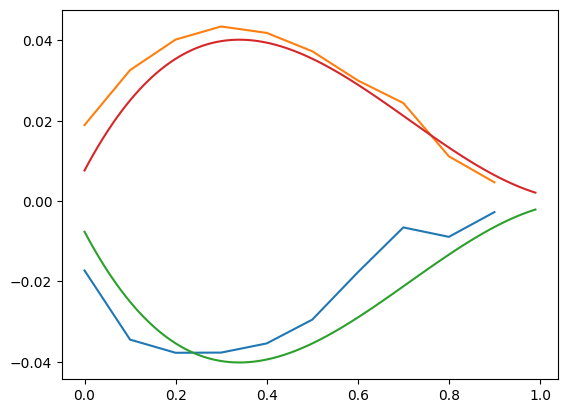

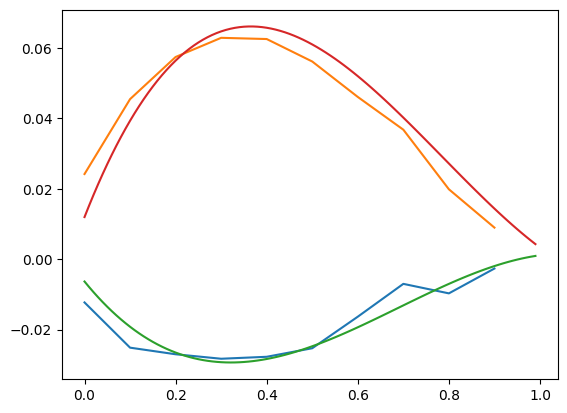

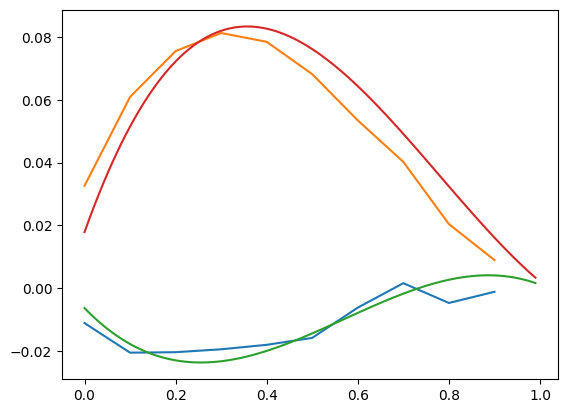

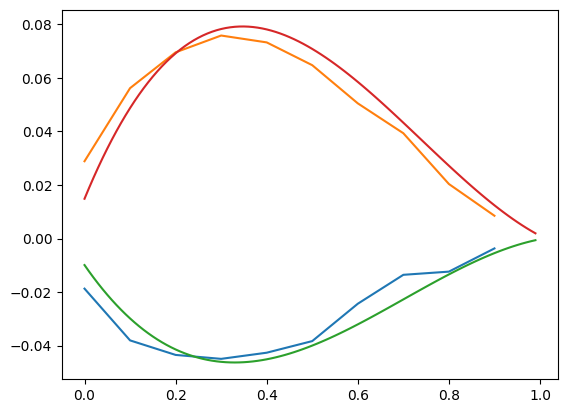

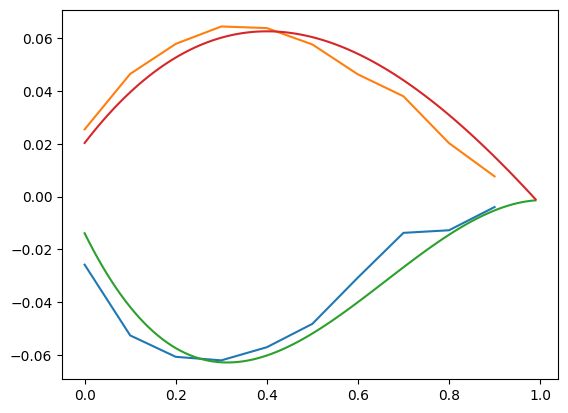

In [ ]:
for i in range(20, 47):
    with torch.no_grad():
        z, z_mu, z_logvar, x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last = loaded_vaegan(dataset_test.__getitem__(i))
    x_axis = [x * 1/10 for x in range(0, 10)]
    y_plot = x_recon.tolist()
    #y_plot = [y_plot[i] for i in range(0, len(y_plot), 10)]
    y_up = y_plot[0:100]
    y_up = [sum(y_up[i:i + 10])/10 for i in range(0, len(y_up), 10)]
    y_bottom = y_plot[100:201]
    y_bottom = [sum(y_bottom[i:i + 10])/10 for i in range(0, len(y_bottom), 10)]

    plt.figure()
    plt.plot(x_axis, y_up)
    plt.plot(x_axis, y_bottom)

    x_axis = [x * 1/100 for x in range(0, 100)]
    y_plot = x.tolist()
    y_up = y_plot[0:100]
    y_bottom = y_plot[100:201]

    #plt.figure()
    plt.plot(x_axis, y_up)
    plt.plot(x_axis, y_bottom)
    plt.show()

## t-SNE

In [ ]:
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

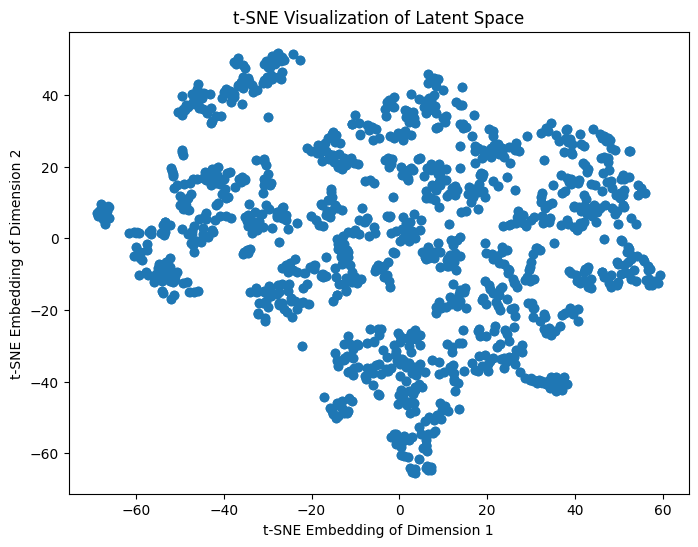

In [ ]:
zs = []
for i in range(0, 1100):
    with torch.no_grad():
        z, z_mu, z_logvar, x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last = loaded_vaegan(dataset_train.__getitem__(i))
        zs.append(z)
        epsilon = np.random.normal(0, 1, z_mu.shape)
        latent_representation = z_mu + np.exp(0.5 * z_logvar) * epsilon
        zs.append(latent_representation)
#print(zs)
#latent_representation_tensor =  torch.tensor(zs, dtype=torch.float, requires_grad=True)
stacked_tensor = torch.stack(zs)

tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(stacked_tensor)

plt.figure(figsize=(8, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1])
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Embedding of Dimension 1')
plt.ylabel('t-SNE Embedding of Dimension 2')
plt.show()

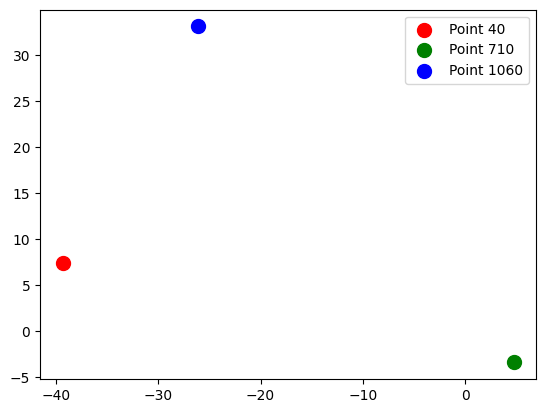

In [ ]:
X_embedded = latent_tsne
highlight_indices = [40, 710, 1060]
highlight_colors = ['r', 'g', 'b']
for idx, color in zip(highlight_indices, highlight_colors):
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], color=color, s=100, label=f'Point {idx}')
plt.legend()

plt.show()

## PCA

In [ ]:
def pca(X, num_components):
    X_new = []
    for sample in X:
        X_new.append(sample.detach().numpy())
    X_mean = np.mean(X_new, axis=0)
    X_centered = X_new - X_mean

    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:,idx]
    top_eigenvectors = eigenvectors[:, :num_components]
    X_transformed = np.dot(X_centered, top_eigenvectors)

    return X_transformed

In [ ]:
z = pca(dataset_val, 32)
z = z.real.astype(float)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1])
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Embedding of Dimension 1')
plt.ylabel('t-SNE Embedding of Dimension 2')
plt.show()

<ipython-input-81-720d6a40da8f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


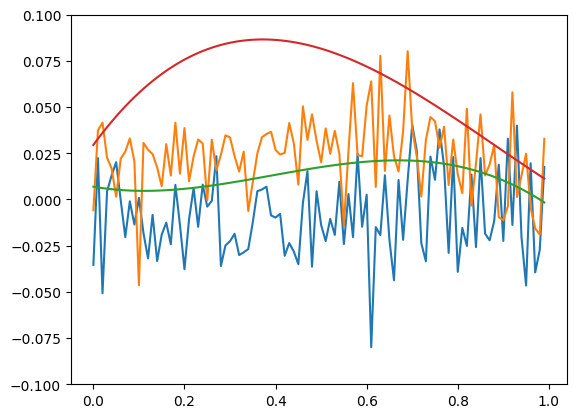

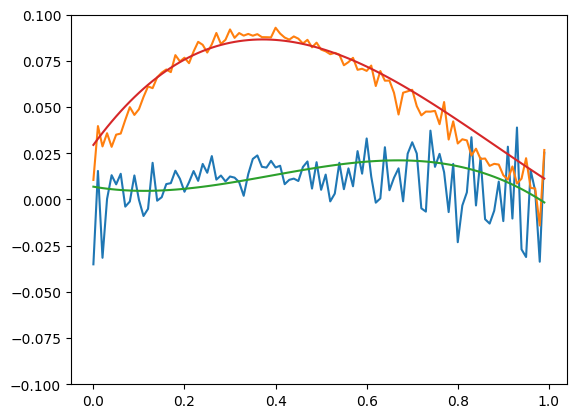

In [ ]:
z = torch.tensor(z)
z = z.float()
outputter(loaded_decoder(z[1]))
with torch.no_grad():
    z_vae, z_mu, z_logvar, x, x_recon, y, y_recon, y_fake, y_before_last, y_fake_before_last = loaded_vaegan(dataset_train.__getitem__(1))
    outputter(loaded_decoder(z_vae))